# Training dataset checks and reweighting studies

In the notebook we study the training dataset and extract the suitable reweighting for the seed energy and photon to electron weights. 

In [2]:
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
mpl.rcParams["image.cmap"] = "Blues"
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (7,4)

import h5py
import os
import numpy as np
from glob import glob
from math import ceil
import hist

import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
version = "v10"

In [4]:
inputdir_ele = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/run3_126X_2023/awkward_126X_mcRun3_2023_forPU65_v4"
inputdir_gamma = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/run3_126X_2023/awkward_126X_mcRun3_2023_forPU65_v4"

In [5]:
cols = ["cl_features", "seed_features", "cl_labels", "window_features", "window_metadata", "cl_h"]

N = 1000000
df_ele = ak.from_parquet(inputdir_ele, lazy=True, use_threads=True, columns=cols)[0:N]
df_gamma = ak.from_parquet(inputdir_gamma, lazy=True, use_threads=True, columns=cols)[0:N]

df = ak.concatenate([df_ele, df_gamma])

In [6]:
print(f"N. electron samples: {ak.num(df_ele['cl_features'], axis=0)}")
print(f"N. gamma samples: {ak.num(df_gamma['cl_features'], axis=0)}")

N. electron samples: 1000000
N. gamma samples: 1000000


In [7]:
output_folder = "/eos/user/j/jabrunne/www/ECAL/Clustering/DeepCluster/plots_check_input/awkward_2022_v10_onlymatched"
os.makedirs(output_folder, exist_ok=True)

# Dataset studies

In [8]:
df_ele.window_metadata.flavour

<Array [11, 11, 11, 11, 11, ... 11, 11, 11, 11] type='1000000 * float64'>

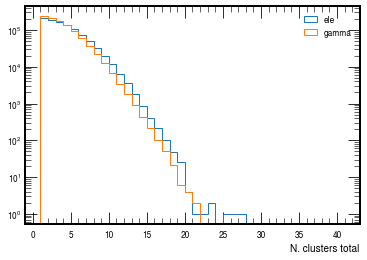

In [9]:
plt.hist(ak.num(df_ele.cl_features, axis=1), bins=40, range=(1, 41), histtype="step", label="ele")
plt.hist(ak.num(df_gamma.cl_features, axis=1), bins=40, range=(1, 41), histtype="step", label="gamma")
plt.yscale("log")
plt.xlabel("N. clusters total")
plt.legend()

In [10]:
df_ele.fields

['cl_features',
 'seed_features',
 'cl_labels',
 'window_features',
 'window_metadata',
 'cl_h']

In [11]:
df_ele.cl_h[3].to_list() #look at window 3, 3 clusters, each with several hits (rows), row=ieta, iphi, iz, energy

[[[22.0, 232.0, 0.0, 48.701053619384766],
  [22.0, 233.0, 0.0, 11.33542959411534],
  [22.0, 234.0, 0.0, 0.3971809692601269],
  [23.0, 234.0, 0.0, 0.4103983800890827],
  [23.0, 233.0, 0.0, 2.467671759683526],
  [23.0, 232.0, 0.0, 3.9437442060577297],
  [23.0, 231.0, 0.0, 0.6550714250927925],
  [22.0, 231.0, 0.0, 0.9520752006671992],
  [21.0, 232.0, 0.0, 0.8003322204329777],
  [21.0, 233.0, 0.0, 0.562843779359639]],
 [[22.0, 233.0, 0.0, 0.0008864174238233241],
  [22.0, 234.0, 0.0, 1.9553009416951005e-05],
  [23.0, 234.0, 0.0, 6.742440285715139e-08],
  [23.0, 233.0, 0.0, 6.439835022200809e-07],
  [23.0, 232.0, 0.0, 1.662368701514244e-06],
  [23.0, 231.0, 0.0, 4.404389657369041e-07],
  [22.0, 231.0, 0.0, 0.00019179038811531664],
  [21.0, 232.0, 0.0, 0.02935074122621062],
  [21.0, 233.0, 0.0, 0.012782543976419867],
  [20.0, 232.0, 0.0, 1.354809045791626]],
 [[20.0, 249.0, 0.0, 0.458279013633728],
  [19.0, 249.0, 0.0, 0.34966644644737244]]]

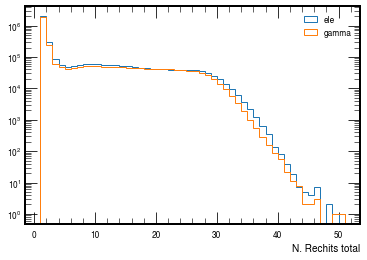

In [13]:
plt.hist(ak.flatten(ak.num(df_ele.cl_h, axis=2)), bins=50, range=(1, 51), histtype="step", label="ele")
plt.hist(ak.flatten(ak.num(df_gamma.cl_h, axis=2)), bins=50, range=(1, 51), histtype="step", label="gamma")
plt.yscale("log")
plt.xlabel("N. Rechits total")
plt.legend()

# Input features

In [14]:
#copy it from features_definitions.json, from updated version on git
default_features_dict = {
        "cl_features" : [ "en_cluster","et_cluster",
                         "en_cluster_log", "et_cluster_log",
                        "cluster_eta", "cluster_phi", 
                        "cluster_ieta","cluster_iphi","cluster_iz",
                        "cluster_deta", "cluster_dphi",
                        "cluster_den_seed","cluster_det_seed",
                        "en_cluster_calib", "et_cluster_calib",
                         "en_cluster_calib_log", "et_cluster_calib_log",
                        "cl_f5_r9", "cl_f5_sigmaIetaIeta", "cl_f5_sigmaIetaIphi",
                        "cl_f5_sigmaIphiIphi","cl_f5_swissCross",
                        "cl_r9", "cl_sigmaIetaIeta", "cl_sigmaIetaIphi",
                        "cl_sigmaIphiIphi","cl_swissCross",
                        "cl_nxtals", "cl_etaWidth","cl_phiWidth"],


    "cl_metadata": [ "calo_score", "calo_simen_sig", "calo_simen_PU",
                     "cluster_PUfrac","calo_nxtals_PU",
                     "noise_en","noise_en_uncal","noise_en_nofrac","noise_en_uncal_nofrac" ],

    "cl_labels" : ["is_seed","is_calo_matched","is_calo_seed", "in_scluster","in_geom_mustache"],

    
    "seed_features" : ["seed_eta","seed_phi", "seed_ieta","seed_iphi", "seed_iz", 
                     "en_seed", "et_seed","en_seed_calib","et_seed_calib",
                       "en_seed_log", "et_seed_log","en_seed_calib_log","et_seed_calib_log",
                    "seed_f5_r9","seed_f5_sigmaIetaIeta", "seed_f5_sigmaIetaIphi",
                    "seed_f5_sigmaIphiIphi","seed_f5_swissCross",
                    "seed_r9","seed_sigmaIetaIeta", "seed_sigmaIetaIphi",
                    "seed_sigmaIphiIphi","seed_swissCross",
                    "seed_nxtals","seed_etaWidth","seed_phiWidth"
                    ],

    "seed_metadata": [ "seed_score", "seed_simen_sig", "seed_simen_PU", "seed_PUfrac"],
    "seed_labels" : [ "is_seed_calo_matched", "is_seed_calo_seed", "is_seed_mustache_matched"],

     "window_features" : [ "max_en_cluster","max_et_cluster","max_deta_cluster","max_dphi_cluster","max_den_cluster","max_det_cluster",
                         "min_en_cluster","min_et_cluster","min_deta_cluster","min_dphi_cluster","min_den_cluster","min_det_cluster",
                         "mean_en_cluster","mean_et_cluster","mean_deta_cluster","mean_dphi_cluster","mean_den_cluster","mean_det_cluster" ],

    "window_metadata": ["flavour", "ncls", "nclusters_insc",
                        "nVtx", "rho", "obsPU", "truePU",
                        "sim_true_eta", "sim_true_phi",  
                        "gen_true_eta","gen_true_phi",
                        "en_true_sim","et_true_sim", "en_true_gen", "et_true_gen",
                        "en_true_sim_good", "et_true_sim_good",
                        "en_mustache_raw", "et_mustache_raw","en_mustache_calib", "et_mustache_calib",
                        "max_en_cluster_insc","max_deta_cluster_insc","max_dphi_cluster_insc",
                        "event_tot_simen_PU","wtot_simen_PU","wtot_simen_sig" ],
}

## Features normalization

In [15]:
stats = {}

for cl_f in default_features_dict["cl_features"]:
    m = ak.mean(df.cl_features[cl_f])
    s = ak.std(df.cl_features[cl_f])
    mmin = ak.min(df.cl_features[cl_f])
    mmax = ak.max(df.cl_features[cl_f])
    stats[cl_f] = { "mean": m, "std":s, "min": mmin, "max": mmax}
    print(f"Feature: {cl_f}, mean: {m}, std: {s}")

Feature: en_cluster, mean: 213.733671402766, std: 525.232453282193
Feature: et_cluster, mean: 68.27105460647881, std: 130.71981530073353
Feature: en_cluster_log, mean: 2.3708759746322507, std: 2.477911105745853
Feature: et_cluster_log, mean: 1.876761907418469, std: 2.1697113574882936
Feature: cluster_eta, mean: 0.015200908059416976, std: 1.4463253811248526
Feature: cluster_phi, mean: -0.0013894406860254884, std: 1.810559824239036
Feature: cluster_ieta, mean: 18.212573220069523, std: 51.41927930256518
Feature: cluster_iphi, mean: 134.717322602631, std: 105.11234933238806
Feature: cluster_iz, mean: 0.004600607418978272, std: 0.5926142856791411
Feature: cluster_deta, mean: 0.01266778178155557, std: 0.06789880961029843
Feature: cluster_dphi, mean: -7.681406097826286e-05, std: 0.29244243516399815
Feature: cluster_den_seed, mean: 347.3216597326399, std: 450.85513843998353
Feature: cluster_det_seed, mean: 163.0781068778436, std: 160.63670491099757
Feature: en_cluster_calib, mean: 224.73847210

In [16]:
def std_scaling(X, cl_f, range=(0,1)):
    mean = stats[cl_f]["mean"]
    std = stats[cl_f]["std"]
    return (X-mean)/std

def min_max_scaling(X, cl_f, range=(0,1)):
    mmax = stats[cl_f]["max"]
    mmin = stats[cl_f]["min"]
    X_std = (X - mmin) / (mmax - mmin)
    X_scaled = X_std * (range[1]-range[0]) + range[0]
    return X_scaled

## Input features plots

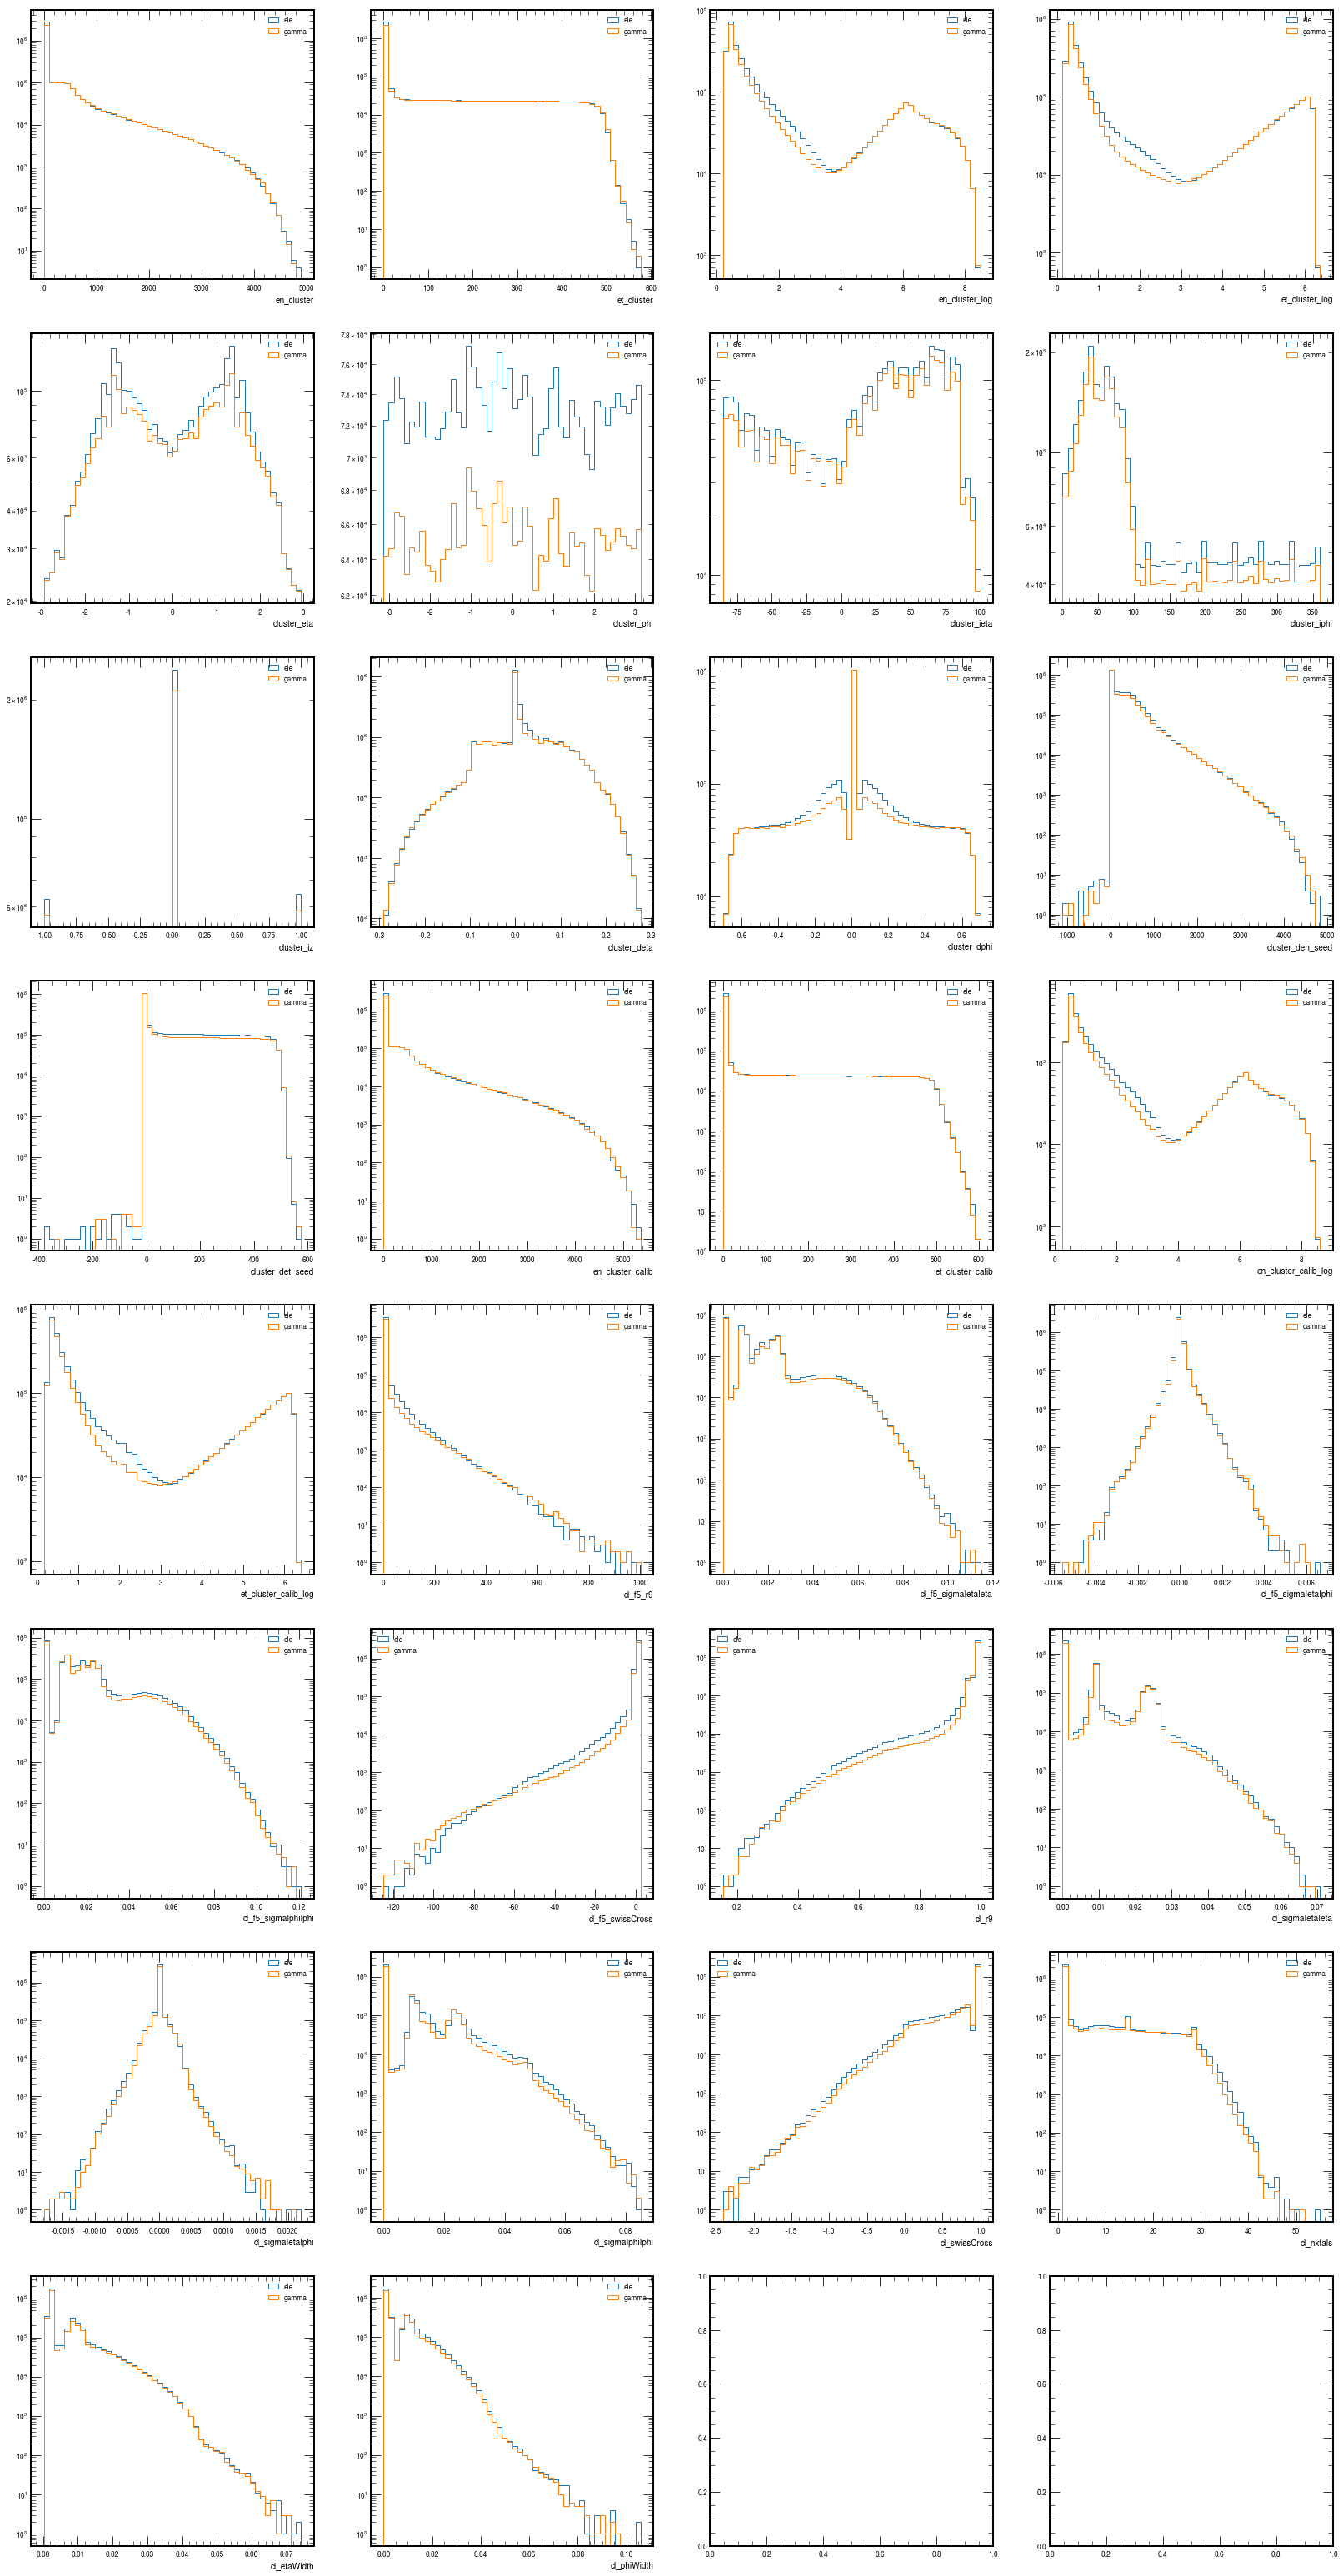

In [17]:
cols = 4
rows = ceil(len(default_features_dict["cl_features"]) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(7*cols, 7*rows))

for iplot, cl_f in enumerate(default_features_dict["cl_features"]):
    ax = axs[iplot//cols][iplot % cols]
    count,bins, _ = ax.hist(ak.flatten(df_ele.cl_features[cl_f]), bins=50, histtype="step", label="ele")
    ax.hist(ak.flatten(df_gamma.cl_features[cl_f]), bins=bins, histtype="step", label="gamma")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(cl_f)
    

### Sig vs bkg features

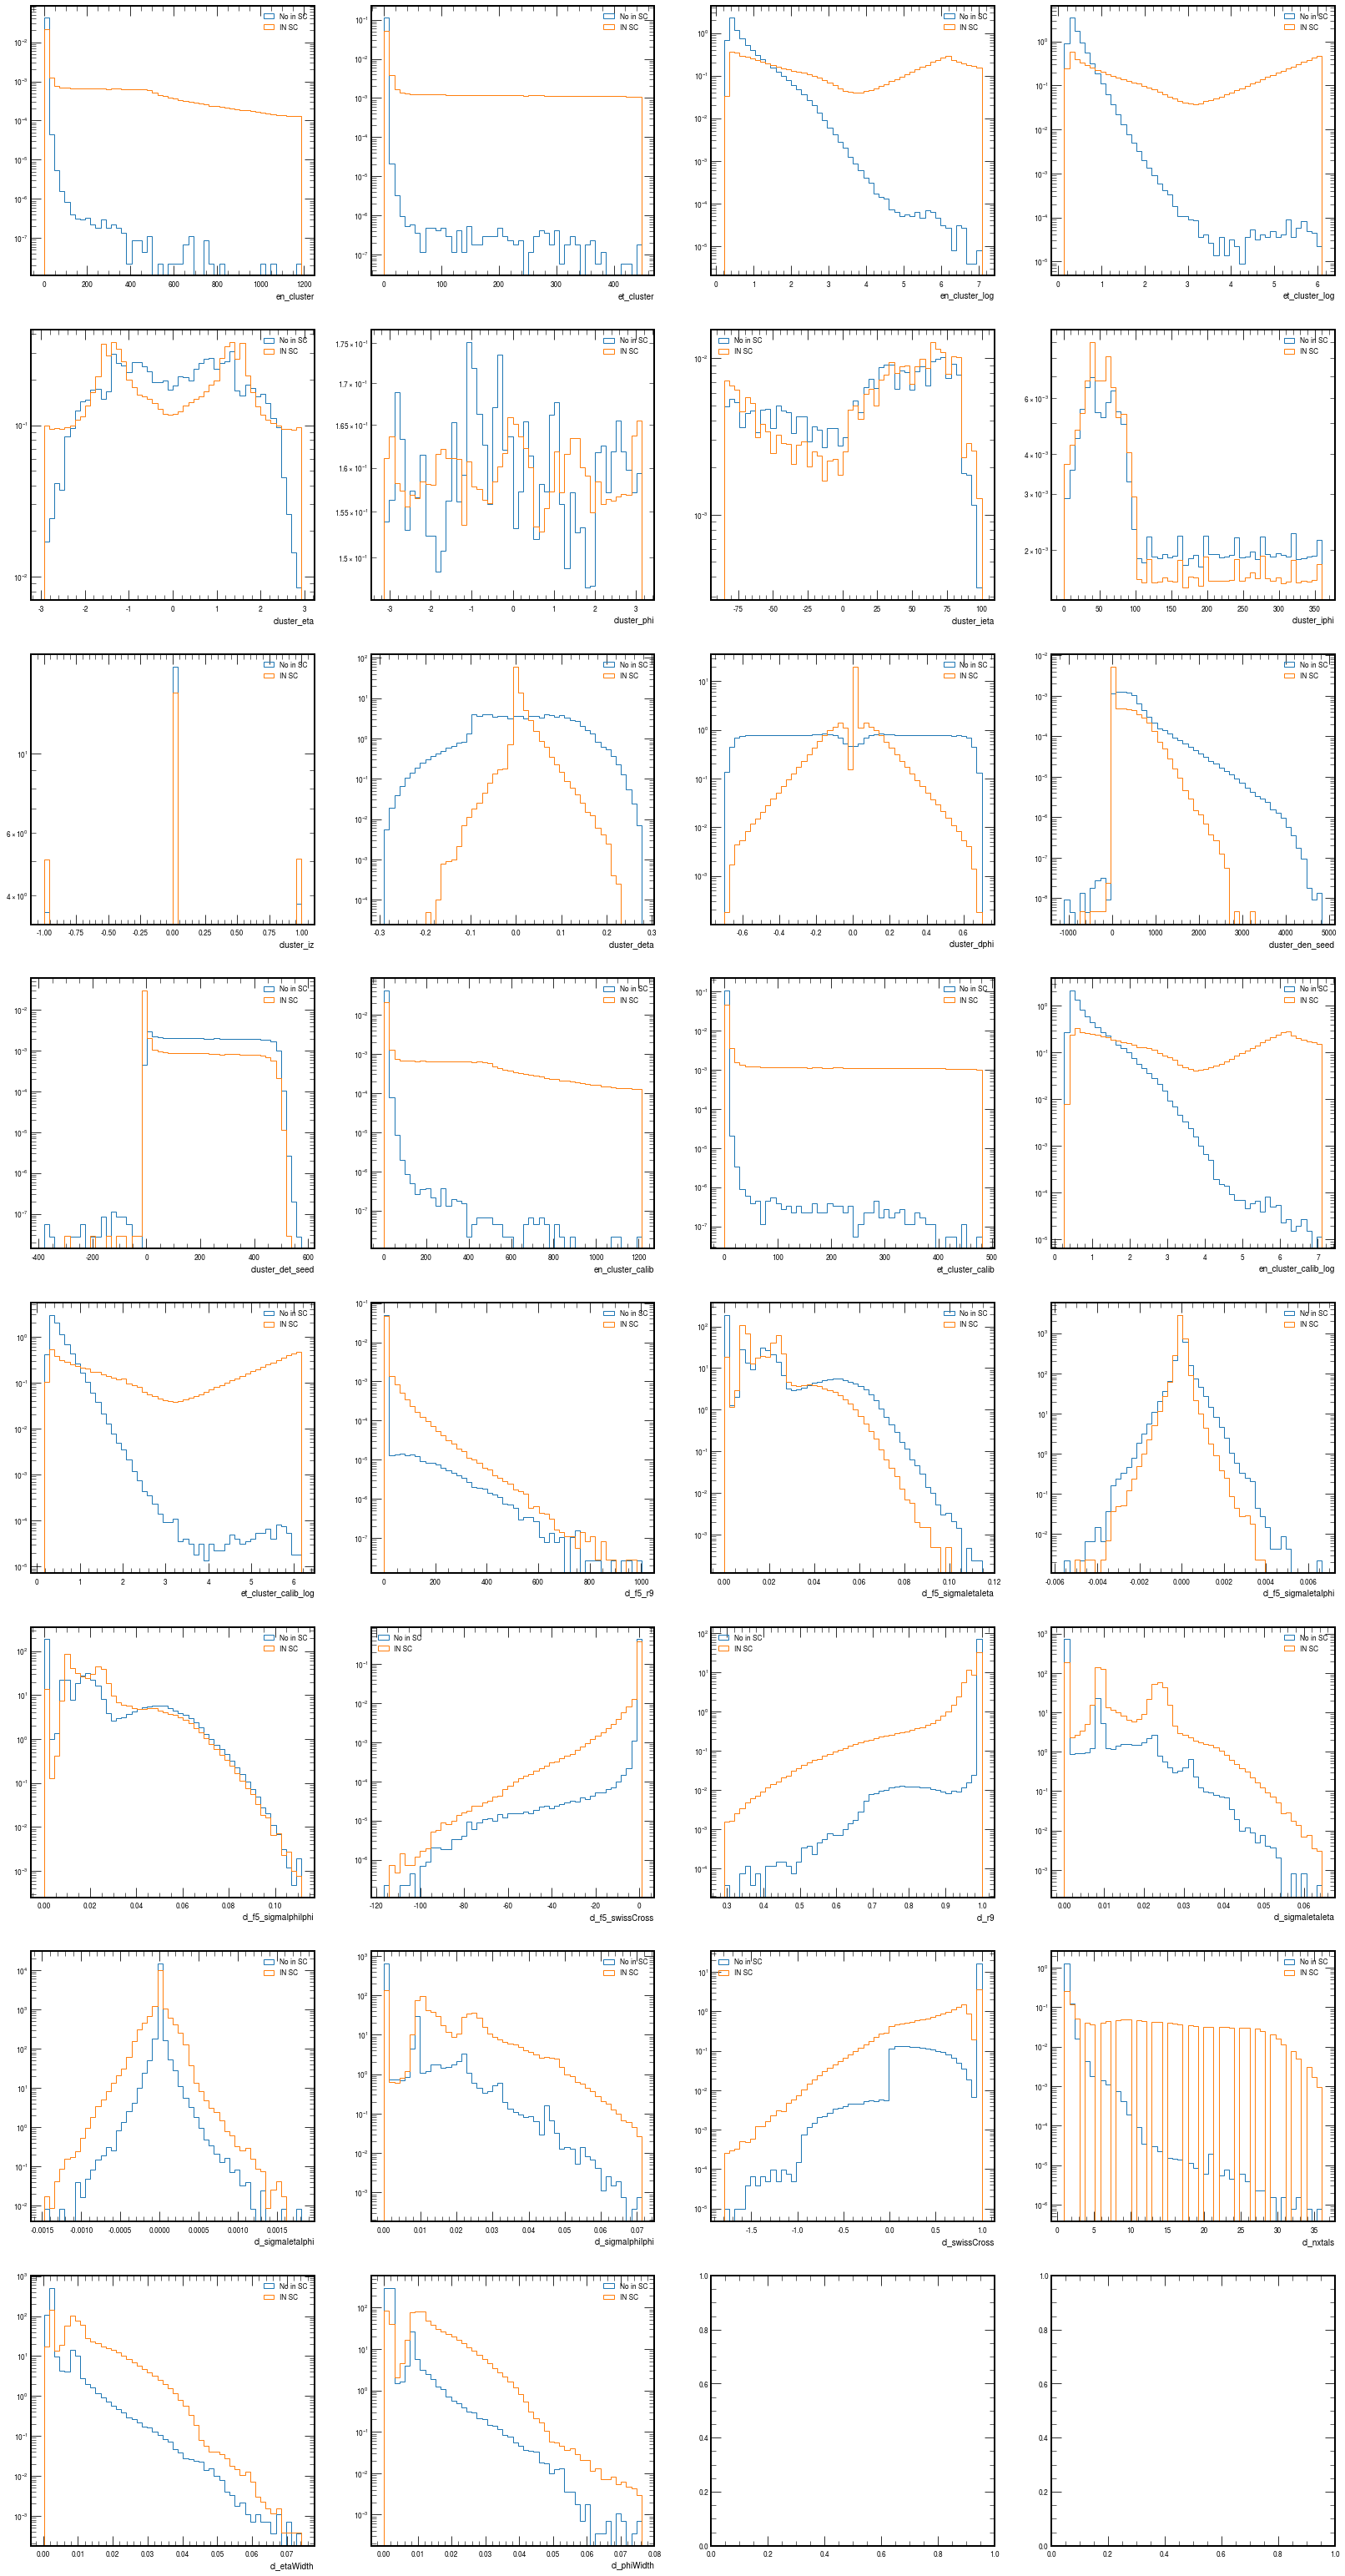

In [18]:
cols = 4
rows = ceil(len(default_features_dict["cl_features"]) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(7*cols, 7*rows))

for iplot, cl_f in enumerate(default_features_dict["cl_features"]):
    ax = axs[iplot//cols][iplot % cols]
    count,bins, _ = ax.hist(ak.flatten(df_ele.cl_features[df_ele.cl_labels.in_scluster==0][cl_f]), bins=50, histtype="step", label="No in SC", density=True)
    ax.hist(ak.flatten(df_ele.cl_features[df_ele.cl_labels.in_scluster==1][cl_f]), bins=bins, histtype="step", label="IN SC",density=True)
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(cl_f)
    

### Features with std-scaling

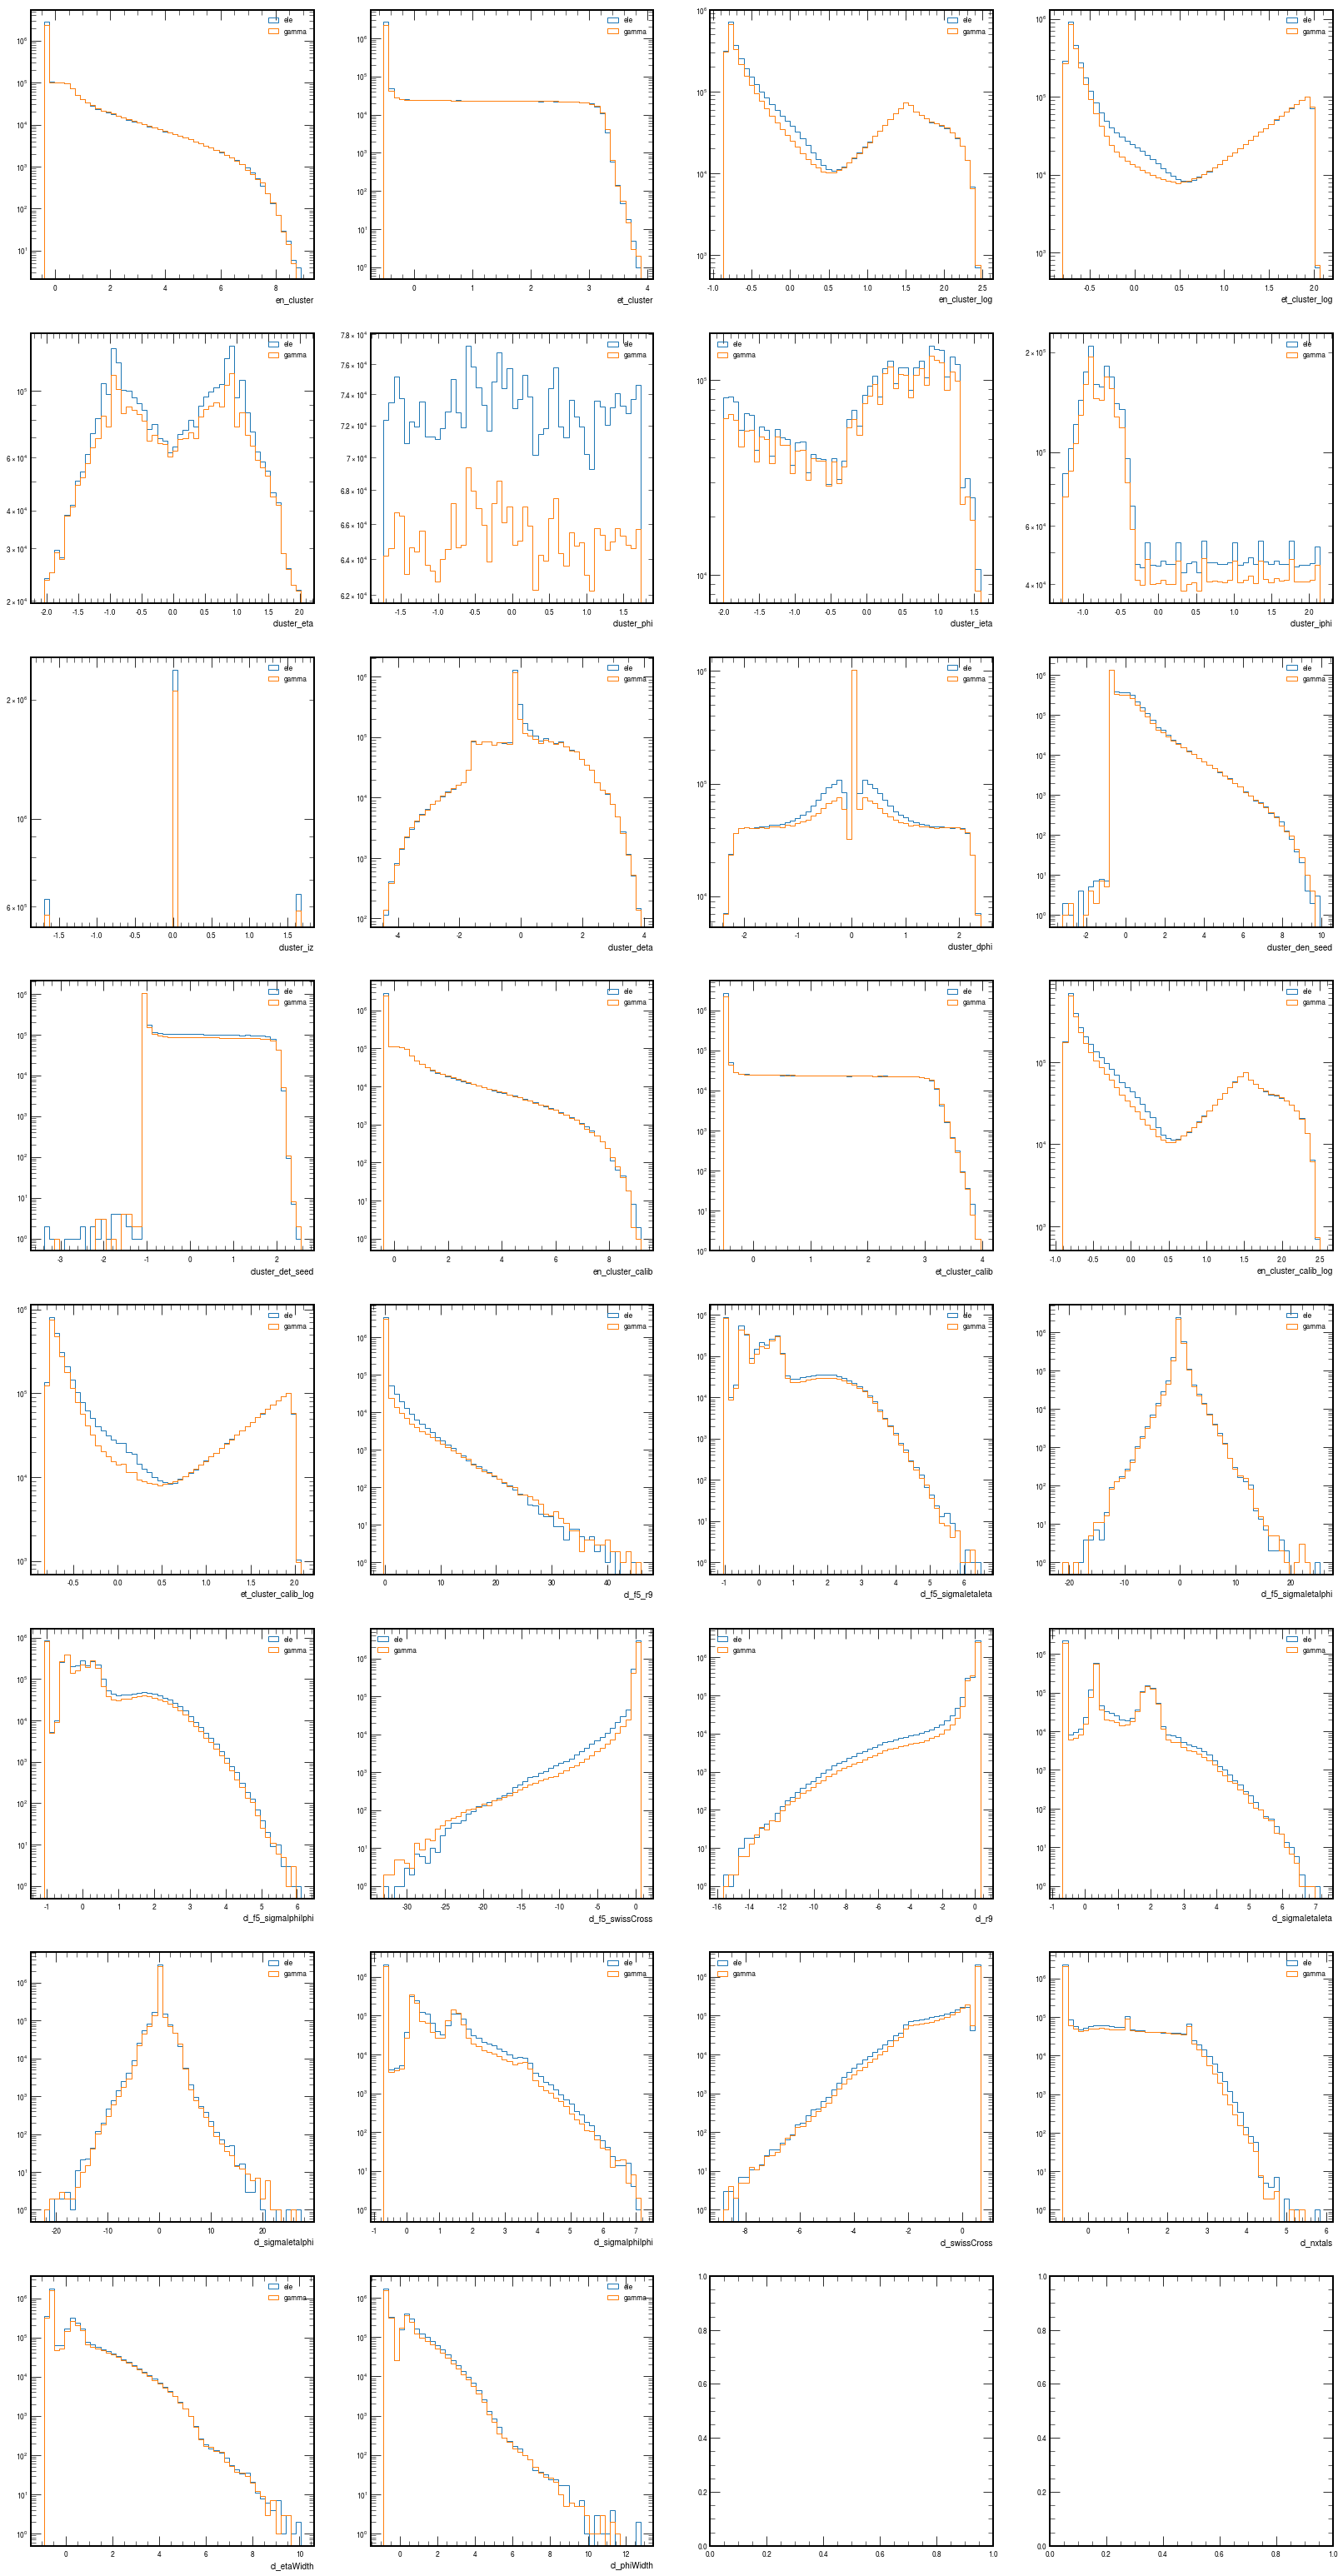

In [19]:
cols = 4
rows = ceil(len(default_features_dict["cl_features"]) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(7*cols, 7*rows))

for iplot, cl_f in enumerate(default_features_dict["cl_features"]):
    ax = axs[iplot//cols][iplot % cols]
    count,bins, _ = ax.hist(std_scaling(ak.flatten(df_ele.cl_features[cl_f]), cl_f), bins=50, histtype="step", label="ele")
    ax.hist(std_scaling(ak.flatten(df_gamma.cl_features[cl_f]), cl_f), bins=bins, histtype="step", label="gamma")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(cl_f)

### Features with min-max scaling

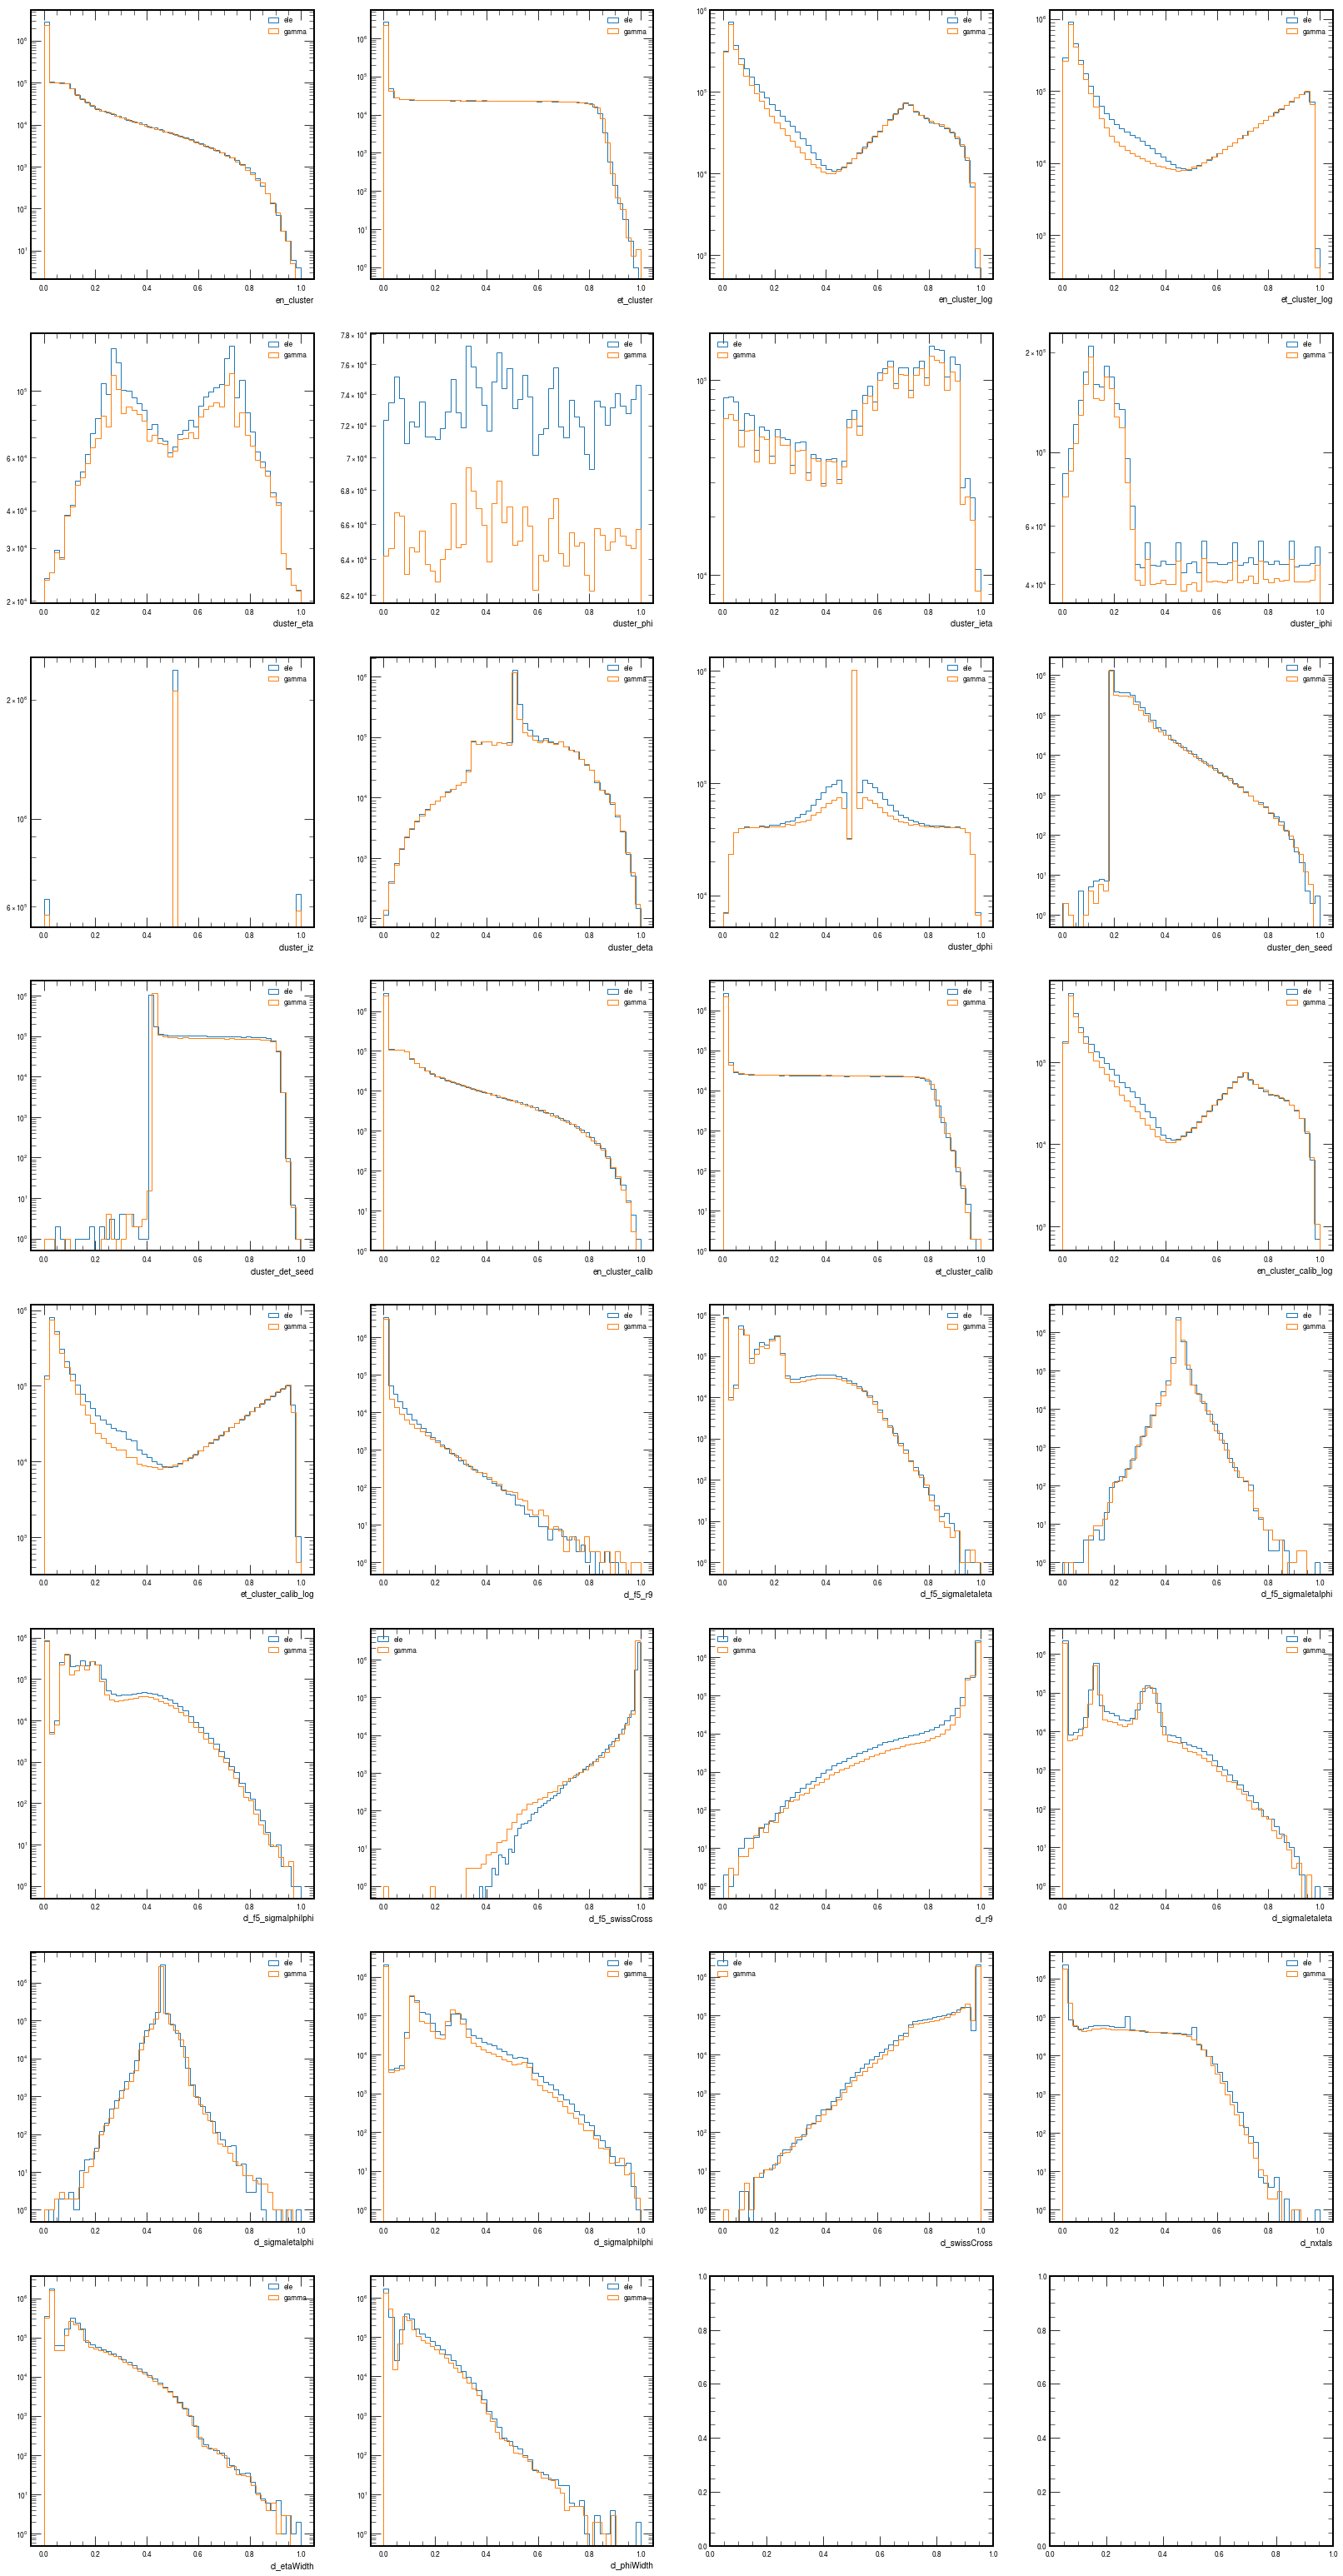

In [20]:
cols = 4
rows = ceil(len(default_features_dict["cl_features"]) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(7*cols, 7*rows))

for iplot, cl_f in enumerate(default_features_dict["cl_features"]):
    ax = axs[iplot//cols][iplot % cols]
    ax.hist(min_max_scaling(ak.flatten(df_ele.cl_features[cl_f]), cl_f), bins=50, histtype="step", label="ele")
    ax.hist(min_max_scaling(ak.flatten(df_gamma.cl_features[cl_f]), cl_f), bins=50, histtype="step", label="gamma")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel(cl_f)

### Plot rechits detector window

In [21]:
def plot_window_rechits(df):
    d = 5
    xmin = ak.min(df[:,:,1])-d
    xmax = ak.max(df[:,:,1])+d
    ymin = ak.min(df[:,:,0])-d
    ymax = ak.max(df[:,:,0])+d
    plt.hist2d(ak.flatten(df[:,:,1]), ak.flatten(df[:,:,0]), weights=ak.flatten(df[:,:,3]), range=((xmin, xmax), (ymin, ymax)), bins=(int(xmax-xmin), int(ymax-ymin)), norm=LogNorm(), cmap="viridis")
    plt.ylabel("ieta")
    plt.xlabel("iphi")
    plt.colorbar(label="Rechit Energy [GeV]")
    plt.show()

# Delta Energy seed investigation
Only in some cases the seed has a lower energy than the cluster --> this can happen when the window is not symmetric in dEta, towards the endcap

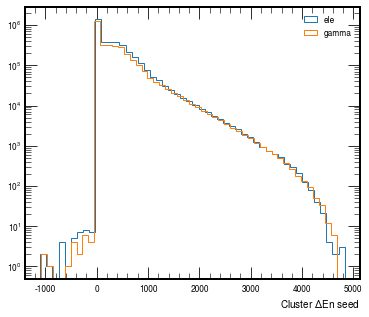

In [23]:
plt.figure(figsize=(6,5))
plt.hist(ak.flatten(df_ele.cl_features.cluster_den_seed), bins=50, histtype="step", label="ele")
plt.hist(ak.flatten(df_gamma.cl_features.cluster_den_seed), bins=50,  histtype="step", label="gamma")
plt.yscale("log")
plt.xlabel("Cluster $\Delta En$ seed")
plt.legend()

In [24]:
mask = df.cl_features.cluster_den_seed < 0 

Text(1, 0, 'Cluster $\\eta$')

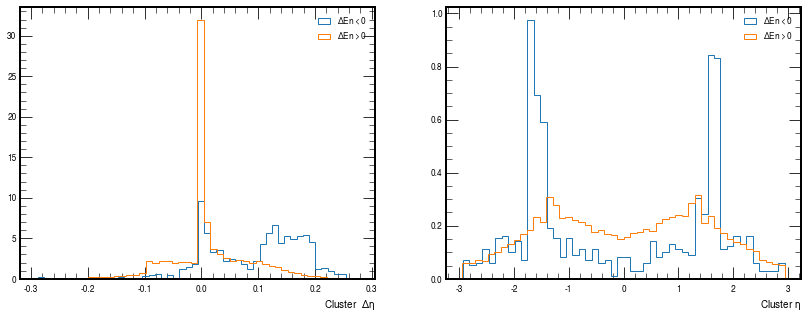

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].hist(ak.flatten(df.cl_features.cluster_deta[mask]), bins=50, histtype="step", label="$\Delta En < 0$", density=True)
axs[0].hist(ak.flatten(df.cl_features.cluster_deta[~mask]), bins=50, histtype="step", label="$\Delta En > 0$", density=True)
axs[0].legend()
axs[0].set_xlabel("Cluster  $\Delta \eta$")

axs[1].hist(ak.flatten(df.cl_features.cluster_eta[mask]), bins=50, histtype="step", label="$\Delta En < 0$", density=True)
axs[1].hist(ak.flatten(df.cl_features.cluster_eta[~mask]), bins=50, histtype="step", label="$\Delta En > 0$", density=True)
axs[1].legend()
axs[1].set_xlabel("Cluster $\eta$")

# Electron and photon seed $\eta$ and $E_T$ checks

In [26]:
ele_seed_eta= abs(ak.to_numpy(df_ele.seed_features.seed_eta))
ele_seed_et = ak.to_numpy(df_ele.seed_features.et_seed)
gam_seed_eta= abs(ak.to_numpy(df_gamma.seed_features.seed_eta))
gam_seed_et = ak.to_numpy(df_gamma.seed_features.et_seed)
ele_ncls_tot = ak.to_numpy(df_ele.window_metadata.ncls)
gam_ncls_tot = ak.to_numpy(df_gamma.window_metadata.ncls)

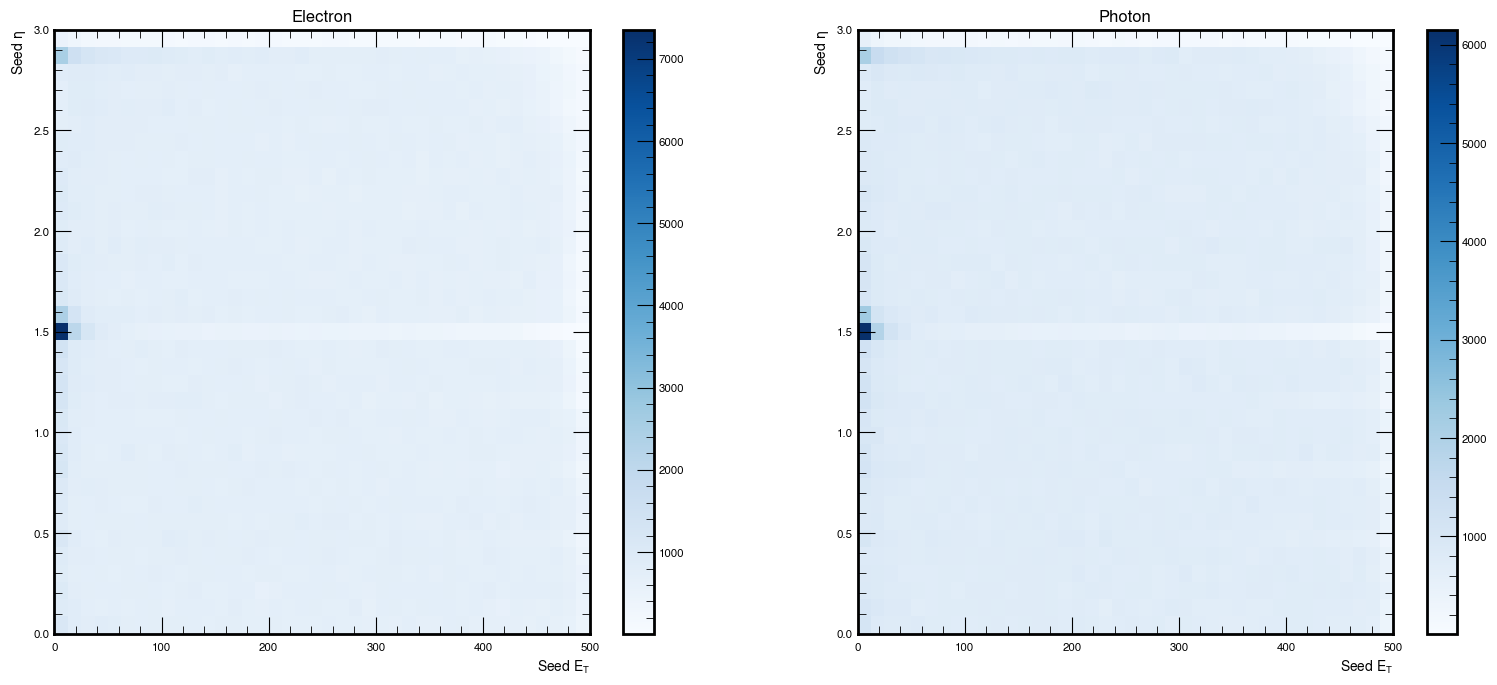

In [27]:
f, (ax,ay) = plt.subplots(1,2,figsize=(19,8), dpi=100)
c, h, b , I =  ax.hist2d(ak.to_numpy(df_ele.seed_features.et_seed),
                         abs(ak.to_numpy(df_ele.seed_features.seed_eta)), 
          range=((0., 500.),(0,3)), bins=(40,35))
ax.set_xlabel("Seed $E_T$")
ax.set_ylabel("Seed $\eta$")
ax.set_title("Electron")
plt.colorbar(I, ax=ax)

c, h, b , I =  ay.hist2d(ak.to_numpy(df_gamma.seed_features.et_seed),
                         abs(ak.to_numpy(df_gamma.seed_features.seed_eta)), 
          range=((0., 500.),(0,3)), bins=(40,35))
ay.set_xlabel("Seed $E_T$")
ay.set_ylabel("Seed $\eta$")
ay.set_title("Photon")
plt.colorbar(I, ax=ay)

f.savefig(output_folder + f"/seed_eta_et_comparison.png")
f.savefig(output_folder + f"/seed_eta_et_comparison.pdf")
f.savefig(output_folder + f"/seed_eta_et_comparison.svg")

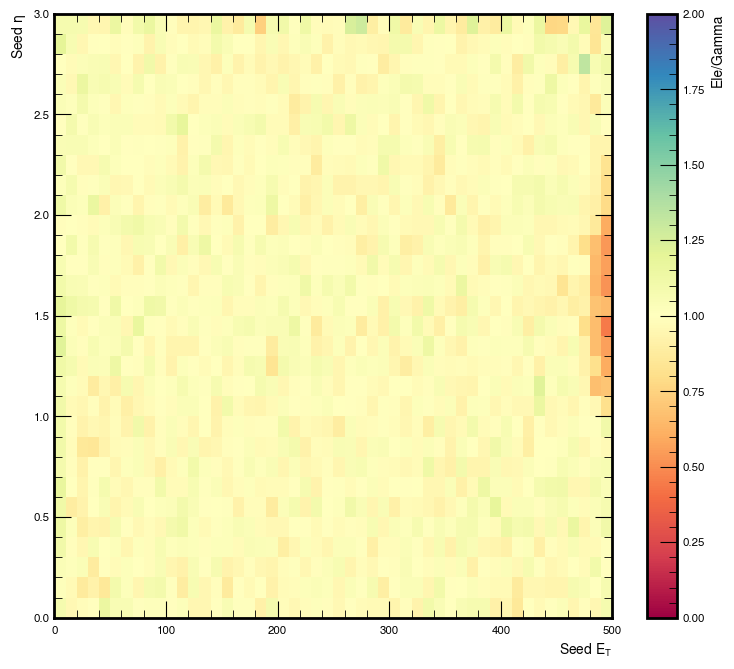

In [28]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)
c_ele, bx, by  = np.histogram2d(ak.to_numpy(df_ele.seed_features.et_seed),
                                abs(ak.to_numpy(df_ele.seed_features.seed_eta)), 
          range=((0., 500.),(0,3)), bins=(50,30))
c_gamma, bx, by  = np.histogram2d(ak.to_numpy(df_gamma.seed_features.et_seed),
                                  abs(ak.to_numpy(df_gamma.seed_features.seed_eta)), 
          range=((0., 500.),(0,3)), bins=(50,30))

r = c_ele / c_gamma

mesh = ax.pcolormesh(bx, by, r.T, cmap="Spectral", vmin=0, vmax=2)

ax.set_xlabel("Seed $E_T$")
ax.set_ylabel("Seed $\eta$")
plt.colorbar(mesh,ax=ax, label="Ele/Gamma")

f.savefig(output_folder + f"/seed_eta_et_comparison_ratio.png")
f.savefig(output_folder + f"/seed_eta_et_comparison_ratio.pdf")
f.savefig(output_folder + f"/seed_eta_et_comparison_ratio.svg")

## Seed $E_T$-$\eta$ flattening

### 1D seed et weighting

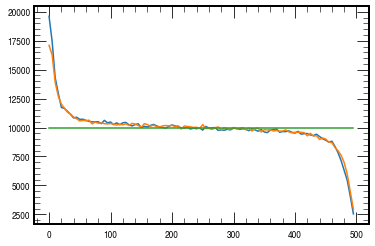

In [29]:
nbins = 100
B_ele, binx = np.histogram(ak.to_numpy(df_ele.seed_features.et_seed), bins=nbins, range=(0.,500.))
B_gamma, binx = np.histogram(ak.to_numpy(df_gamma.seed_features.et_seed), bins=nbins, range=(0.,500.))
A = np.ones(nbins)*np.sum(B_ele)/nbins

plt.plot(binx[:-1], B_ele)
plt.plot(binx[:-1], B_gamma)
plt.plot(binx[:-1],A )

In [30]:
 # Exporting it to correctionlib
import correctionlib, rich
import correctionlib.convert

num = np.stack([A,A], axis=0)
denom = np.stack([B_ele, B_gamma], axis=0)

denom_var= denom
num_var = num

ratio= np.where( (denom>0)&(num>0),
                     num/denom,
                     1.) 
ratio_err =  np.where( (denom>0)&(num>0),
                           np.sqrt((1/denom)**2 * num_var + (num/denom**2)**2 * denom_var),
                           0.)

h_weight = hist.Hist(
            hist.axis.IntCategory([11,22], name="flavour"),
            hist.axis.Variable(binx, name="seed_et"),
            storage="weight",
            data=np.concatenate([ratio[:,:,None], ratio_err[:,:,None]], axis=-1))


# without a name, the resulting object will fail validation
h_weight.name = "flattening_seed_et"
h_weight.label = "weight"
clibcorr = correctionlib.convert.from_histogram(h_weight)
clibcorr.description = "Reweight Seed Et"

# set overflow bins behavior (default is to raise an error when out of bounds)
for flavour_cat in clibcorr.data.content:
    flavour_cat.value.flow = "clamp"
 
cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="Reweight Seed Et",
    corrections=[clibcorr],
)
rich.print(cset)

with open(f"./reweightings/seed_et_flattening_{version}.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))


CorrectionSet (schema v2)
Reweight Seed Et
📂
└── 📈 flattening_seed_et (v0)
    Reweight Seed Et
    Node counts: Category: 1, Binning: 2
    ╭─── ▶ input ────╮ ╭──────────── ▶ input ─────────────╮
    │ flavour (int)  │ │ seed_et (real)                   │
    │ flavour        │ │ seed_et                          │
    │ Values: 11, 22 │ │ Range: [0.0, 500.0), overflow ok │
    ╰────────────────╯ ╰──────────────────────────────────╯
    ╭─── ◀ output ───╮
    │ weight (real)  │
    │ No description │
    ╰────────────────╯

#### Testing the application of the weight

In [31]:
cset = correctionlib.CorrectionSet.from_file(f"./reweightings/seed_et_flattening_{version}.json")
corr_et = cset["flattening_seed_et"]

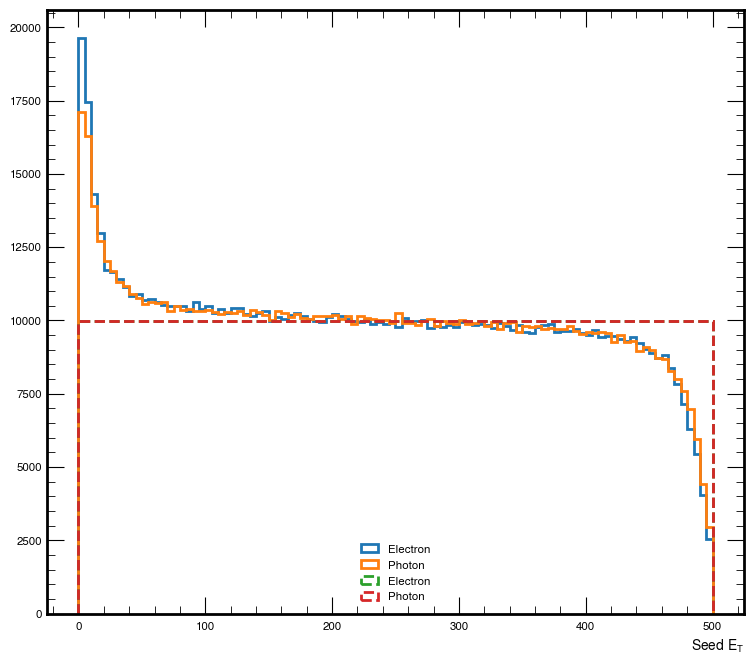

In [32]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)

w_ele = corr_et.evaluate(11,ak.to_numpy(df_ele.seed_features.et_seed) )
w_gamma = corr_et.evaluate(22,ak.to_numpy(df_gamma.seed_features.et_seed) )

ax.hist( ak.to_numpy(df_ele.seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Electron")
ax.hist( ak.to_numpy(df_gamma.seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Photon")
ax.hist( ak.to_numpy(df_ele.seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Electron", weights=w_ele, linestyle="dashed")
ax.hist( ak.to_numpy(df_gamma.seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Photon",weights=w_gamma, linestyle="dashed")
ax.legend(loc="lower center")
ax.set_xlabel("Seed $E_T$")

f.savefig(output_folder + f"/photon_reweight_et.png")
f.savefig(output_folder + f"/photon_reweight_et.pdf")
f.savefig(output_folder + f"/photon_reweight_et.svg")

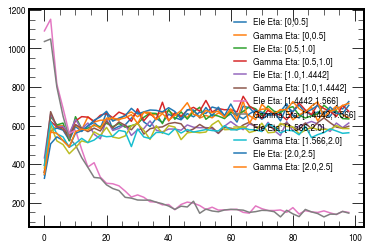

In [33]:
nbins = 50

etas = [0, 0.5,1.0,1.4442, 1.566, 2.,2.5]
w_ele = corr_et.evaluate(11,ak.to_numpy(df_ele.seed_features.et_seed) )
w_gamma = corr_et.evaluate(22,ak.to_numpy(df_gamma.seed_features.et_seed) )


for ieta in range(len(etas)-1):
    mask_ele = (abs(df_ele.seed_features.seed_eta)>=etas[ieta])&(abs(df_ele.seed_features.seed_eta)<etas[ieta+1])
    mask_gamma = (abs(df_gamma.seed_features.seed_eta)>=etas[ieta])&(abs(df_gamma.seed_features.seed_eta)<etas[ieta+1])
    
    B_ele, binx = np.histogram(ak.to_numpy(df_ele[mask_ele].seed_features.et_seed), 
                               bins=nbins, range=(0.,100.), weights=w_ele[mask_ele])
    B_gamma, binx = np.histogram(ak.to_numpy(df_gamma[mask_gamma].seed_features.et_seed),
                                 bins=nbins, range=(0.,100.), weights=w_gamma[mask_gamma])
                                
    A = np.ones(nbins)*np.sum(B_ele)/nbins
    plt.plot(binx[:-1], B_ele,label=f"Ele Eta: [{etas[ieta]},{etas[ieta+1]}]")
    plt.plot(binx[:-1], B_gamma,label=f"Gamma Eta: [{etas[ieta]},{etas[ieta+1]}]")
    plt.legend()

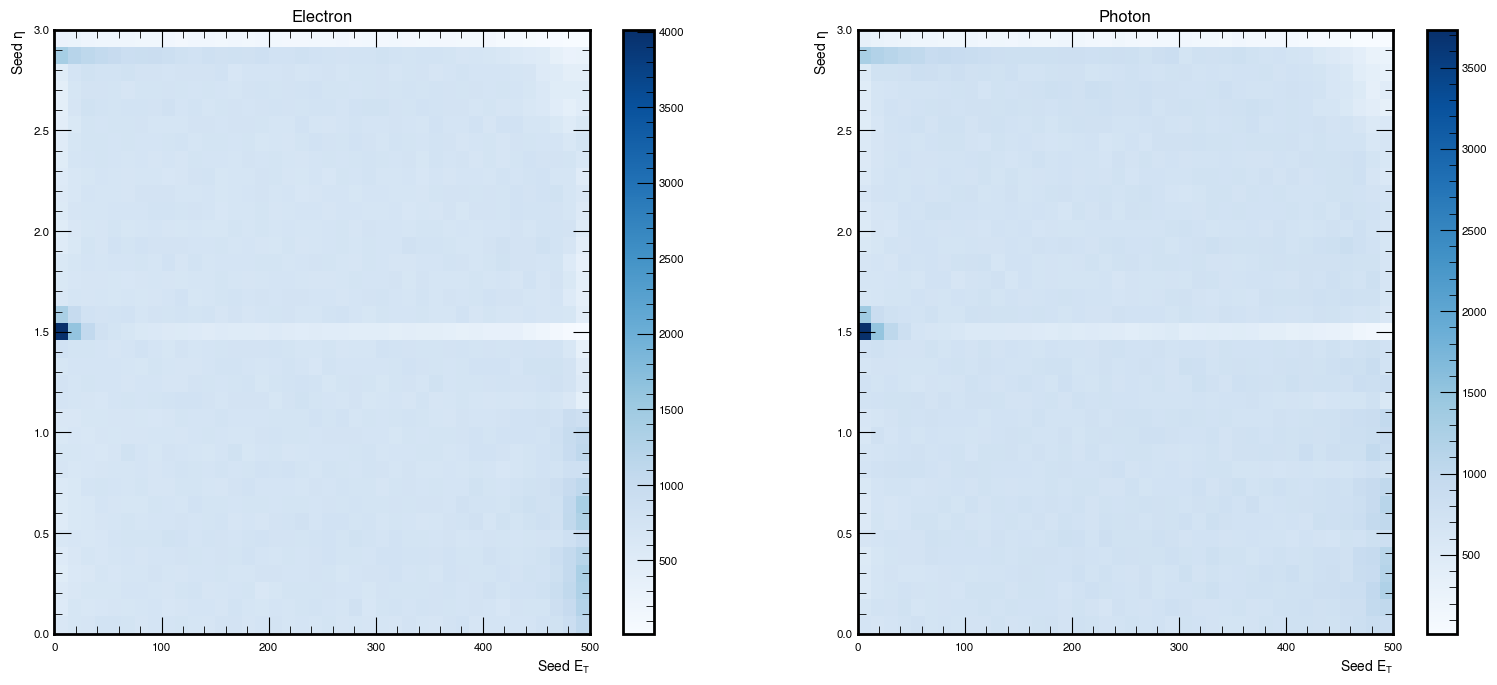

In [34]:
w_ele = corr_et.evaluate(11,ak.to_numpy(df_ele.seed_features.et_seed))
w_gamma = corr_et.evaluate(22,ak.to_numpy(df_gamma.seed_features.et_seed))

f, (ax,ay) = plt.subplots(1,2,figsize=(19,8), dpi=100)
c, h, b , I =  ax.hist2d(ak.to_numpy(df_ele.seed_features.et_seed),
                         abs(ak.to_numpy(df_ele.seed_features.seed_eta)),
                          range=((0., 500.),(0,3)), bins=(40,35),
                        weights=w_ele)
ax.set_xlabel("Seed $E_T$")
ax.set_ylabel("Seed $\eta$")
ax.set_title("Electron")
plt.colorbar(I, ax=ax)

c, h, b , I =  ay.hist2d(ak.to_numpy(df_gamma.seed_features.et_seed),
                         abs(ak.to_numpy(df_gamma.seed_features.seed_eta)), 
                          range=((0., 500.),(0,3)), bins=(40,35),
                         weights=w_gamma)
ay.set_xlabel("Seed $E_T$")
ay.set_ylabel("Seed $\eta$")
ay.set_title("Photon")
plt.colorbar(I, ax=ay)

f.savefig(output_folder + f"/seed_eta_et_comparison_weighted_onlyet.png")
f.savefig(output_folder + f"/seed_eta_et_comparison_weighted_onlyet.pdf")
f.savefig(output_folder + f"/seed_eta_et_comparison_weighted_onlyet.svg")

### 2D binning weighting seed eta, seed_et

Let's plot the distribution of seed $E_T$ by difference seed $\eta$ bins

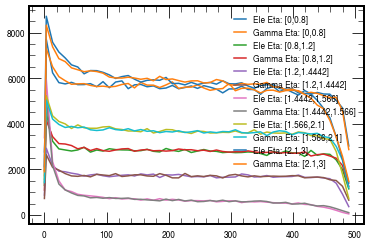

In [36]:
bins_et = np.concatenate([[0],np.linspace(3.,500, 50)])

etas = [0, 0.8, 1.2, 1.4442, 1.566, 2.1, 3]

for ieta in range(len(etas)-1):
    mask_ele = (abs(df_ele.seed_features.seed_eta)>=etas[ieta])&(abs(df_ele.seed_features.seed_eta)<etas[ieta+1])
    mask_gamma = (abs(df_gamma.seed_features.seed_eta)>=etas[ieta])&(abs(df_gamma.seed_features.seed_eta)<etas[ieta+1])
    
    B_ele, binx = np.histogram(ak.to_numpy(df_ele[mask_ele].seed_features.et_seed), 
                               bins=bins_et, range=(0.,500.))
    B_gamma, binx = np.histogram(ak.to_numpy(df_gamma[mask_gamma].seed_features.et_seed),
                                 bins=bins_et, range=(0.,500.))
                                
    A = np.ones(nbins)*np.sum(B_ele)/nbins
    plt.plot(binx[:-1], B_ele,label=f"Ele Eta: [{etas[ieta]},{etas[ieta+1]}]")
    plt.plot(binx[:-1], B_gamma,label=f"Gamma Eta: [{etas[ieta]},{etas[ieta+1]}]")
    plt.legend()

We want to normalize the margin distribution of `seed_et` in each seed eta bin. 
The overall `seed_eta` normalization must not change --> we apply a renormalization after the ratio has been computed and clipped

In [37]:
 # Exporting it to correctionlib
import correctionlib, rich
import correctionlib.convert

bins_x = np.concatenate([np.array([0.,1.,2.,3.]), np.linspace(4.,500,40)] )
#bins_x = np.linspace(0.,100,60)
bins_eta = [0, 0.6, 1.2, 1.4442, 1.566, 2.1, 3]

B_ele, binx, biny = np.histogram2d(ak.to_numpy(df_ele.seed_features.et_seed), 
                             ak.to_numpy(abs(df_ele.seed_features.seed_eta)),
                               bins=[bins_et, bins_eta])
B_gamma, binx,_ = np.histogram2d(ak.to_numpy(df_gamma.seed_features.et_seed), 
                             ak.to_numpy(abs(df_gamma.seed_features.seed_eta)),
                                bins=[bins_et, bins_eta])

width_et = (binx - np.roll(binx, 1))[1:]
# density_ele = np.sum(B_ele*width_et[:,None], axis=0)/np.sum(width_et)
# density_gamma = np.sum(B_gamma*width_et[:,None], axis=0)/np.sum(width_et)

# I want to profile on the eta direction and reweight the margin distribution of et 
# in different eta categories
A_ele = np.ones((len(bins_et)-1, len(bins_eta)-1)) * width_et[:,None] * np.sum(B_ele, axis=0)/np.sum(width_et)
A_gamma = np.ones((len(bins_et)-1, len(bins_eta)-1)) * width_et[:,None] * np.sum(B_gamma, axis=0)/np.sum(width_et)

num = np.stack([A_ele,A_gamma], axis=0)
denom = np.stack([B_ele, B_gamma], axis=0)

denom_var= denom
num_var = num

ratio= np.where( (denom>0)&(num>0),
                     num/denom,
                     1.) 

ratio_err =  np.where( (denom>0)&(num>0),
                           np.sqrt((1/denom)**2 * num_var + (num/denom**2)**2 * denom_var),
                           0.)

# Remove the ration from crack bin
ratio[:,:,3] = 1
# Clipping the ratio
ratio[ratio>2] = 2

# Correct normalization in each eta slice
norm_factor = np.sum(denom, axis=1) / np.sum(ratio*denom, axis=1)
norm_factor = np.transpose(norm_factor[:,:,None], axes=(0,2,1))
ratio = ratio*norm_factor

# f, ax, = plt.subplots(1,figsize=(12,8), dpi=100)
# mesh = ax.pcolormesh(binx, biny, ratio.T, cmap="Spectral", vmin=0.5, vmax=1.5)

h_weight = hist.Hist(
            hist.axis.IntCategory([11,22], name="flavour"),
            hist.axis.Variable(bins_et, name="seed_et"),
            hist.axis.Variable(bins_eta, name="seed_eta"),
            storage="weight",
            data=np.concatenate([ratio[:,:,:,None], ratio_err[:,:,:,None]], axis=-1))


# without a name, the resulting object will fail validation
h_weight.name = "flattening_seed_et_eta"
h_weight.label = "weight"
clibcorr_seed = correctionlib.convert.from_histogram(h_weight)
clibcorr_seed.description = "Reweight Seed Et - Eta"

# set overflow bins behavior (default is to raise an error when out of bounds)
for flavour_cat in clibcorr_seed.data.content:
    flavour_cat.value.flow = "clamp"
 
cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="Reweight Seed Et - Eta",
    corrections=[clibcorr_seed],
)
rich.print(cset)

with open(f"./reweightings/seed_et_eta_flattening_{version}.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))


CorrectionSet (schema v2)
Reweight Seed Et - Eta
📂
└── 📈 flattening_seed_et_eta (v0)
    Reweight Seed Et - Eta
    Node counts: Category: 1, MultiBinning: 2
    ╭─── ▶ input ────╮ ╭──────────── ▶ input ─────────────╮ ╭─────────── ▶ input ────────────╮
    │ flavour (int)  │ │ seed_et (real)                   │ │ seed_eta (real)                │
    │ flavour        │ │ seed_et                          │ │ seed_eta                       │
    │ Values: 11, 22 │ │ Range: [0.0, 500.0), overflow ok │ │ Range: [0.0, 3.0), overflow ok │
    ╰────────────────╯ ╰──────────────────────────────────╯ ╰────────────────────────────────╯
    ╭─── ◀ output ───╮
    │ weight (real)  │
    │ No description │
    ╰────────────────╯

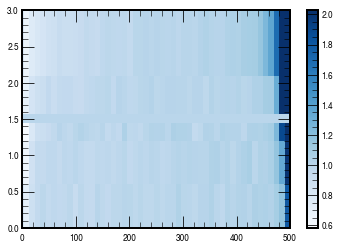

In [38]:
mesh = plt.pcolormesh(binx, biny, ratio[0,:,:].T, cmap="Blues")
plt.colorbar()

#### Testing the weight

In [39]:
cset = correctionlib.CorrectionSet.from_file(f"./reweightings/seed_et_eta_flattening_{version}.json")
corr_et_eta = cset["flattening_seed_et_eta"]

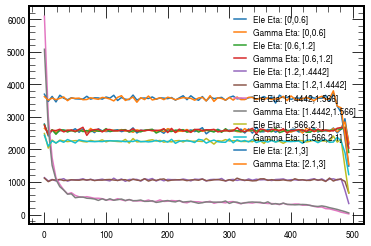

In [40]:
w_ele = corr_et_eta.evaluate(11,ak.to_numpy(df_ele.seed_features.et_seed),  
                         ak.to_numpy(abs(df_ele.seed_features.seed_eta)))
w_gamma = corr_et_eta.evaluate(22,ak.to_numpy(df_gamma.seed_features.et_seed), 
                           ak.to_numpy(abs(df_gamma.seed_features.seed_eta)) )

etas= [0, 0.6, 1.2, 1.4442, 1.566, 2.1, 3]

for ieta in range(len(etas)-1):
    mask_ele = (abs(df_ele.seed_features.seed_eta)>=etas[ieta])&(abs(df_ele.seed_features.seed_eta)<etas[ieta+1])
    mask_gamma = (abs(df_gamma.seed_features.seed_eta)>=etas[ieta])&(abs(df_gamma.seed_features.seed_eta)<etas[ieta+1])
    
    B_ele, binx = np.histogram(ak.to_numpy(df_ele[mask_ele].seed_features.et_seed), 
                               bins=80, range=(0.,500.), weights=w_ele[mask_ele])
    B_gamma, binx = np.histogram(ak.to_numpy(df_gamma[mask_gamma].seed_features.et_seed),
                                 bins=80, range=(0.,500.), weights=w_gamma[mask_gamma])
                                
    A = np.ones(nbins)*np.sum(B_ele)/nbins
    plt.plot(binx[:-1], B_ele,label=f"Ele Eta: [{etas[ieta]},{etas[ieta+1]}]")
    plt.plot(binx[:-1], B_gamma,label=f"Gamma Eta: [{etas[ieta]},{etas[ieta+1]}]")
    plt.legend()

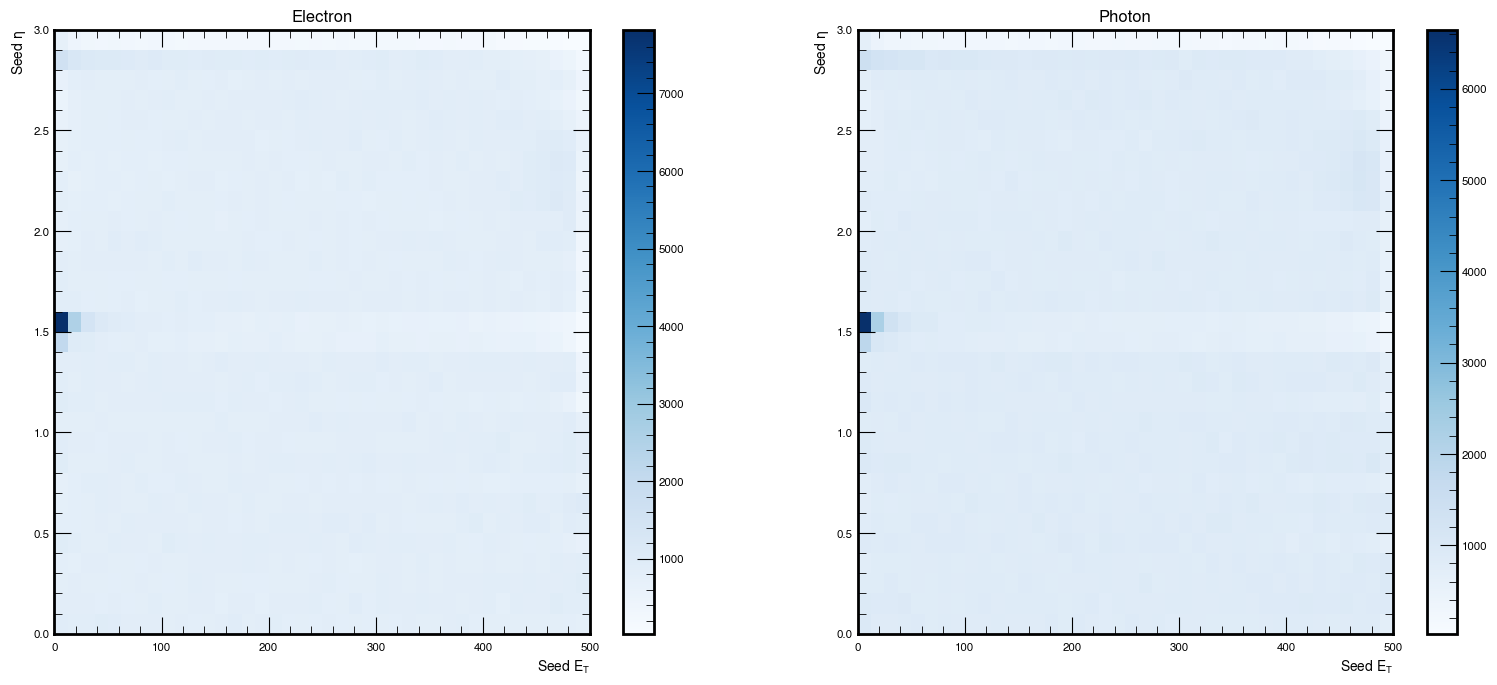

In [41]:
w_ele = corr_et_eta.evaluate(11,ak.to_numpy(df_ele.seed_features.et_seed),  
                         ak.to_numpy(abs(df_ele.seed_features.seed_eta)))
w_gamma = corr_et_eta.evaluate(22,ak.to_numpy(df_gamma.seed_features.et_seed), 
                           ak.to_numpy(abs(df_gamma.seed_features.seed_eta)) )

etabins =  np.concatenate([np.linspace(0., 1.4442,15), np.linspace(1.566, 3, 15)])

f, (ax,ay) = plt.subplots(1,2,figsize=(19,8), dpi=100)
c, h, b , I =  ax.hist2d(ak.to_numpy(df_ele.seed_features.et_seed),
                         abs(ak.to_numpy(df_ele.seed_features.seed_eta)), 
          range=((0., 500.),(0,3)), bins=(40,30),
                        weights=w_ele)
ax.set_xlabel("Seed $E_T$")
ax.set_ylabel("Seed $\eta$")
ax.set_title("Electron")
plt.colorbar(I, ax=ax)

c, h, b , I =  ay.hist2d(ak.to_numpy(df_gamma.seed_features.et_seed),
                         abs(ak.to_numpy(df_gamma.seed_features.seed_eta)), 
          range=((0., 500.),(0,3)), bins=(40,30),
                         weights=w_gamma)
ay.set_xlabel("Seed $E_T$")
ay.set_ylabel("Seed $\eta$")
ay.set_title("Photon")
plt.colorbar(I, ax=ay)

f.savefig(output_folder + f"/seed_eta_et_comparison_weighted_eteta.png")
f.savefig(output_folder + f"/seed_eta_et_comparison_weighted_eteta.pdf")
f.savefig(output_folder + f"/seed_eta_et_comparison_weighted_eteta.svg")

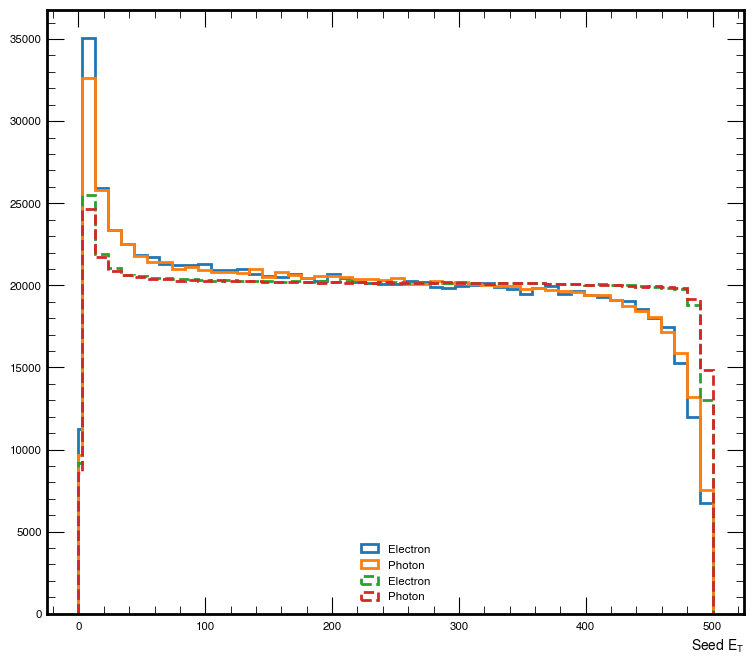

In [42]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)

w_ele = corr_et_eta.evaluate(11,ak.to_numpy(df_ele.seed_features.et_seed),  
                         ak.to_numpy(abs(df_ele.seed_features.seed_eta)))
w_gamma = corr_et_eta.evaluate(22,ak.to_numpy(df_gamma.seed_features.et_seed), 
                           ak.to_numpy(abs(df_gamma.seed_features.seed_eta)) )

binx = bins_et
ax.hist( ak.to_numpy(df_ele.seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Electron")
ax.hist( ak.to_numpy(df_gamma.seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Photon")
ax.hist( ak.to_numpy(df_ele.seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Electron", weights=w_ele, linestyle="dashed")
ax.hist( ak.to_numpy(df_gamma.seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Photon",weights=w_gamma, linestyle="dashed")
ax.legend(loc="lower center")
ax.set_xlabel("Seed $E_T$")

f.savefig(output_folder + f"/seed_et_reweight_eteta.png")
f.savefig(output_folder + f"/seed_et_reweight_eteta.pdf")
f.savefig(output_folder + f"/seed_et_reweight_eteta.svg")

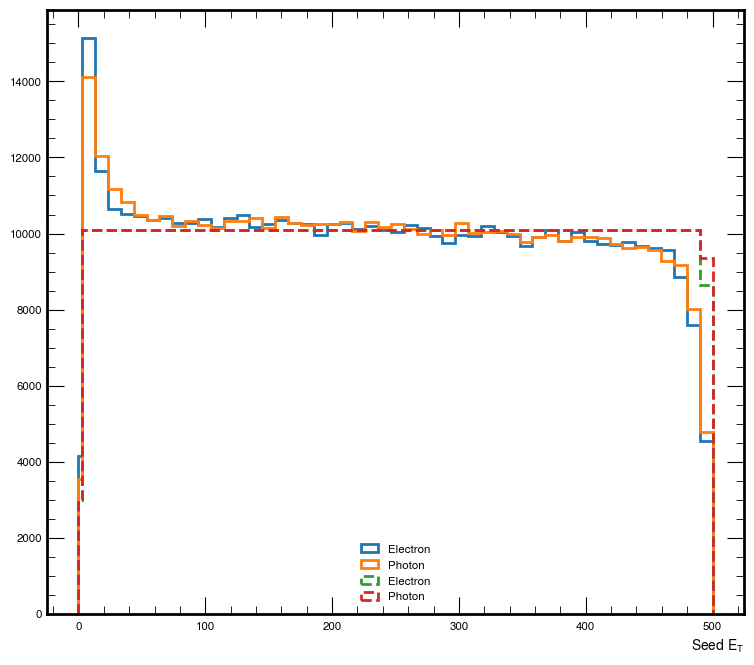

In [43]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)

mask_ele =  (ele_seed_eta<1.4442)
mask_gamma =  (gam_seed_eta<1.4442)

w_ele = corr_et_eta.evaluate(11,ak.to_numpy(df_ele[mask_ele].seed_features.et_seed),  
                         ak.to_numpy(abs(df_ele[mask_ele].seed_features.seed_eta)))
w_gamma = corr_et_eta.evaluate(22,ak.to_numpy(df_gamma[mask_gamma].seed_features.et_seed), 
                           ak.to_numpy(abs(df_gamma[mask_gamma].seed_features.seed_eta)) )

binx = bins_et
ax.hist( ak.to_numpy(df_ele[mask_ele].seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Electron")
ax.hist( ak.to_numpy(df_gamma[mask_gamma].seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Photon")
ax.hist( ak.to_numpy(df_ele[mask_ele].seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Electron", weights=w_ele, linestyle="dashed")
ax.hist( ak.to_numpy(df_gamma[mask_gamma].seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Photon",weights=w_gamma, linestyle="dashed")
ax.legend(loc="lower center")
ax.set_xlabel("Seed $E_T$")

f.savefig(output_folder + f"/seed_et_reweight_eteta_EB.png")
f.savefig(output_folder + f"/seed_et_reweight_eteta_EB.pdf")
f.savefig(output_folder + f"/seed_et_reweight_eteta_EB.svg")

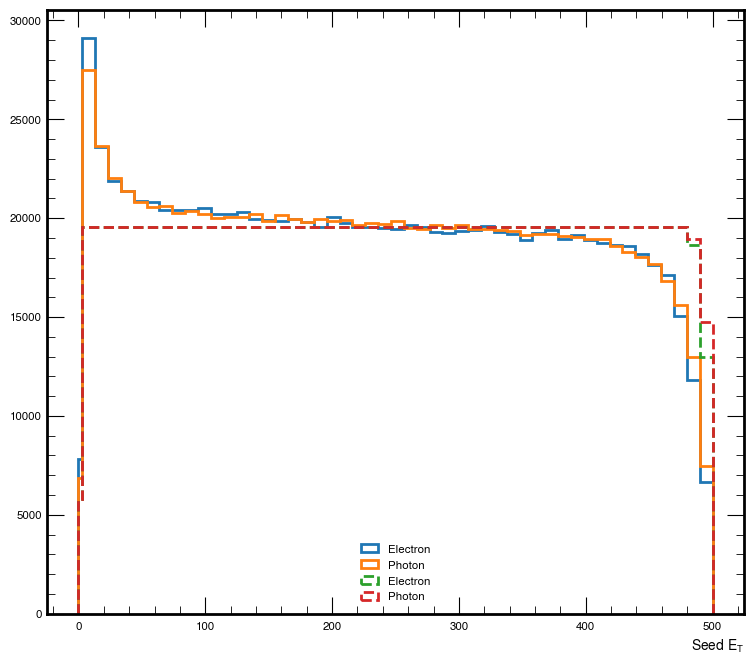

In [44]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)

mask_ele =  (ele_seed_eta<1.4442)|(ele_seed_eta>1.566)
mask_gamma =  (gam_seed_eta<1.4442)|(gam_seed_eta>1.566)

w_ele = corr_et_eta.evaluate(11,ak.to_numpy(df_ele[mask_ele].seed_features.et_seed),  
                         ak.to_numpy(abs(df_ele[mask_ele].seed_features.seed_eta)))
w_gamma = corr_et_eta.evaluate(22,ak.to_numpy(df_gamma[mask_gamma].seed_features.et_seed), 
                           ak.to_numpy(abs(df_gamma[mask_gamma].seed_features.seed_eta)) )

binx = bins_et
ax.hist( ak.to_numpy(df_ele[mask_ele].seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Electron")
ax.hist( ak.to_numpy(df_gamma[mask_gamma].seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Photon")
ax.hist( ak.to_numpy(df_ele[mask_ele].seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Electron", weights=w_ele, linestyle="dashed")
ax.hist( ak.to_numpy(df_gamma[mask_gamma].seed_features.et_seed), bins=binx,linewidth=2,
         histtype="step", label="Photon",weights=w_gamma, linestyle="dashed")
ax.legend(loc="lower center")
ax.set_xlabel("Seed $E_T$")

f.savefig(output_folder + f"/seed_et_reweight_eteta_maskcrack.png")
f.savefig(output_folder + f"/seed_et_reweight_eteta_maskcrack.pdf")
f.savefig(output_folder + f"/seed_et_reweight_eteta_maskcrack.svg")

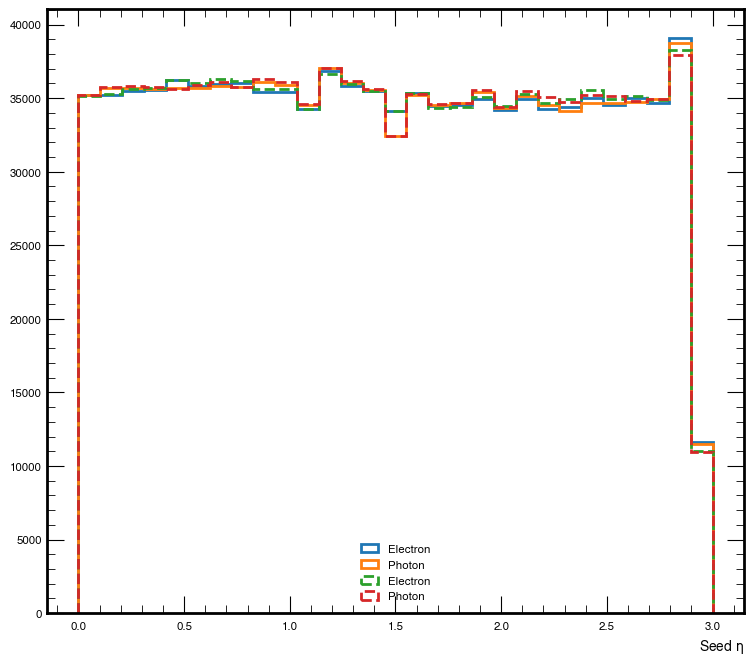

In [45]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)

w_ele = corr_et_eta.evaluate(11,ak.to_numpy(df_ele.seed_features.et_seed),  
                         ak.to_numpy(abs(df_ele.seed_features.seed_eta))) 
w_gamma = corr_et_eta.evaluate(22,ak.to_numpy(df_gamma.seed_features.et_seed), 
                           ak.to_numpy(abs(df_gamma.seed_features.seed_eta)) )

binx = np.linspace(0.,3.,30)
ax.hist( ele_seed_eta, bins=binx,linewidth=2,
         histtype="step", label="Electron")
ax.hist( gam_seed_eta, bins=binx,linewidth=2,
         histtype="step", label="Photon")
ax.hist( ele_seed_eta, bins=binx,linewidth=2,
         histtype="step", label="Electron", weights=w_ele, linestyle="dashed")
ax.hist( gam_seed_eta, bins=binx,linewidth=2,
         histtype="step", label="Photon",weights=w_gamma, linestyle="dashed")
ax.legend(loc="lower center")
ax.set_xlabel("Seed $\eta$")

f.savefig(output_folder + f"/seed_eta_reweight_eteta.png")
f.savefig(output_folder + f"/seed_eta_reweight_eteta.pdf")
f.savefig(output_folder + f"/seed_eta_reweight_eteta.svg")

In [46]:
np.sum(w_ele)

1002385.2260684151

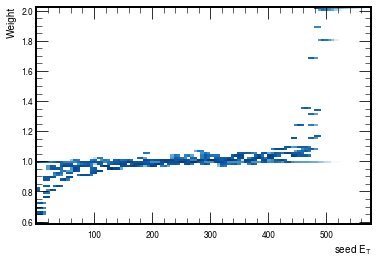

In [47]:
plt.hist2d(ele_seed_et, w_ele, bins=100, norm=LogNorm())
plt.xlabel("seed $E_T$")
plt.ylabel("Weight")
plt.savefig(output_folder + f"/seed_flattening_weight.png")
plt.savefig(output_folder + f"/seed_flattening_weight.pdf")
plt.savefig(output_folder + f"/seed_flattening_weight.svg")

Text(0, 1, 'Weight')

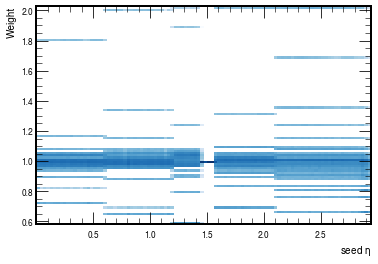

In [48]:
plt.hist2d(ele_seed_eta, w_ele, bins=100, norm=LogNorm())
plt.xlabel("seed $\eta$")
plt.ylabel("Weight")

# Electron / photons comparison in the training dataset

In [49]:
def plot_comparison(dfA,dfB, var, label, bins, xrange, output_folder, ylog=False, wA=None, wB=None):
    os.makedirs(output_folder, exist_ok=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2,1, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)
    
    ax =  axs[0]
    axr =  axs[1]
    
    A, binX, _ = ax.hist(ak.to_numpy(dfA[var]), bins=bins, range=xrange, 
                         label="Electron", histtype="step", linewidth=2, weights=wA)
    B, binX, _ = ax.hist(ak.to_numpy(dfB[var]), bins=bins, range=xrange, 
                         label="Photon", histtype="step", linewidth=2, weights=wB)

    ax.legend()
    axr.set_xlabel(label)
    hep.cms.label(rlabel="14 TeV", loc=0, ax=ax)
    mmax = max([max(A), max(B)])
    if ylog:
        ax.set_ylim(max([min(A), min(B),1e-3]), mmax*500)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)

    errA = np.sqrt(A)
    errB = np.sqrt(B)
    errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)

    axr.errorbar(binX[:-1], A/B, xerr=0, yerr=errR,
                                fmt=".", linestyle='none', elinewidth=1, c="black")

    deltaM = np.max(np.abs((A/B)-1))
    if np.isnan(deltaM):
        deltaM = 2

    axr.set_ylim(max(0, 1-deltaM*1.2), (1+deltaM)*1.1)
    axr.set_ylabel("D/M")
    axr.grid(which="both",axis="y")
    axr.plot([binX[0], binX[-2]], [1.,1.], linewidth=2, c="black")


    fig.savefig(output_folder + f"/{var}_comparison.png")
    fig.savefig(output_folder + f"/{var}_comparison.pdf")
    fig.savefig(output_folder + f"/{var}_comparison.svg")
    


## Electron and photons variables

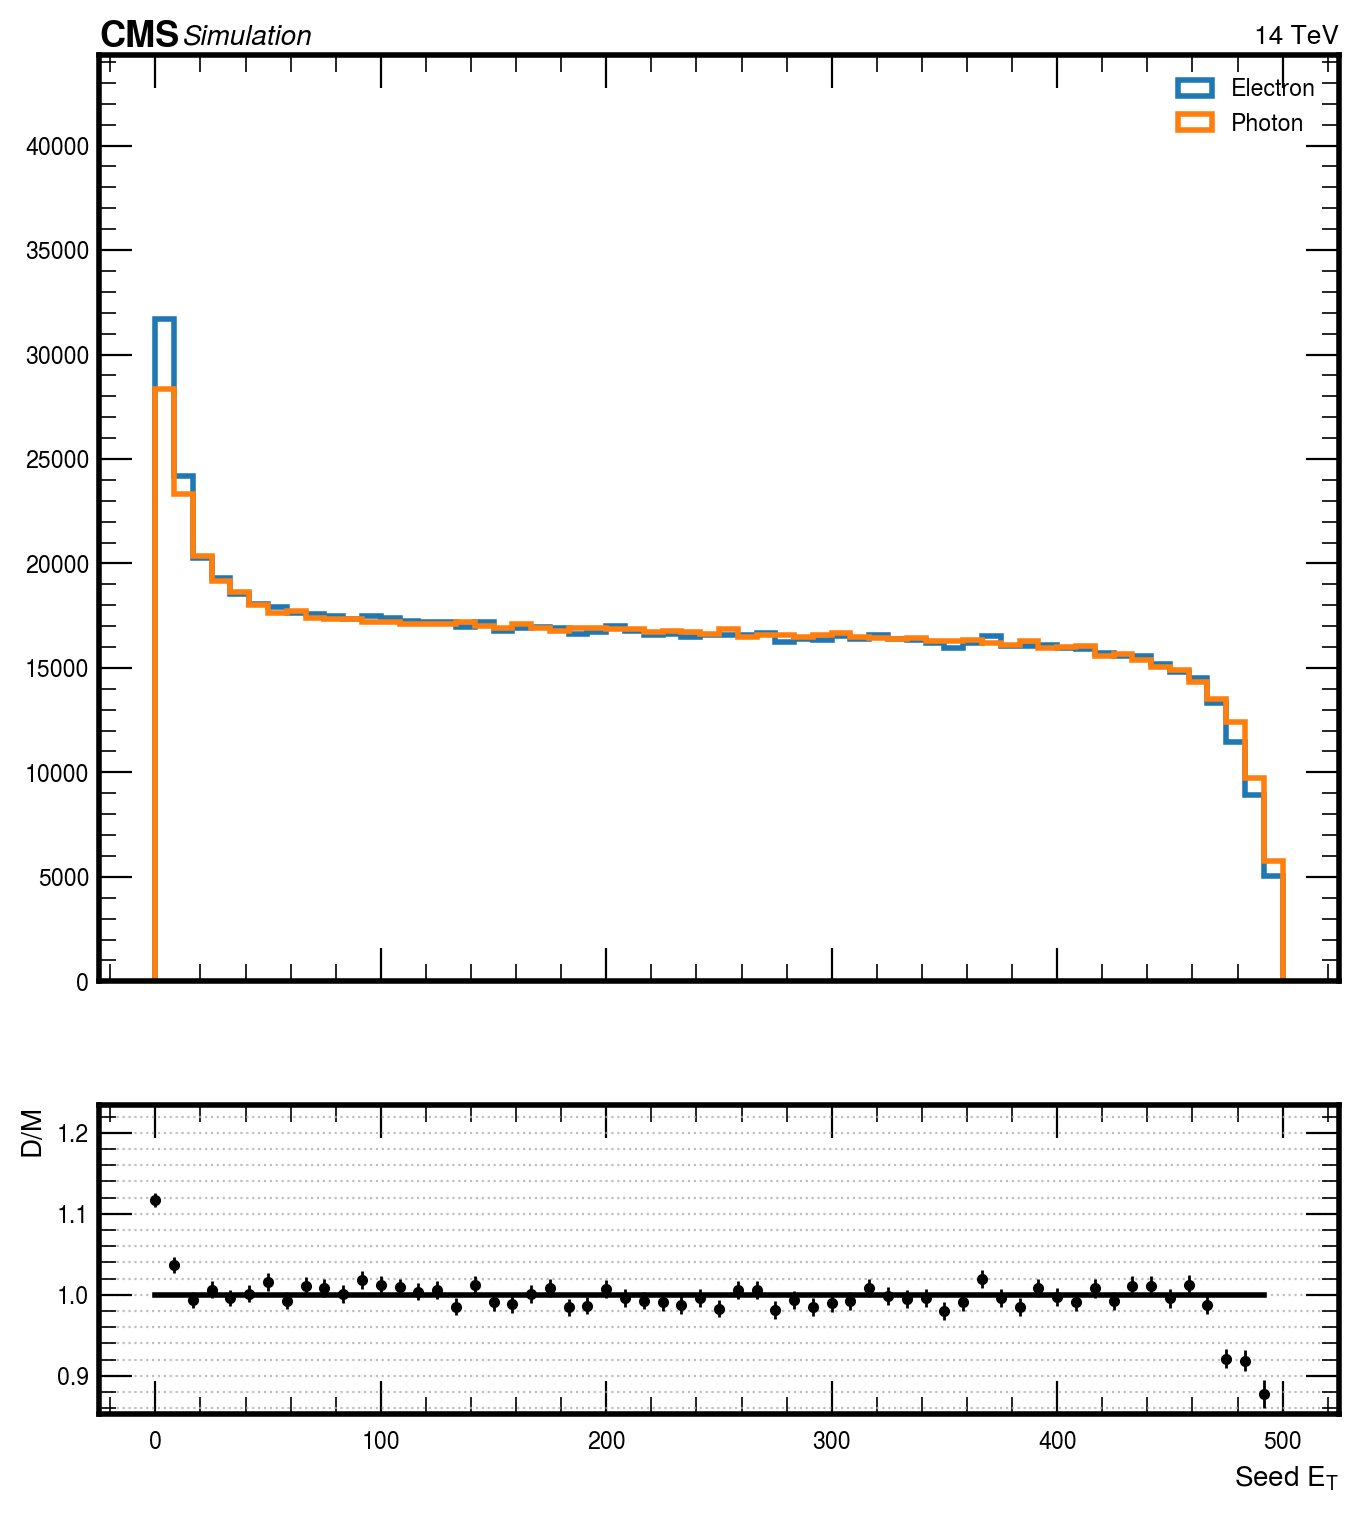

In [52]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="et_seed", label="Seed $E_T$", bins=60, xrange=(0, 500),
                output_folder = output_folder + "/plots_check_input")

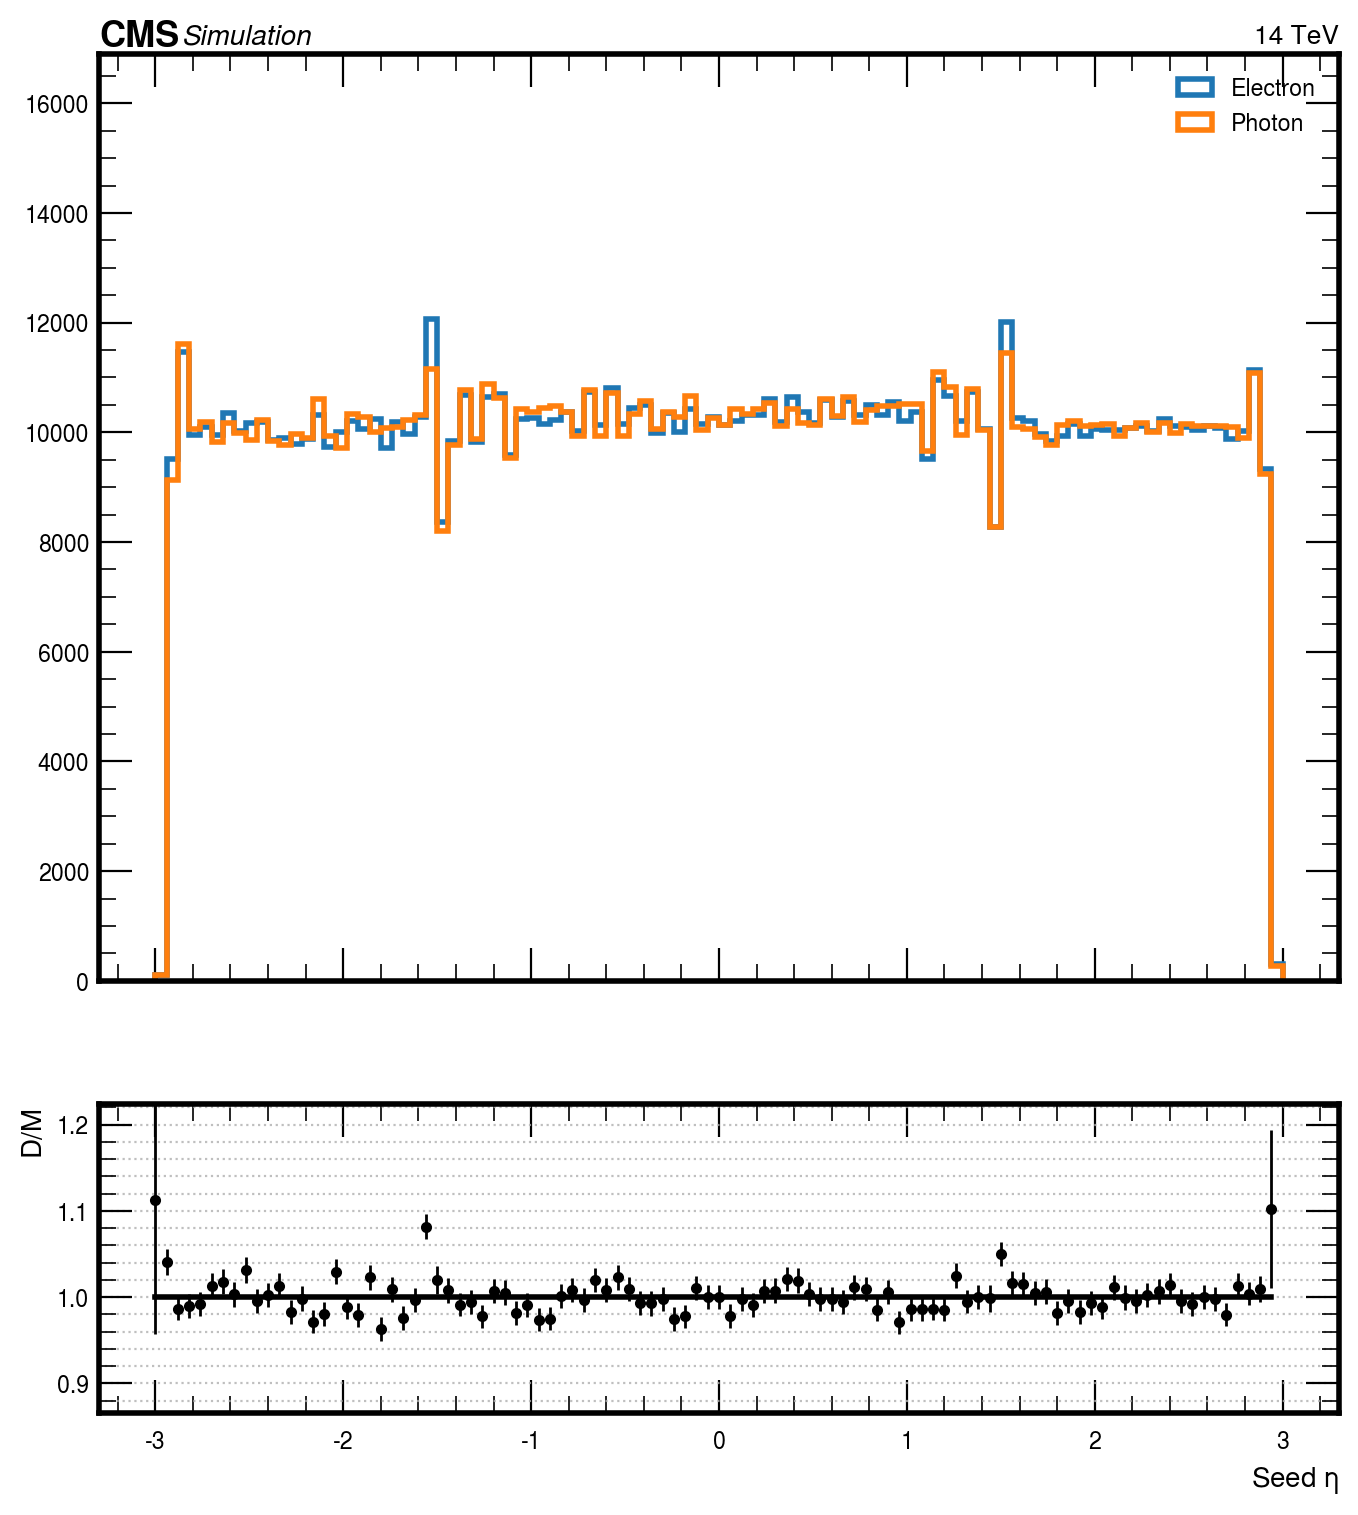

In [53]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="seed_eta", label="Seed $\eta$", bins=100, xrange=(-3, 3),
                output_folder= output_folder + "/plots_check_input")

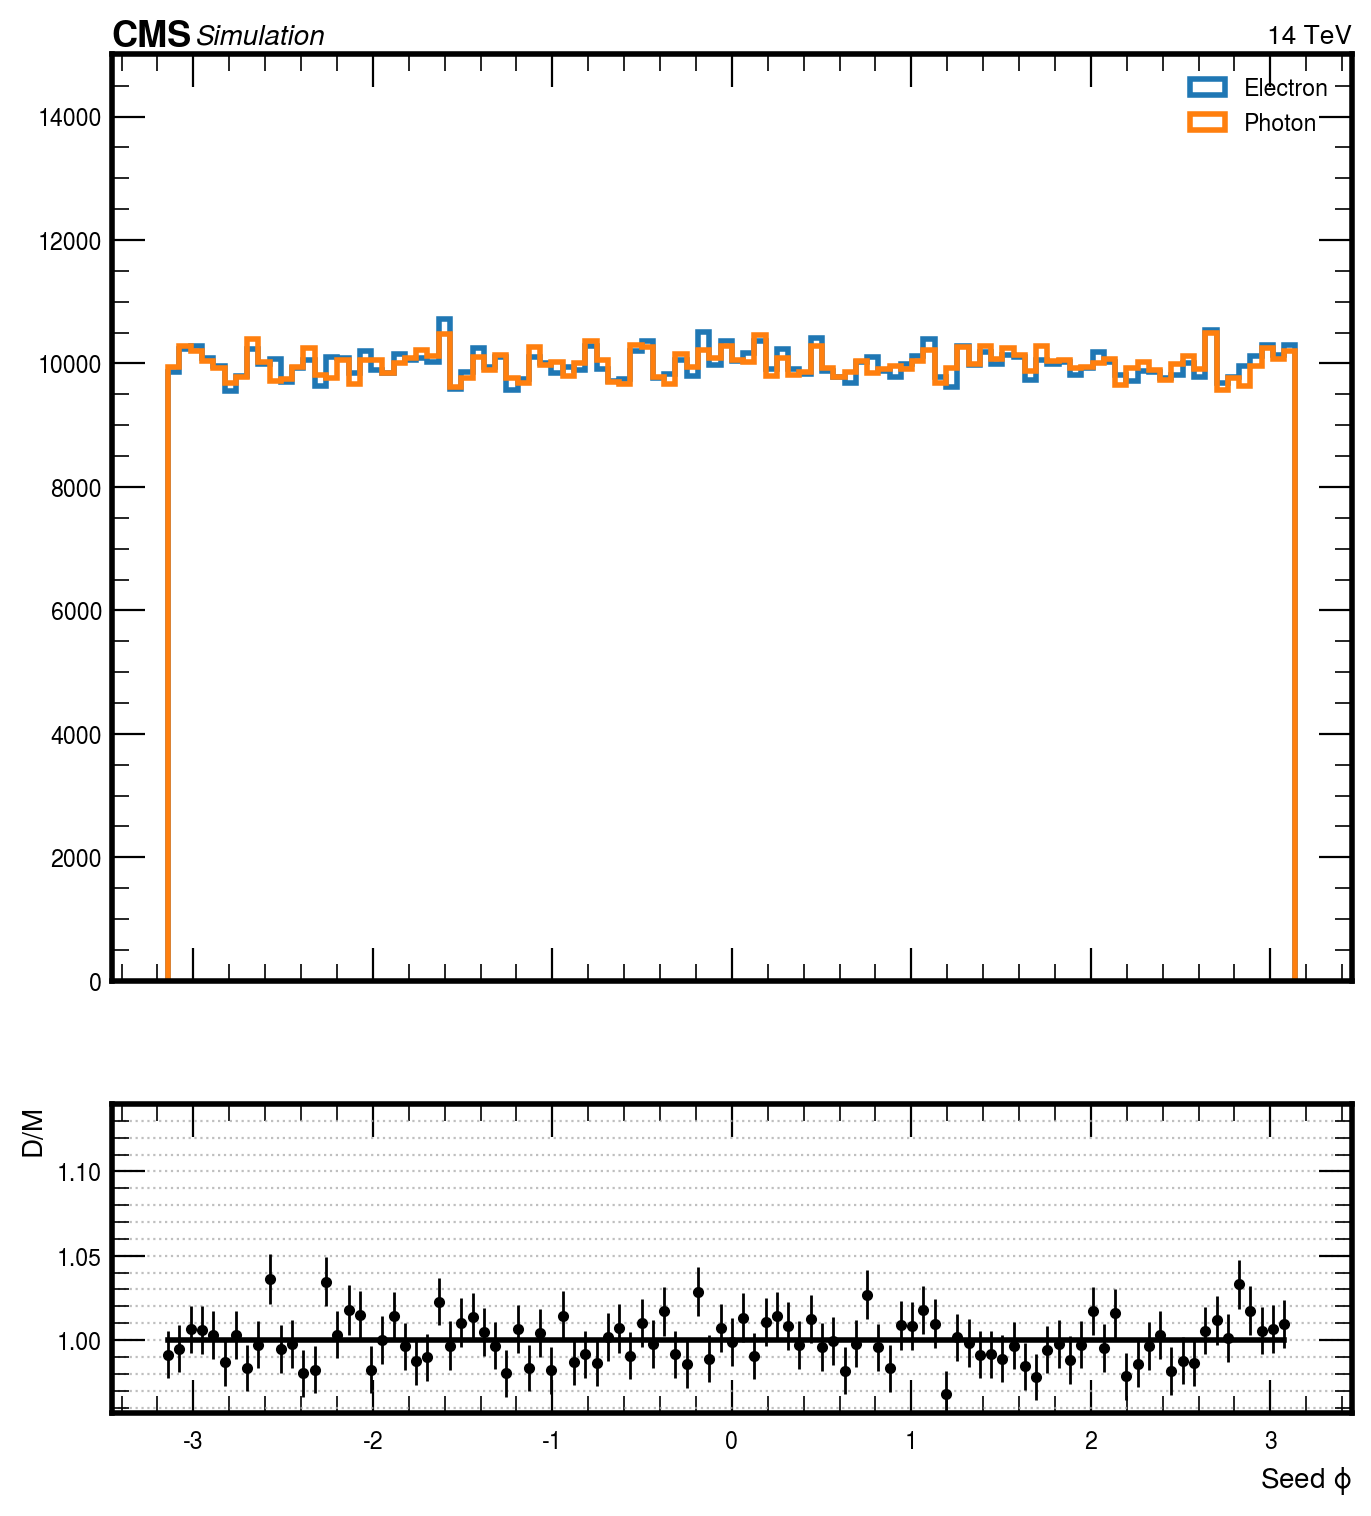

In [54]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="seed_phi", label="Seed $\phi$", bins=100, xrange=(-3.14, 3.14),
                output_folder= output_folder + "/plots_check_input")

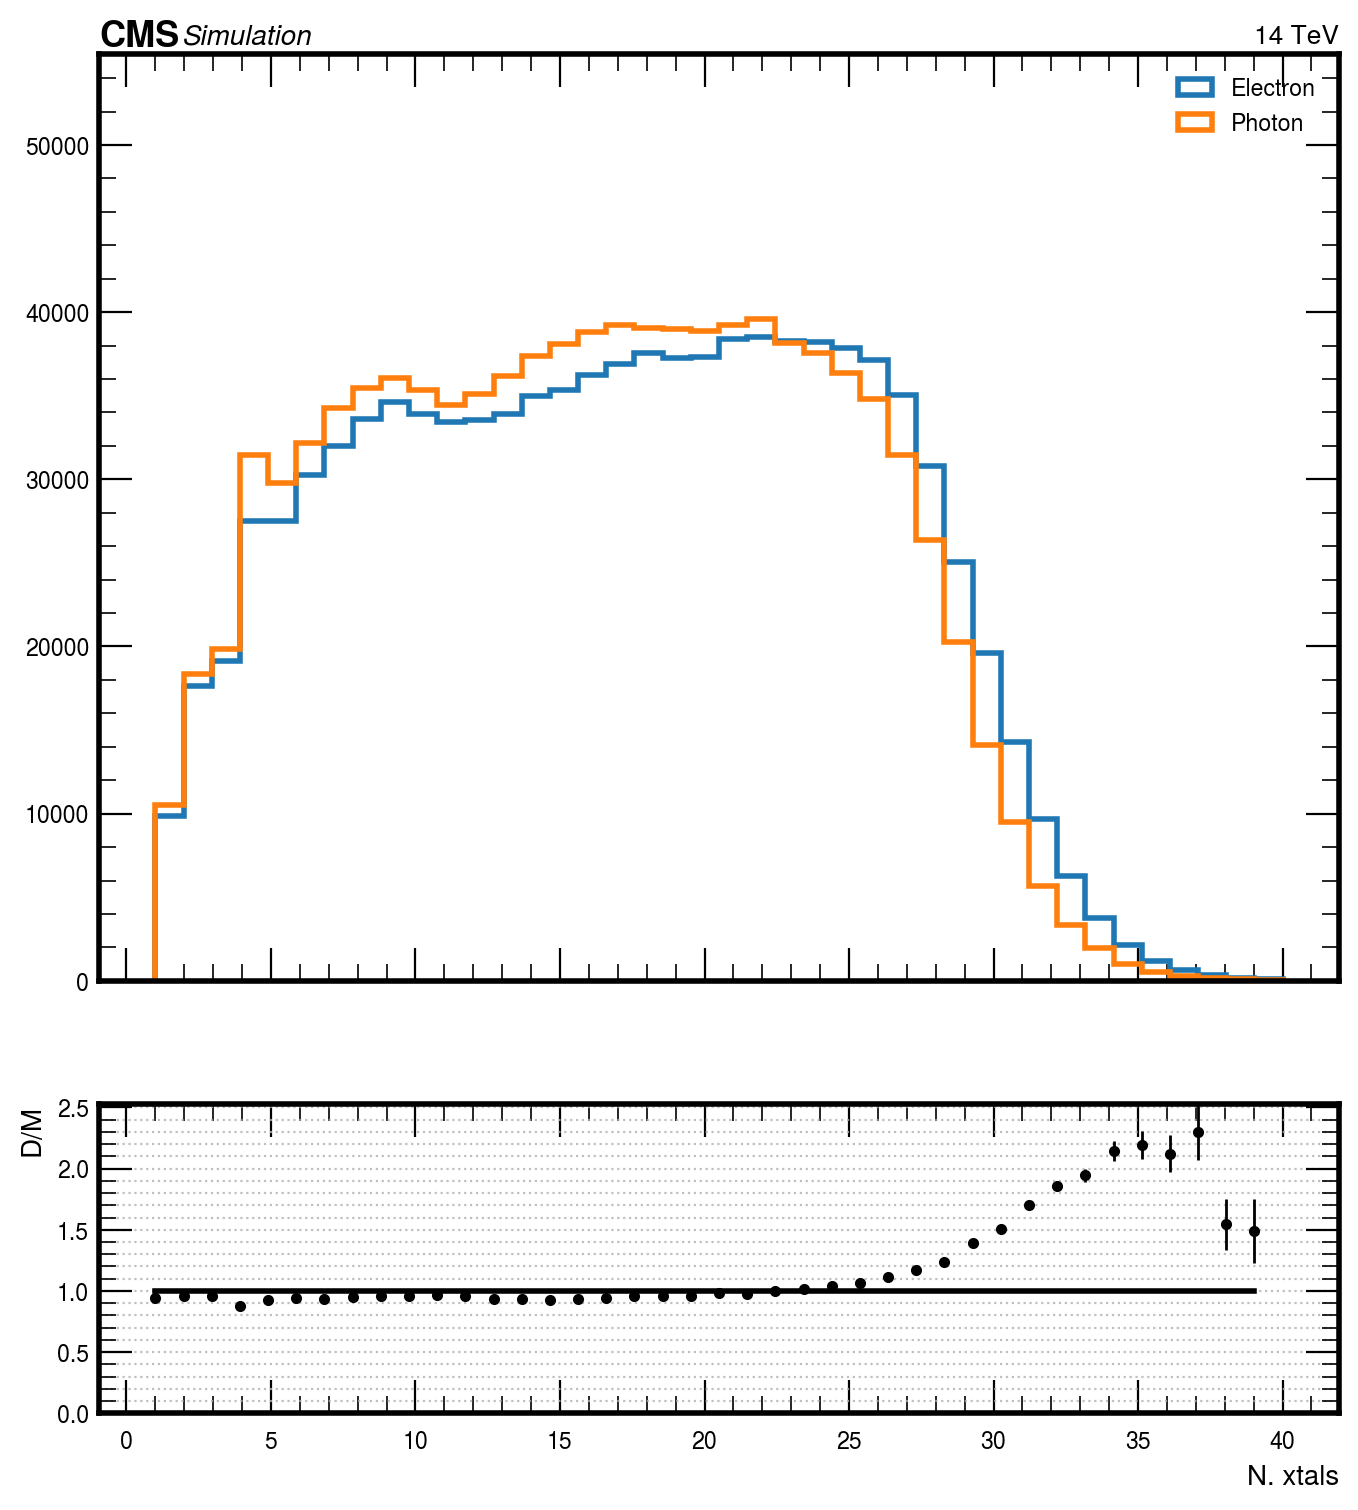

In [55]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="seed_nxtals", label="N. xtals", bins=40, xrange=(1, 40),
                output_folder= output_folder + "/plots_check_input")

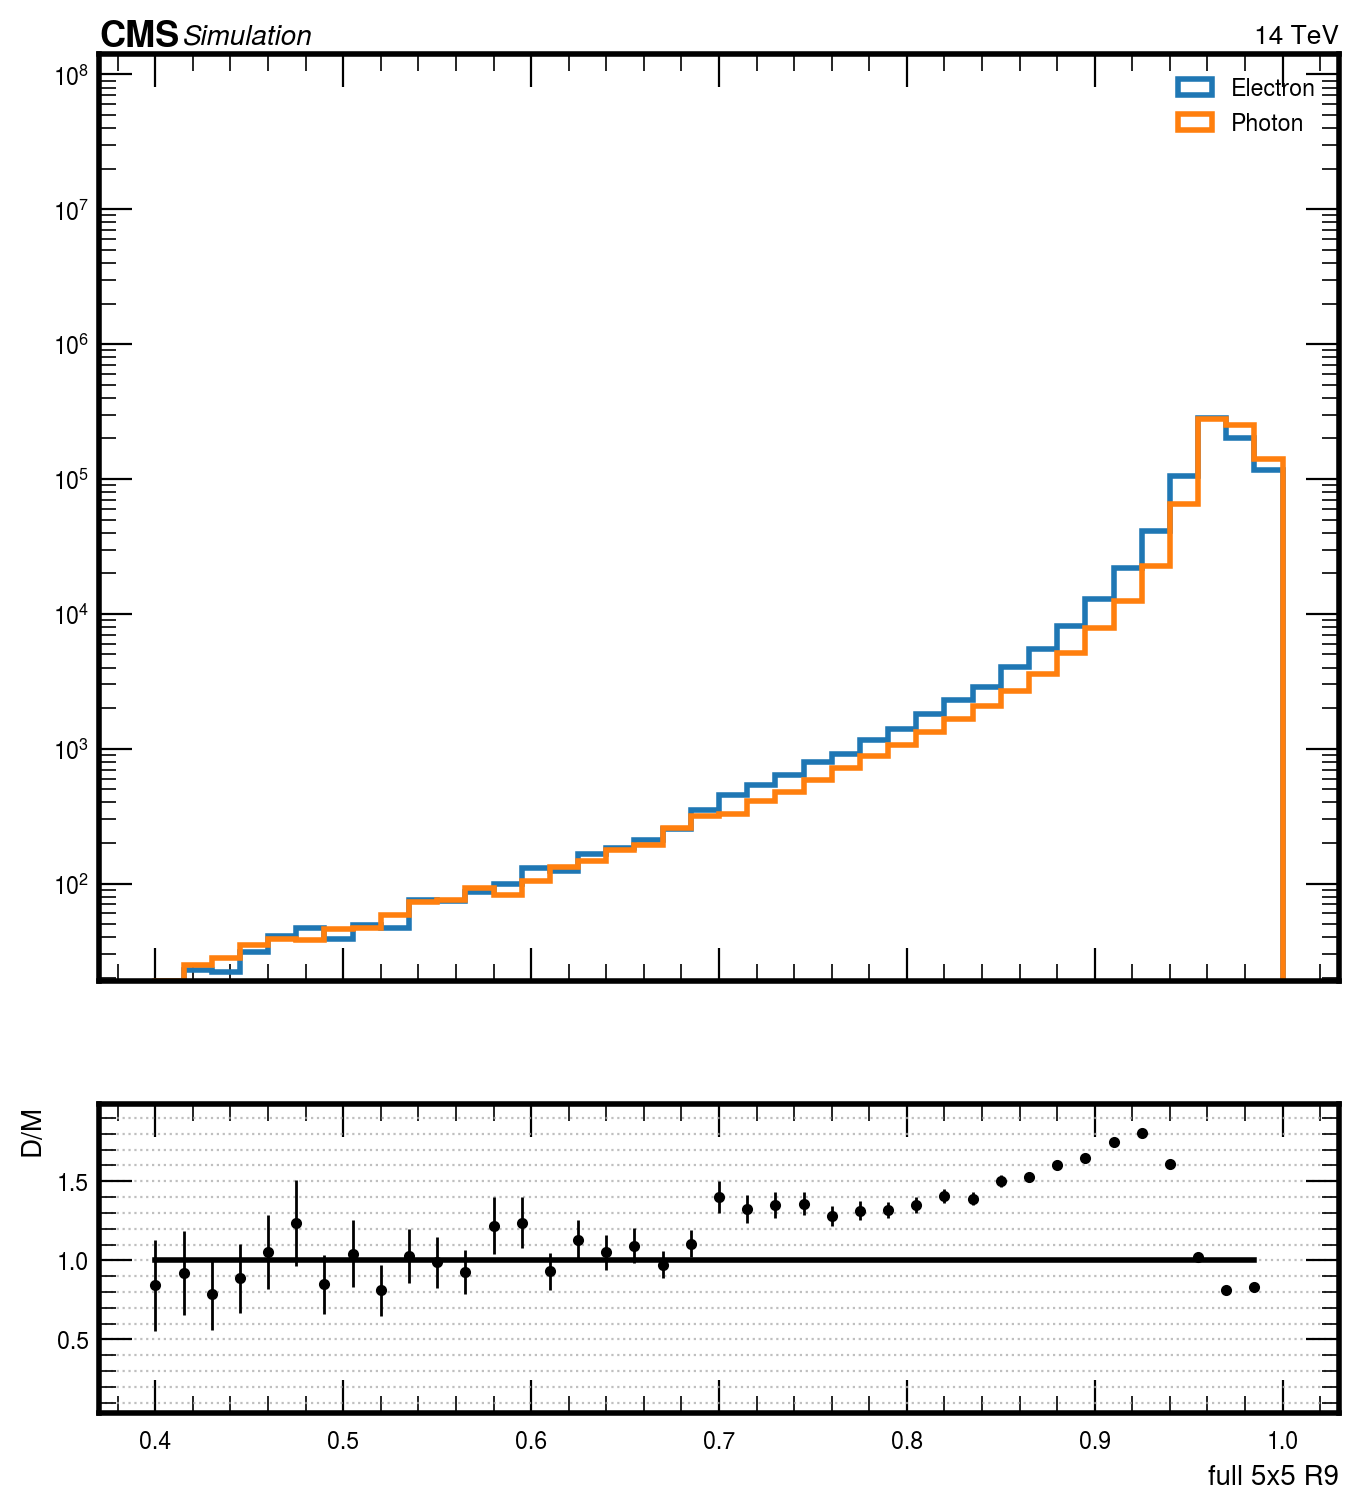

In [56]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="seed_f5_r9", label="full 5x5 R9", bins=40, xrange=(0.4,1.), ylog=True,
                output_folder= output_folder + "/plots_check_input")

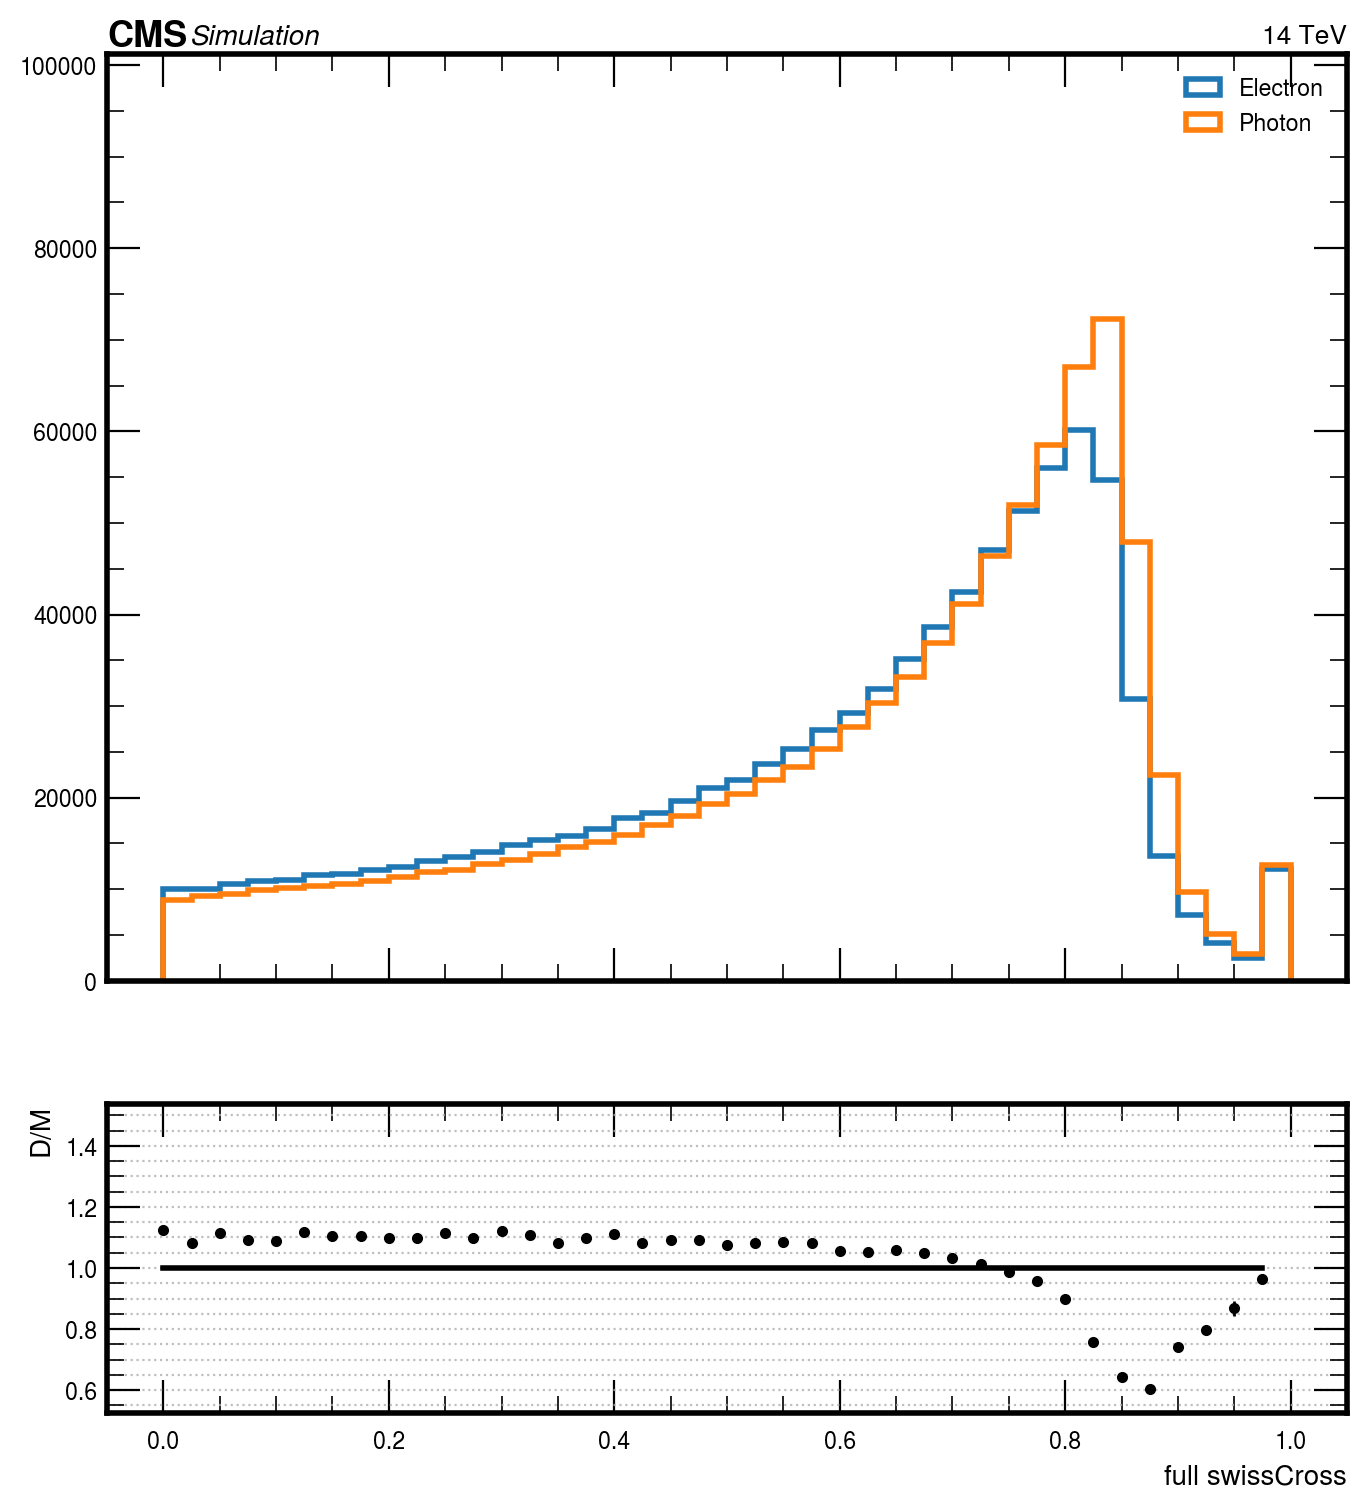

In [57]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="seed_swissCross", label="full swissCross", bins=40, xrange=(0.,1.),
                output_folder= output_folder + "/plots_check_input")

/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:30: RuntimeWarning: divide by zero encountered in divide
  axr.errorbar(binX[:-1], A/B, xerr=0, yerr=errR,
/tmp/ipykernel_426/1062678864.py:30: RuntimeWarning: invalid value encountered in divide
  axr.errorbar(binX[:-1], A/B, xerr=0, yerr=errR,
/tmp/ipykernel_426/1062678864.py:33: RuntimeWarning: divide by zero encountered in divide
  deltaM = np.max(np.abs((A/B)-1))
/tmp/ipykernel_426/1062678864.py:33: RuntimeWarning: invalid value encountered in divide
  deltaM = np.max(np.abs((A/B)-1))


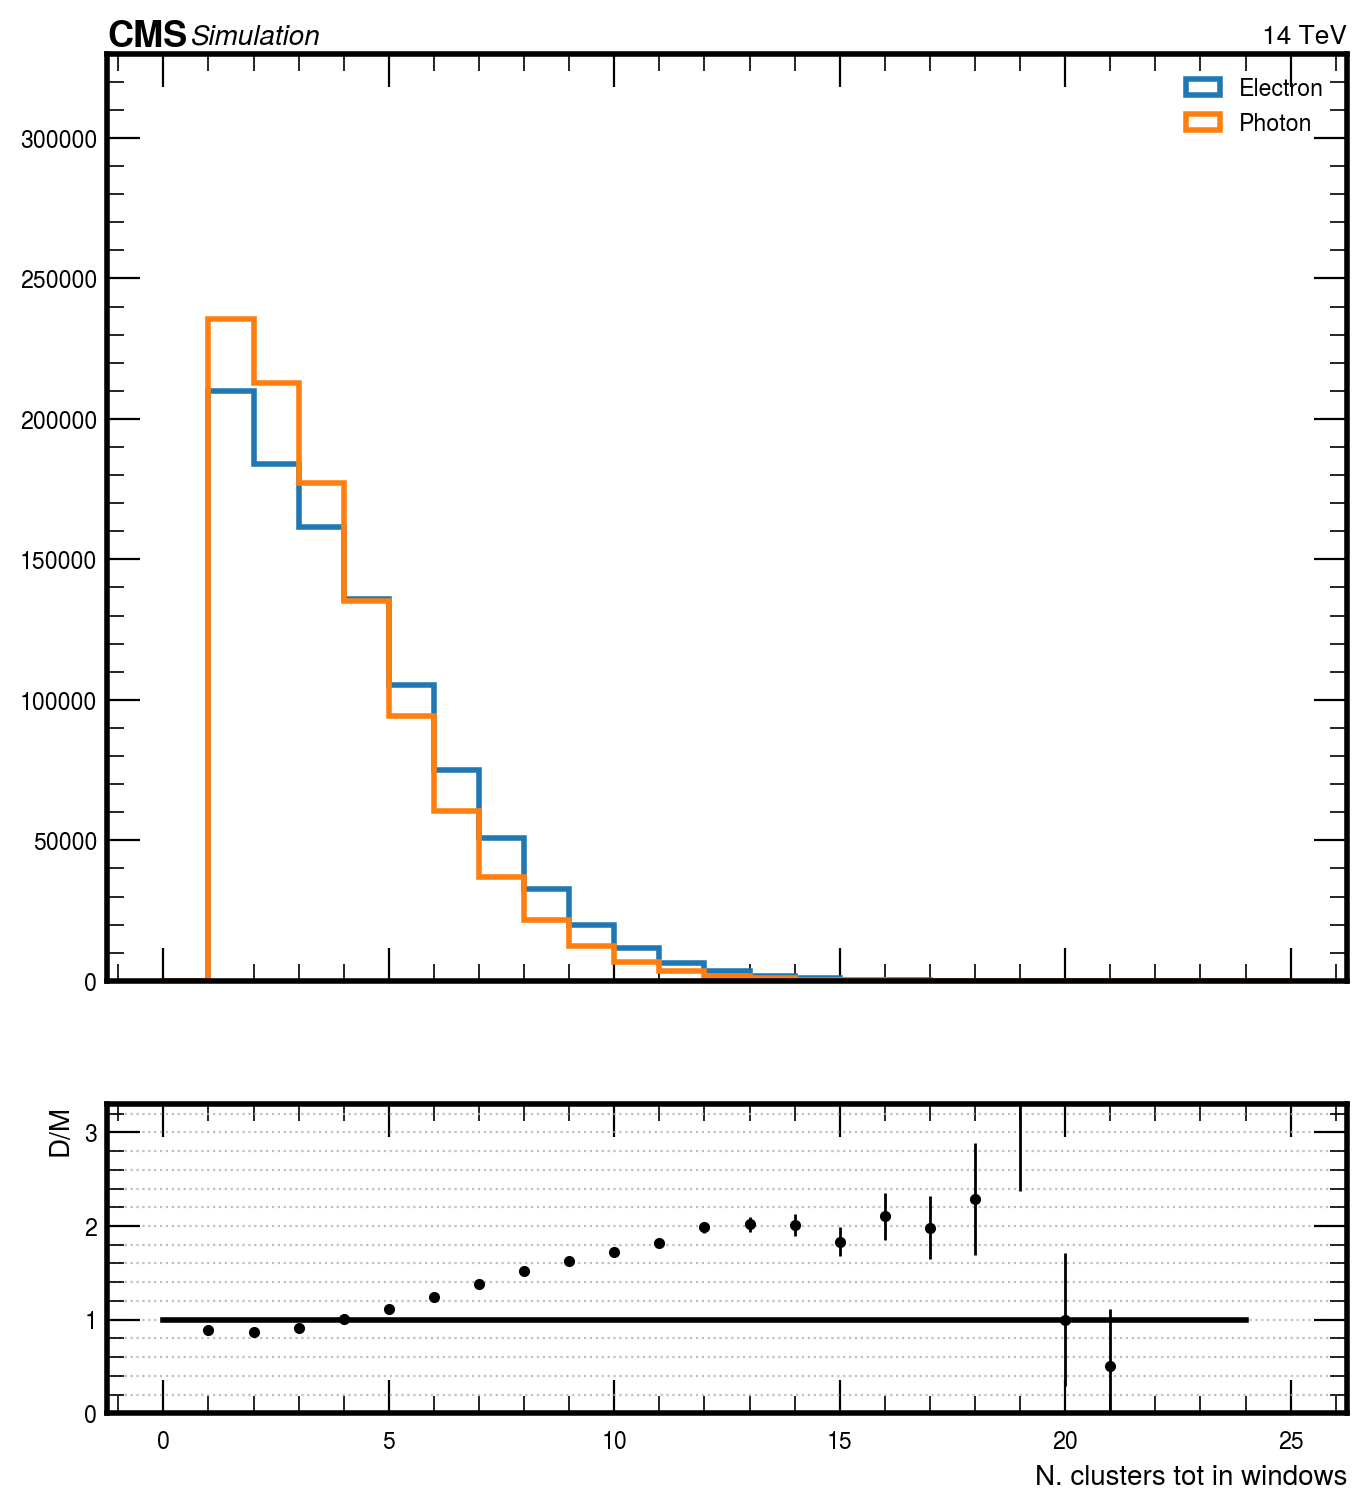

In [58]:
plot_comparison(df_ele.window_metadata, df_gamma.window_metadata,
                var="ncls", label="N. clusters tot in windows", bins=25, xrange=(0.,25),
                output_folder= output_folder + "/plots_check_input")

/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:30: RuntimeWarning: invalid value encountered in divide
  axr.errorbar(binX[:-1], A/B, xerr=0, yerr=errR,
/tmp/ipykernel_426/1062678864.py:33: RuntimeWarning: invalid value encountered in divide
  deltaM = np.max(np.abs((A/B)-1))


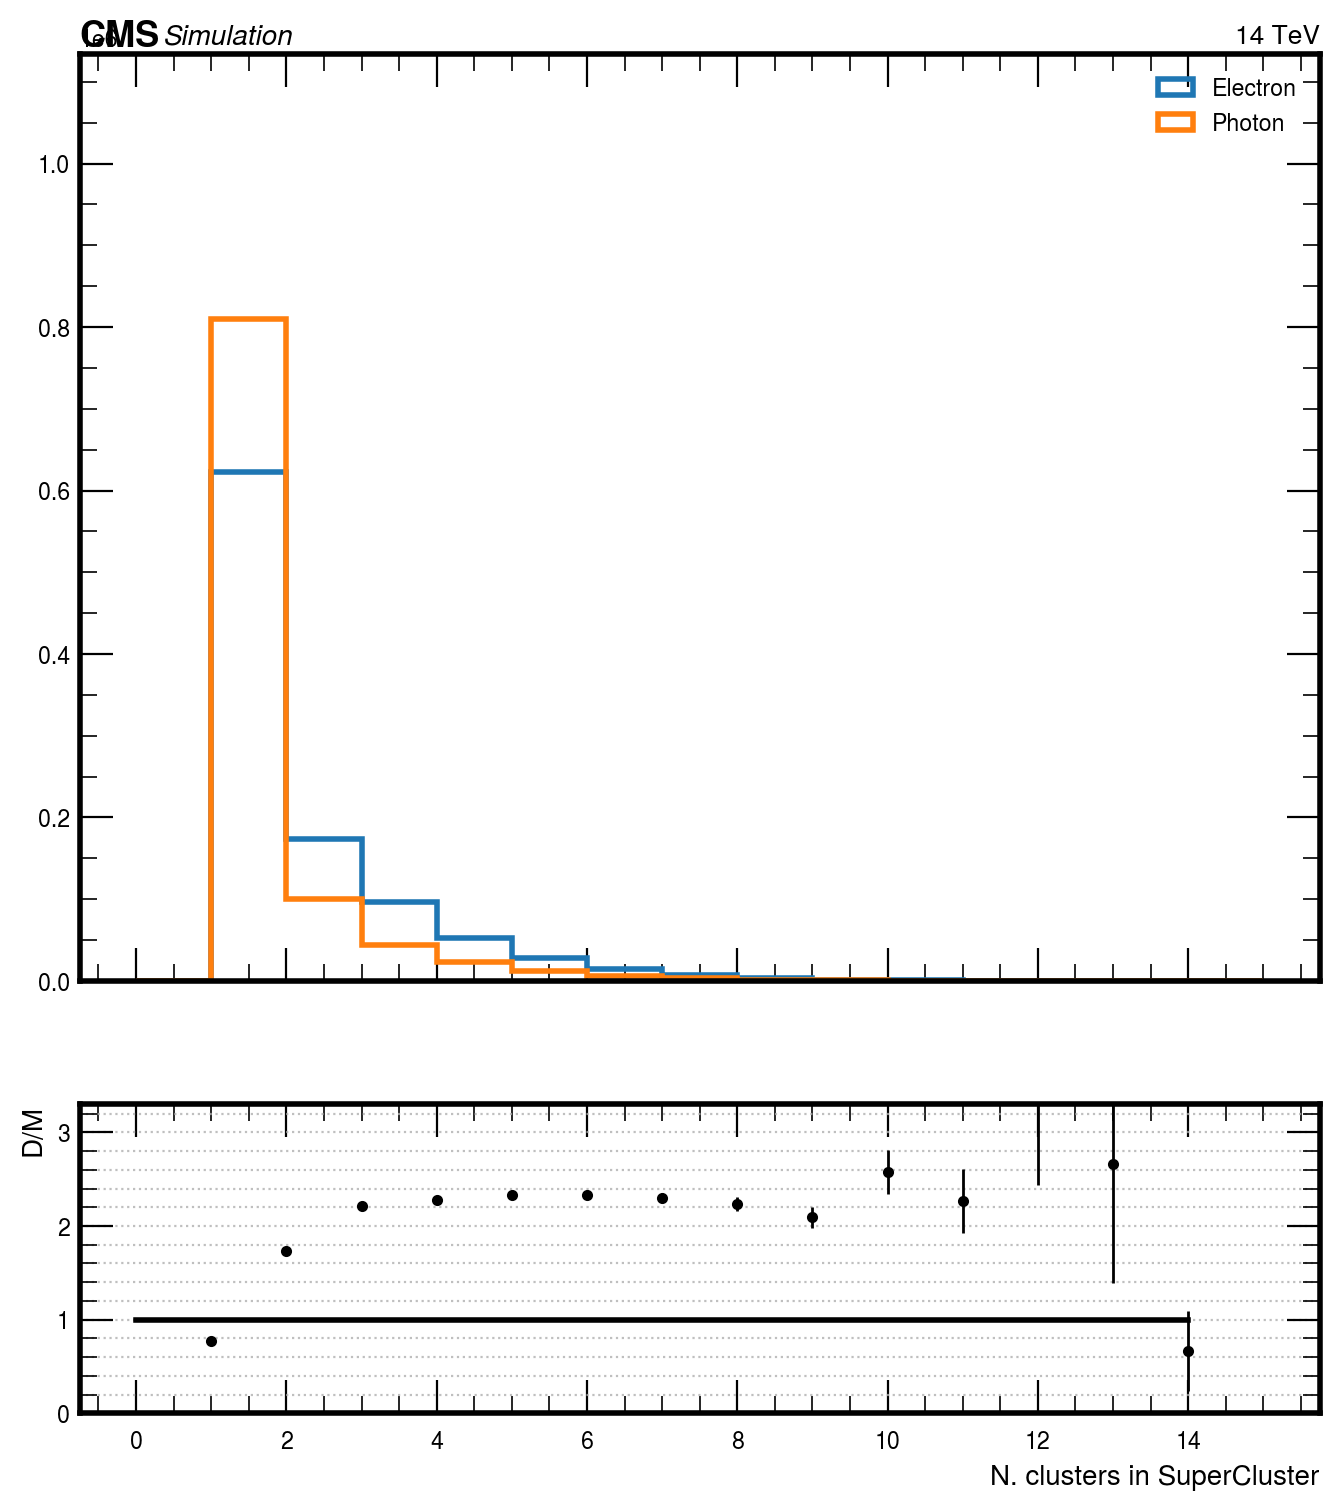

In [59]:
plot_comparison(df_ele.window_metadata, df_gamma.window_metadata,
                var="nclusters_insc", label="N. clusters in SuperCluster", bins=15, xrange=(0.,15),
                output_folder= output_folder + "/plots_check_input")

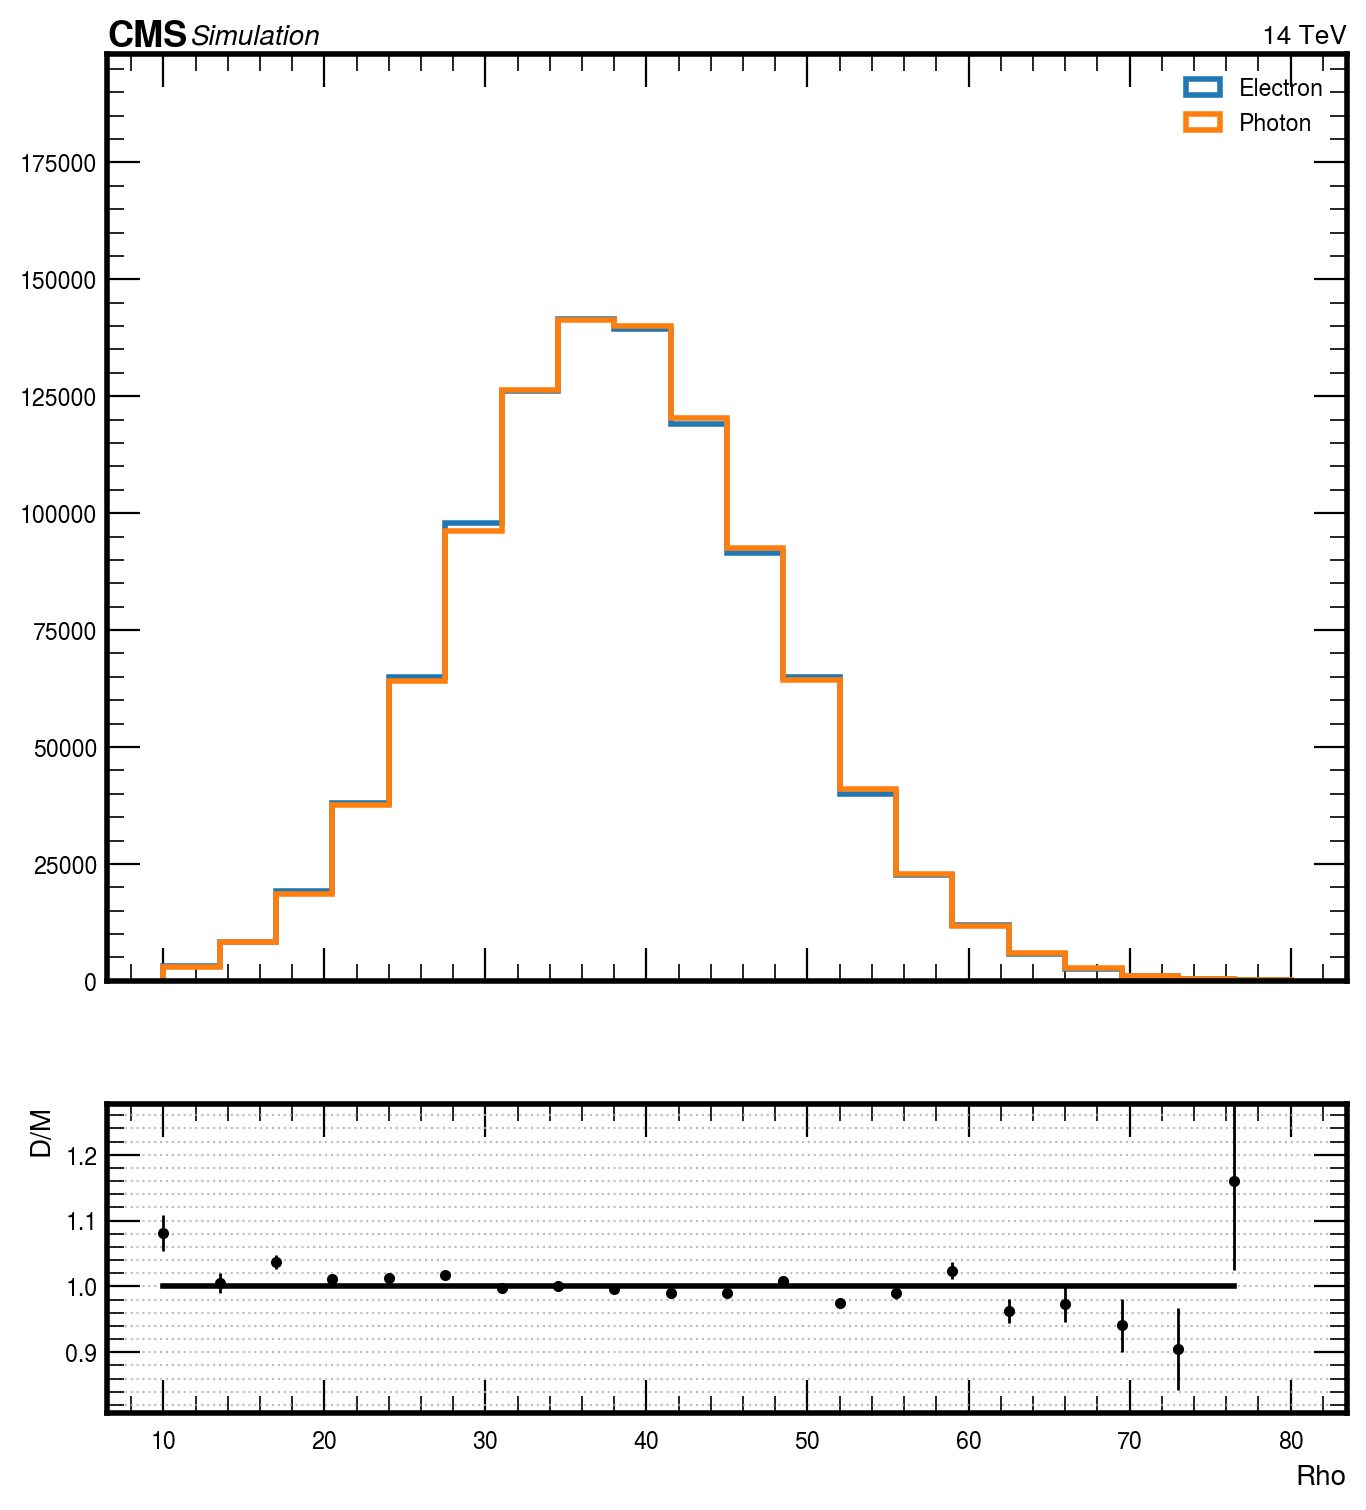

In [60]:
plot_comparison(df_ele.window_metadata, df_gamma.window_metadata,
                var="rho", label="Rho", bins=20, xrange=(10.,80),
                output_folder= output_folder + "/plots_check_input")

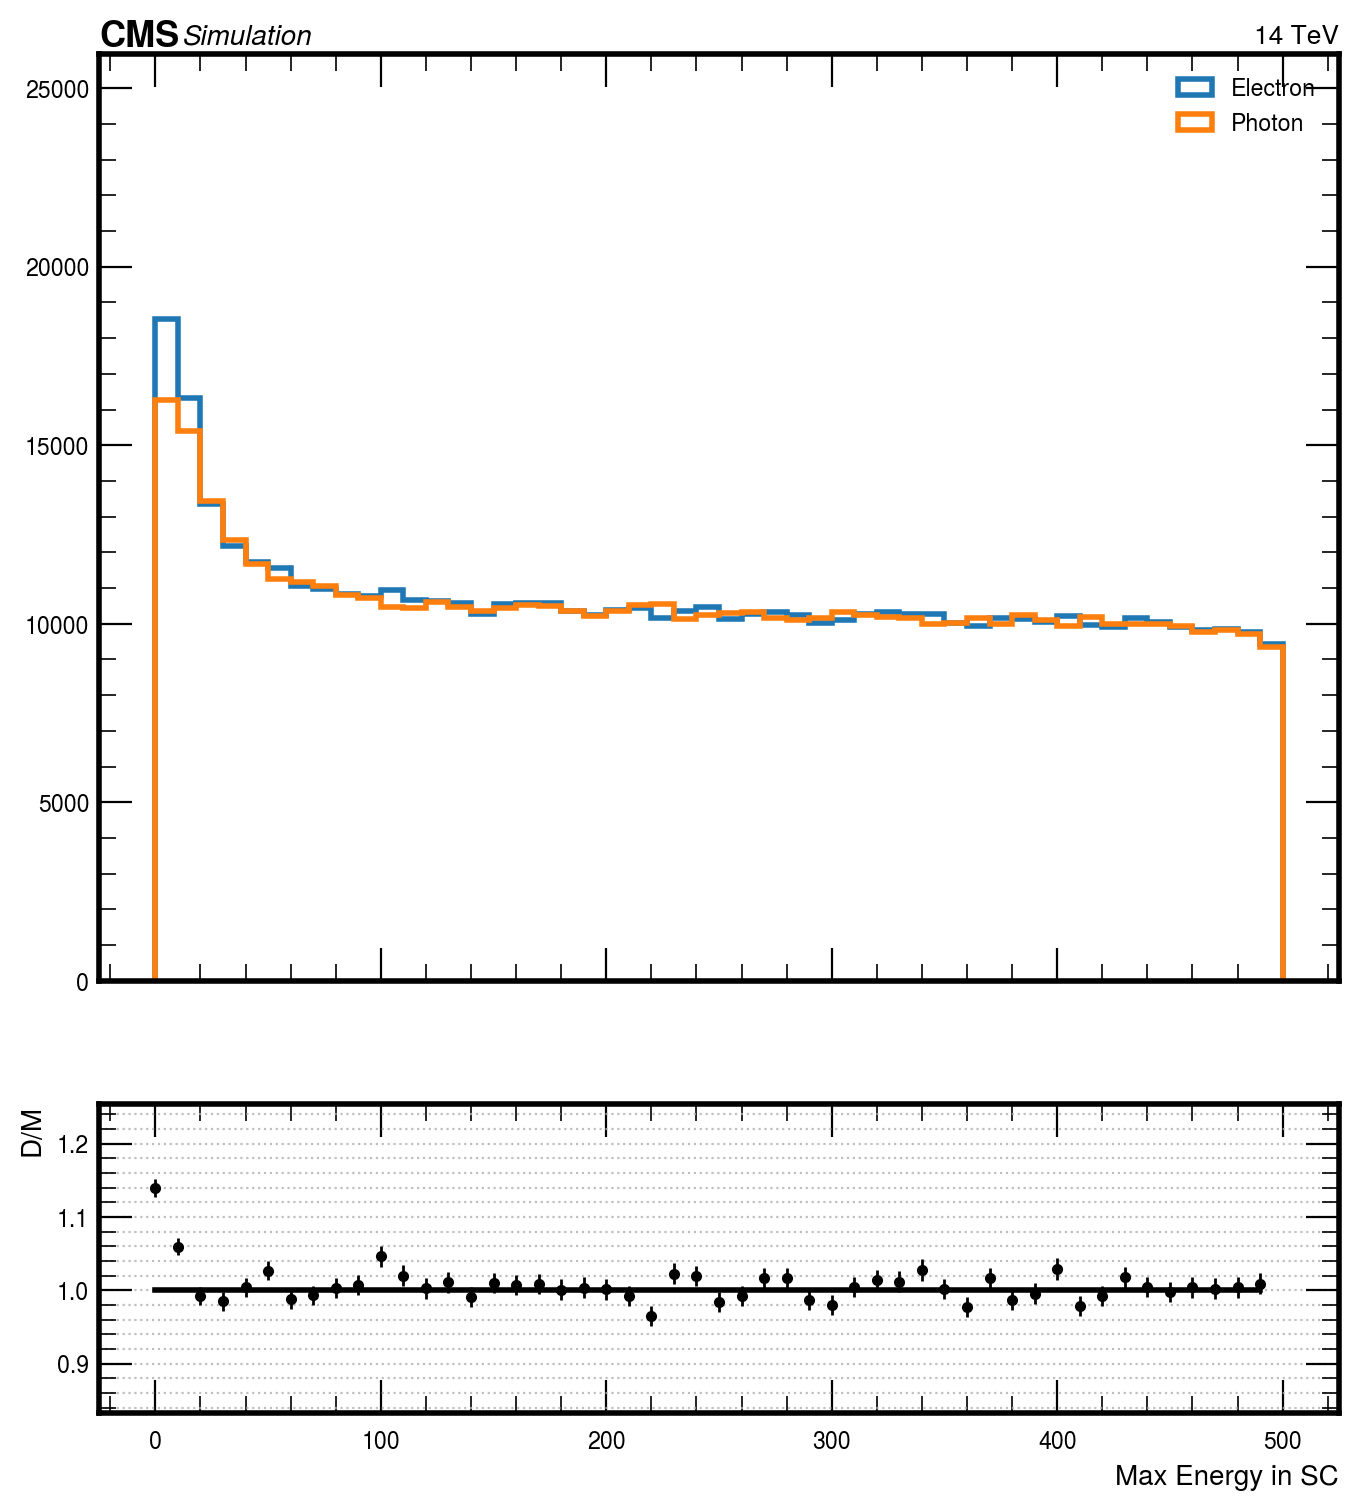

In [61]:
plot_comparison(df_ele.window_metadata, df_gamma.window_metadata,
                var="max_en_cluster_insc", label="Max Energy in SC", bins=50, xrange=(0., 500.),
                output_folder= output_folder + "/plots_check_input")

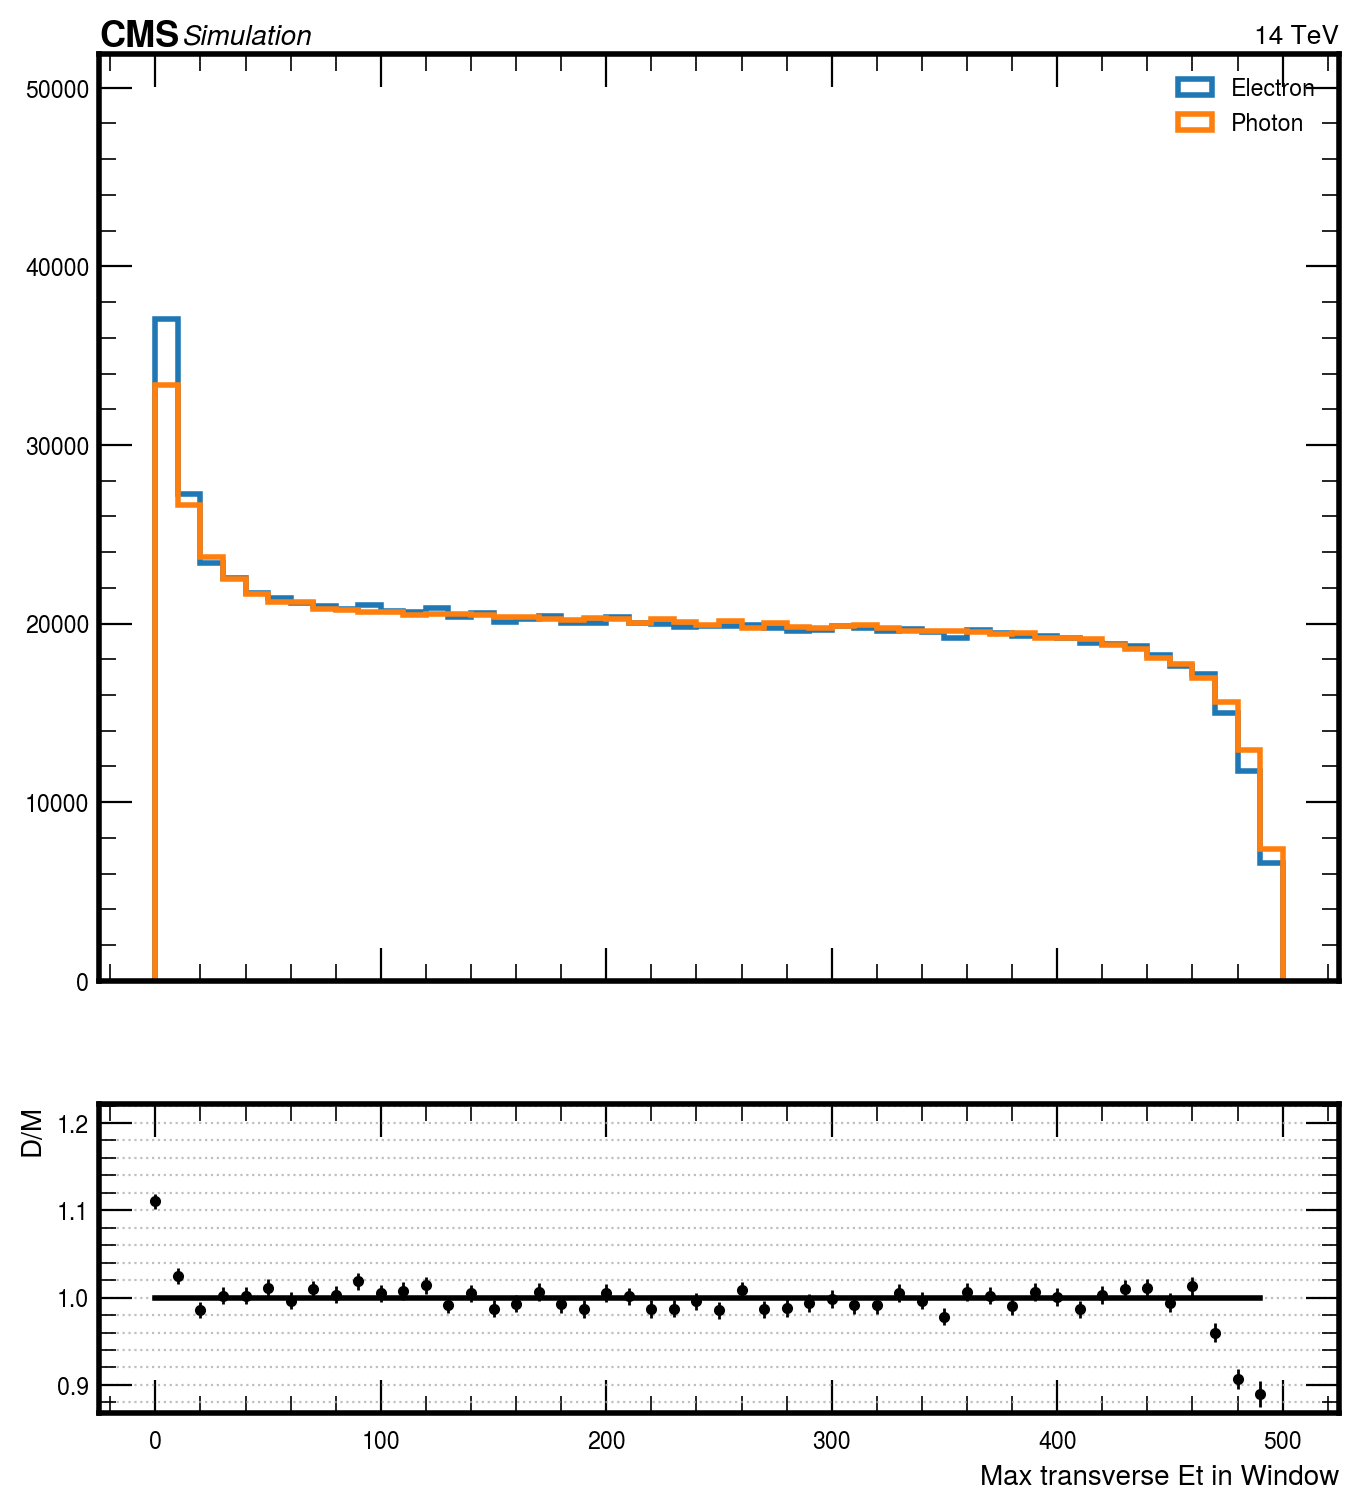

In [62]:
plot_comparison(df_ele.window_features, df_gamma.window_features,
                var="max_et_cluster", label="Max transverse Et in Window", bins=50, xrange=(0., 500.),
                output_folder= output_folder + "/plots_check_input")

/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:30: RuntimeWarning: invalid value encountered in divide
  axr.errorbar(binX[:-1], A/B, xerr=0, yerr=errR,
/tmp/ipykernel_426/1062678864.py:33: RuntimeWarning: invalid value encountered in divide
  deltaM = np.max(np.abs((A/B)-1))


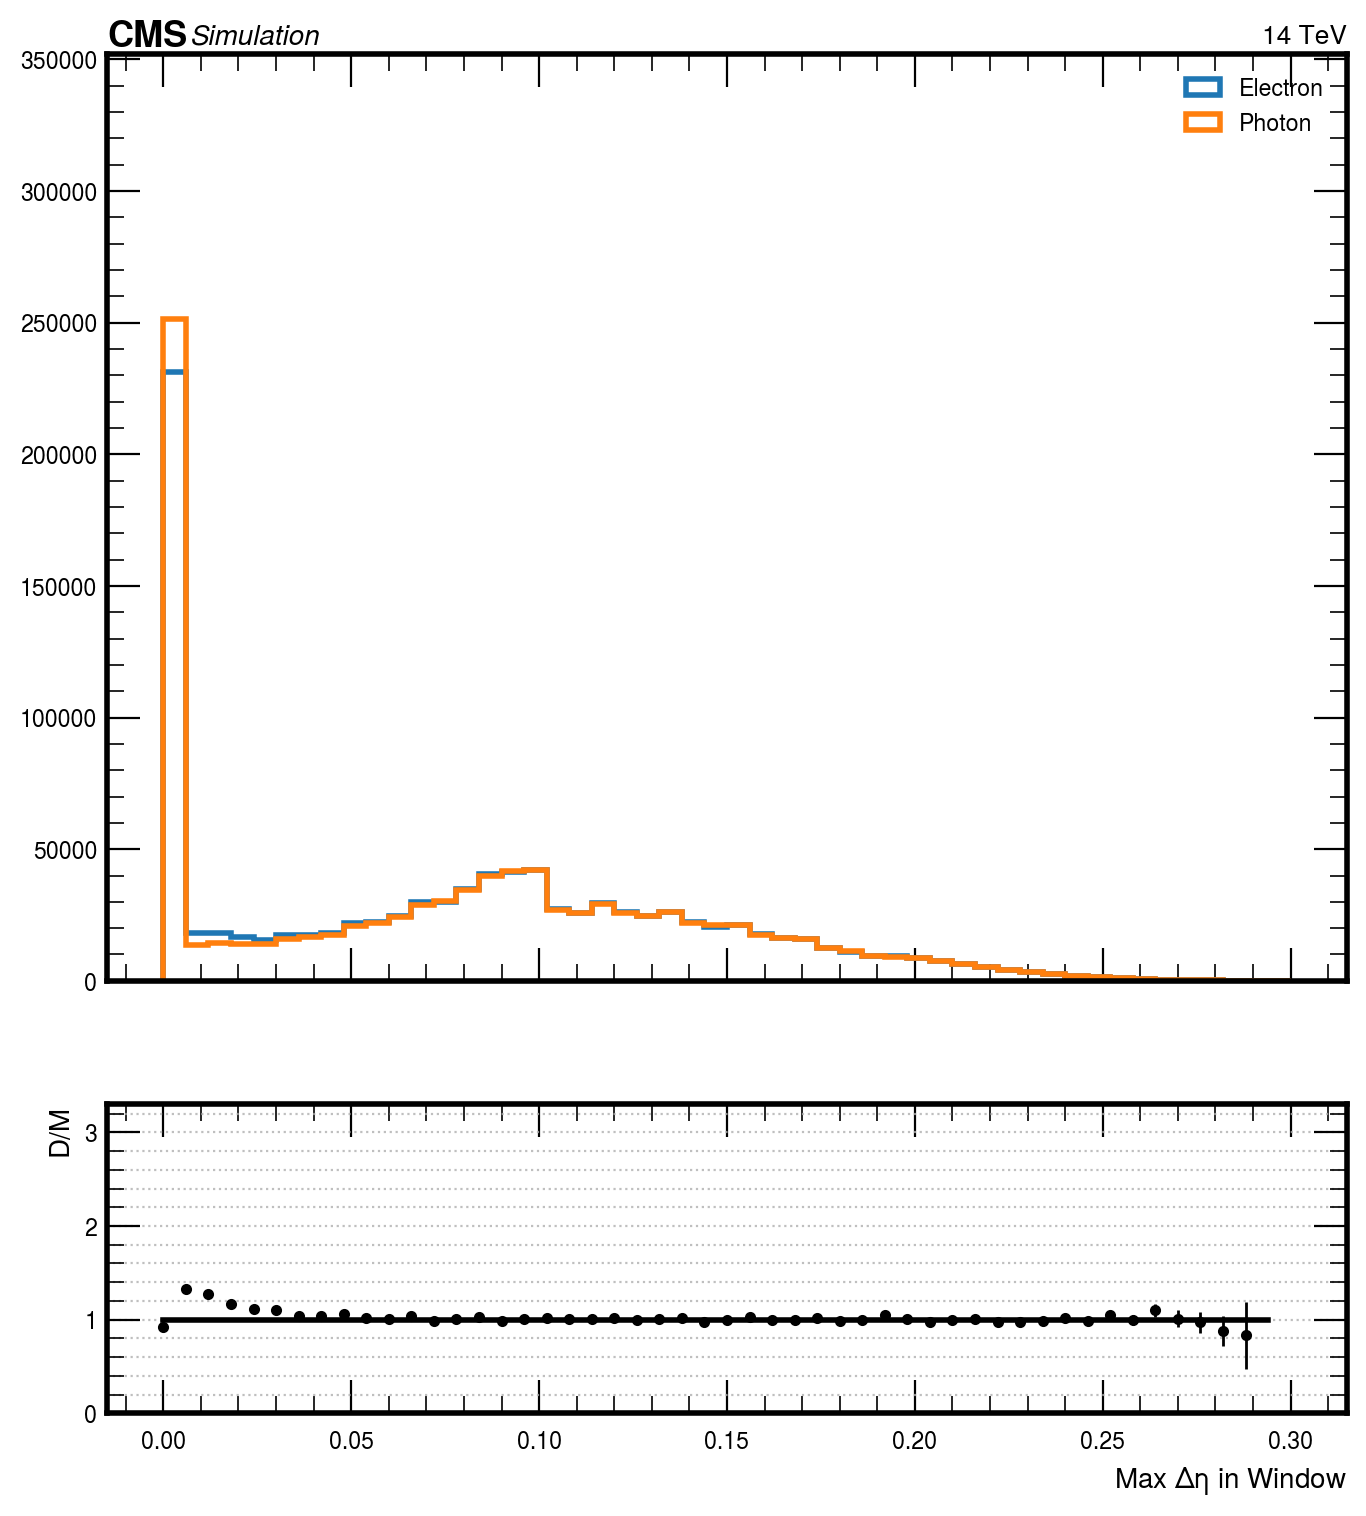

In [63]:
plot_comparison(df_ele.window_features, df_gamma.window_features,
                var="max_deta_cluster", label="Max $\Delta \eta$ in Window", bins=50, xrange=(0.,0.3),
                output_folder= output_folder + "/plots_check_input")

/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:30: RuntimeWarning: invalid value encountered in divide
  axr.errorbar(binX[:-1], A/B, xerr=0, yerr=errR,
/tmp/ipykernel_426/1062678864.py:33: RuntimeWarning: invalid value encountered in divide
  deltaM = np.max(np.abs((A/B)-1))


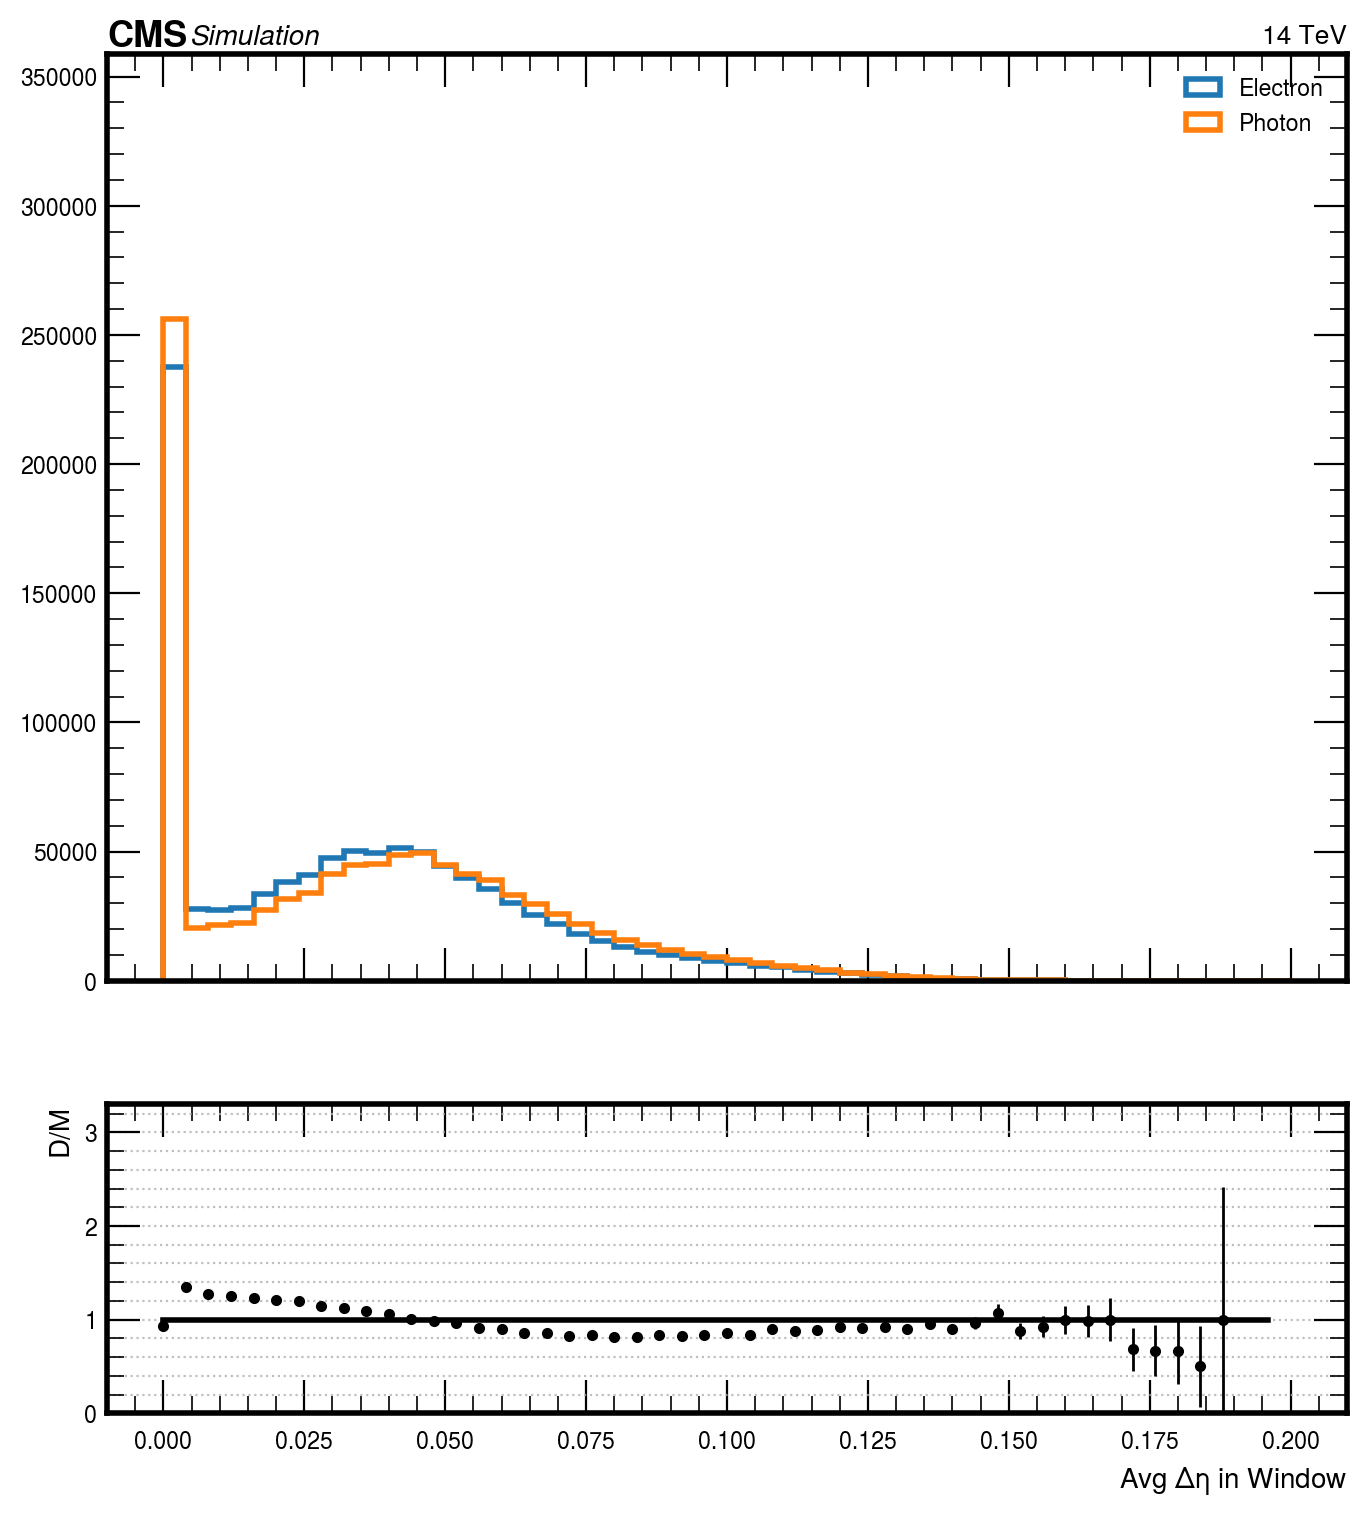

In [64]:
plot_comparison(df_ele.window_features, df_gamma.window_features,
                var="mean_deta_cluster", label="Avg $\Delta \eta$ in Window", bins=50, xrange=(0.,0.2),
                output_folder= output_folder + "/plots_check_input")

In [65]:
df_ele.window_features.afields

AttributeError: no field named 'afields'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)

## Reweighting between electron and photons

### By Seed Et and N. cls

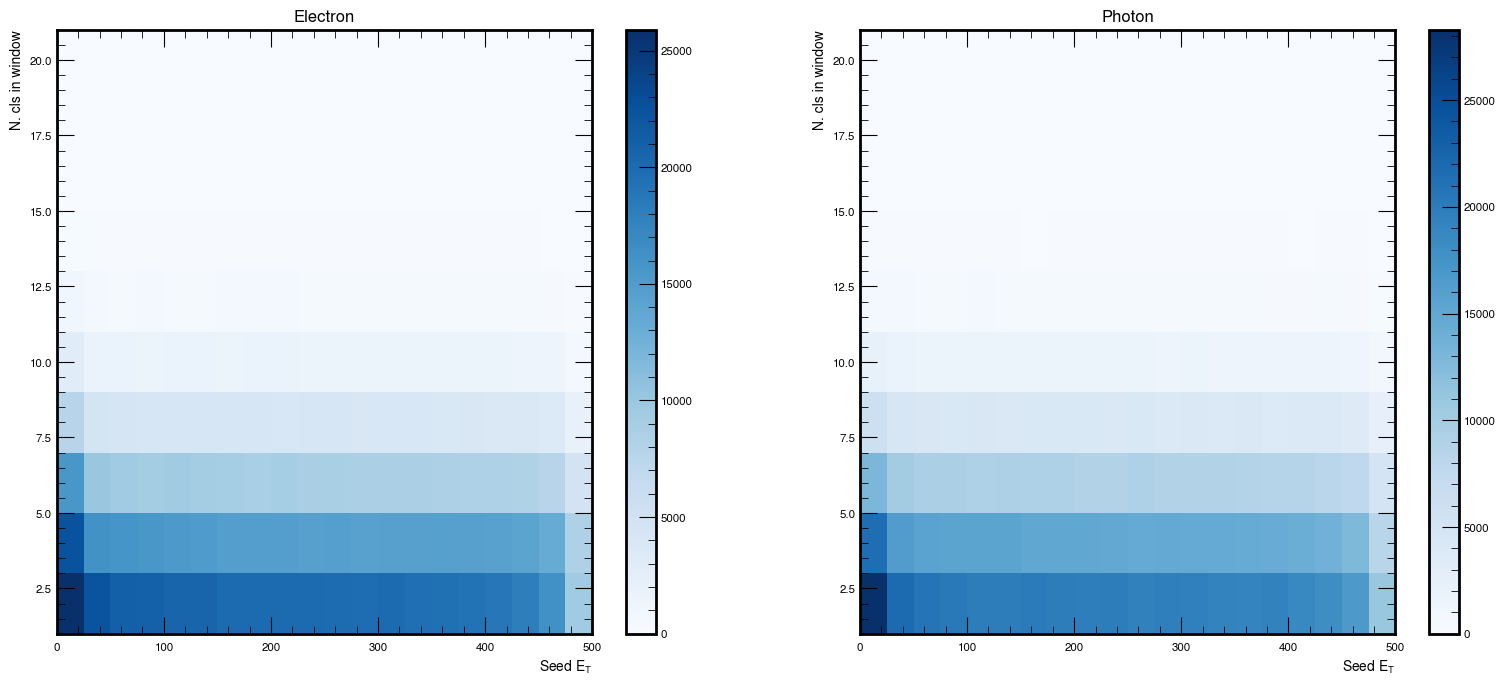

In [66]:
f, (ax,ay) = plt.subplots(1,2,figsize=(19,8), dpi=100)
c, h, b , I =  ax.hist2d(ak.to_numpy(df_ele.seed_features.et_seed),ak.to_numpy(df_ele.window_metadata.ncls), 
          range=((0., 500.),(1,21)), bins=(20, 10))
ax.set_xlabel("Seed $E_T$")
ax.set_ylabel("N. cls in window")
ax.set_title("Electron")
plt.colorbar(I, ax=ax)

c, h, b , I =  ay.hist2d(ak.to_numpy(df_gamma.seed_features.et_seed),ak.to_numpy(df_ele.window_metadata.ncls),  
          range=((0., 500.),(1,21)), bins=(20, 10))
ay.set_xlabel("Seed $E_T$")
ay.set_ylabel("N. cls in window")
ay.set_title("Photon")
plt.colorbar(I, ax=ay)

f.savefig(output_folder + f"/seed_et_ncsltot_comparison_noseedweight.png")
f.savefig(output_folder + f"/seed_et_ncsltot_comparison_noseedweight.pdf")
f.savefig(output_folder + f"/seed_et_ncsltot_comparison_noseedweight.svg")

In [67]:
w_ele_seed = corr_et_eta.evaluate(11,ak.to_numpy(df_ele.seed_features.et_seed),  
                         ak.to_numpy(abs(df_ele.seed_features.seed_eta)))
w_gamma_seed = corr_et_eta.evaluate(22,ak.to_numpy(df_gamma.seed_features.et_seed), 
                           ak.to_numpy(abs(df_gamma.seed_features.seed_eta)) )

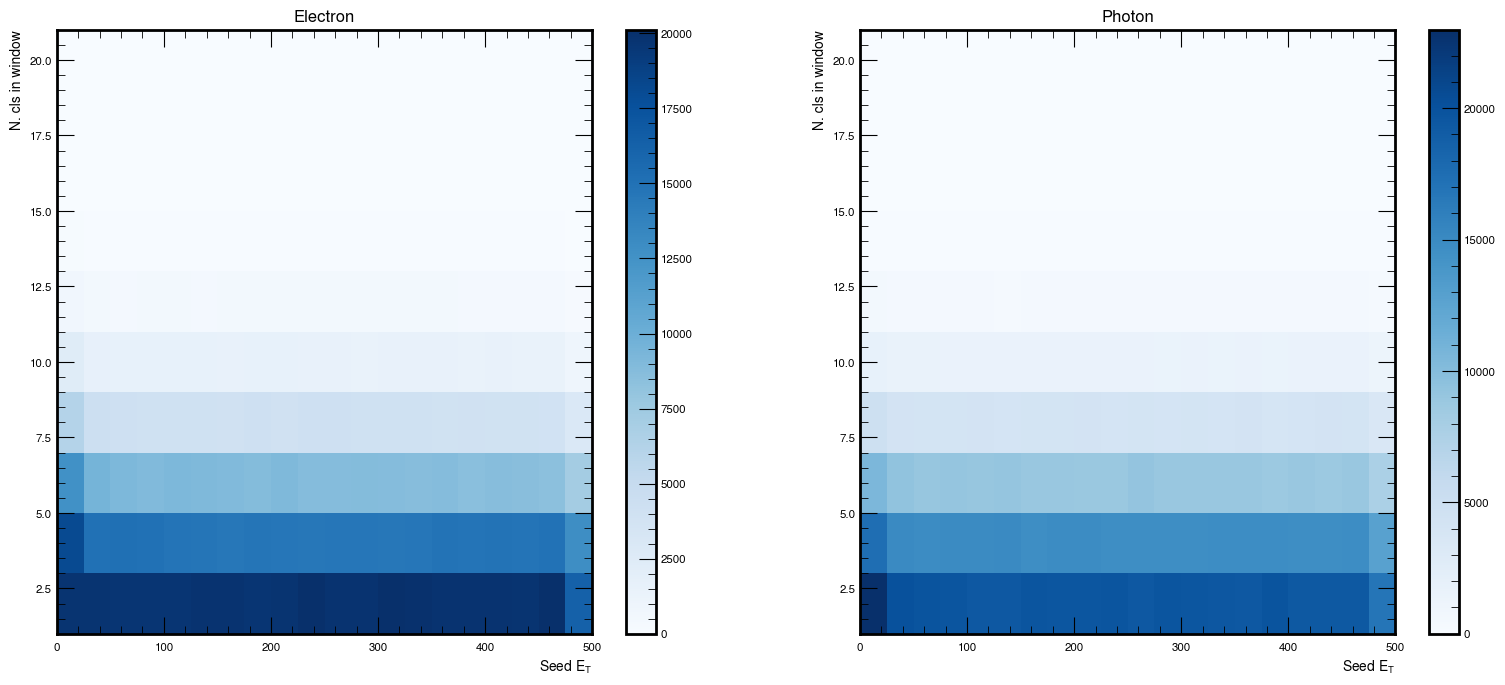

In [68]:
f, (ax,ay) = plt.subplots(1,2,figsize=(19,8), dpi=100)
c, h, b , I =  ax.hist2d(ak.to_numpy(df_ele.seed_features.et_seed),ak.to_numpy(df_ele.window_metadata.ncls), 
          range=((0., 500.),(1,21)), bins=(20, 10), weights=w_ele_seed)
ax.set_xlabel("Seed $E_T$")
ax.set_ylabel("N. cls in window")
ax.set_title("Electron")
plt.colorbar(I, ax=ax)

c, h, b , I =  ay.hist2d(ak.to_numpy(df_gamma.seed_features.et_seed),ak.to_numpy(df_ele.window_metadata.ncls),  
          range=((0., 500.),(1,21)), bins=(20, 10), weights=w_gamma_seed)
ay.set_xlabel("Seed $E_T$")
ay.set_ylabel("N. cls in window")
ay.set_title("Photon")
plt.colorbar(I, ax=ay)

f.savefig(output_folder + f"/seed_et_ncsltot_comparison_seedweight.png")
f.savefig(output_folder + f"/seed_et_ncsltot_comparison_seedweight.pdf")
f.savefig(output_folder + f"/seed_et_ncsltot_comparison_seedweight.svg")

/tmp/ipykernel_426/1562691322.py:12: RuntimeWarning: divide by zero encountered in divide
  r = c_ele / c_gamma


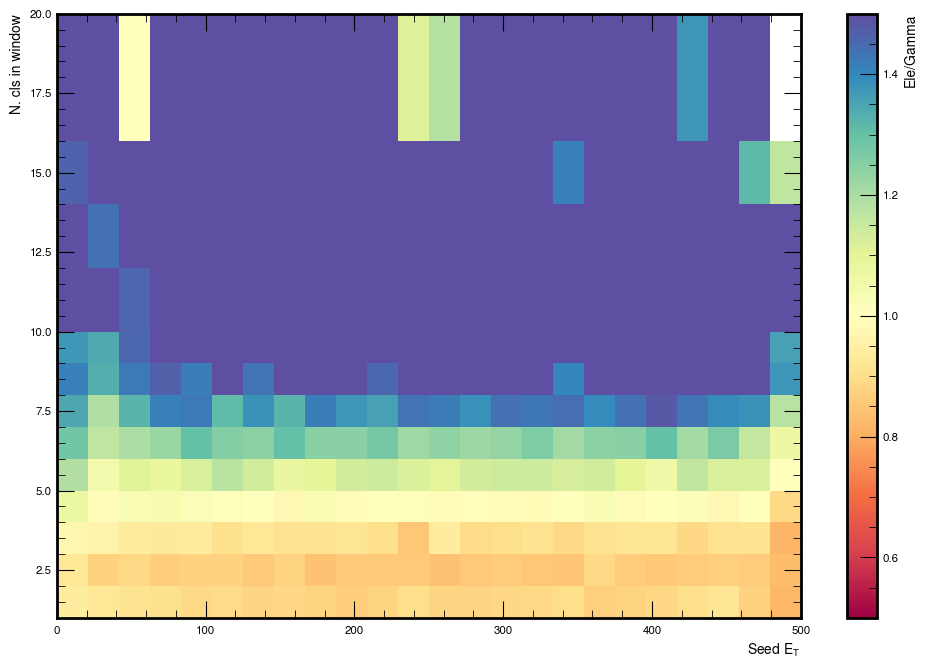

In [69]:
bins_et = np.linspace(0., 500., 25)
bins_ncls = [1,2,3,4,5,6,7,8,9,10,12,14,16,20]

f, ax, = plt.subplots(1,figsize=(12,8), dpi=100)
c_ele, bx, by  = np.histogram2d(ak.to_numpy(df_ele.seed_features.et_seed),
                                ak.to_numpy(df_ele.window_metadata.ncls), 
                                  bins=[bins_et, bins_ncls])
c_gamma, bx, by  = np.histogram2d(ak.to_numpy(df_gamma.seed_features.et_seed),
                                  ak.to_numpy(df_gamma.window_metadata.ncls), 
                                   bins=[bins_et, bins_ncls])

r = c_ele / c_gamma

mesh = ax.pcolormesh(bx, by, r.T, cmap="Spectral", vmin=0.5, vmax=1.5)

ax.set_xlabel("Seed $E_T$")
ax.set_ylabel("N. cls in window")
plt.colorbar(mesh,ax=ax, label="Ele/Gamma")


f.savefig(output_folder + f"/seed_et_ncsltot_comparison_ratio_noseedweight.png")
f.savefig(output_folder + f"/seed_et_ncsltot_comparison_ratio_noseedweight.pdf")
f.savefig(output_folder + f"/seed_et_ncsltot_comparison_ratio_noseedweight.svg")


/tmp/ipykernel_426/3448921342.py:14: RuntimeWarning: divide by zero encountered in divide
  r = c_ele / c_gamma


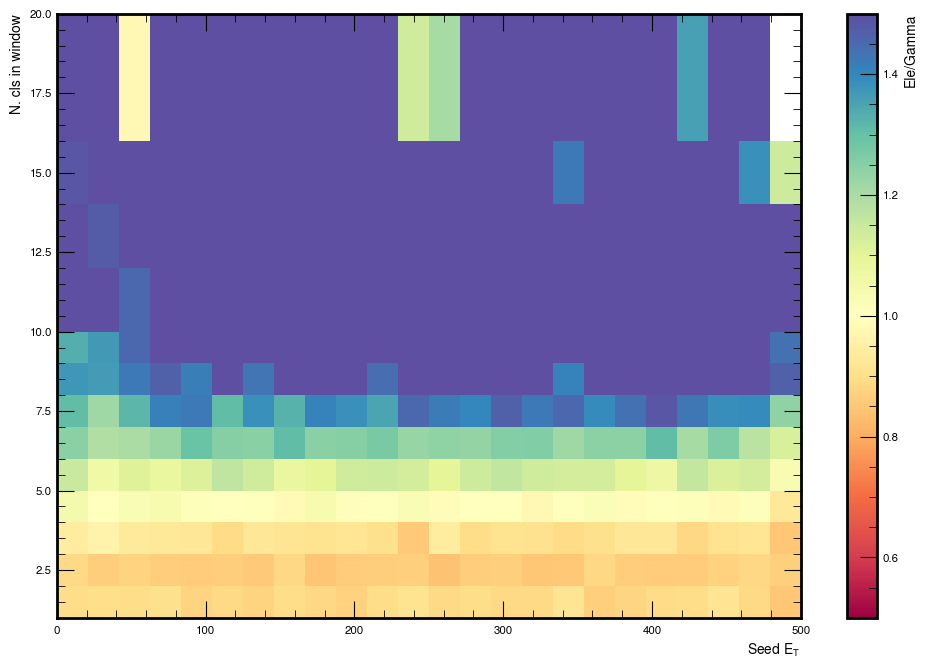

In [70]:
bins_et = np.linspace(0., 500., 25)
bins_ncls = [1,2,3,4,5,6,7,8,9,10,12,14,16,20]

f, ax, = plt.subplots(1,figsize=(12,8), dpi=100)
c_ele, bx, by  = np.histogram2d(ak.to_numpy(df_ele.seed_features.et_seed),
                                ak.to_numpy(df_ele.window_metadata.ncls), 
                                  bins=[bins_et, bins_ncls],
                               weights=w_ele_seed)
c_gamma, bx, by  = np.histogram2d(ak.to_numpy(df_gamma.seed_features.et_seed),
                                  ak.to_numpy(df_gamma.window_metadata.ncls), 
                                   bins=[bins_et, bins_ncls],
                                  weights=w_gamma_seed)

r = c_ele / c_gamma

mesh = ax.pcolormesh(bx, by, r.T, cmap="Spectral", vmin=0.5, vmax=1.5)

ax.set_xlabel("Seed $E_T$")
ax.set_ylabel("N. cls in window")
plt.colorbar(mesh,ax=ax, label="Ele/Gamma")


f.savefig(output_folder + f"/seed_et_ncsltot_comparison_ratio_seedweight.png")
f.savefig(output_folder + f"/seed_et_ncsltot_comparison_ratio_seedweight.pdf")
f.savefig(output_folder + f"/seed_et_ncsltot_comparison_ratio_seedweight.svg")


### By Seed eta and N. cls

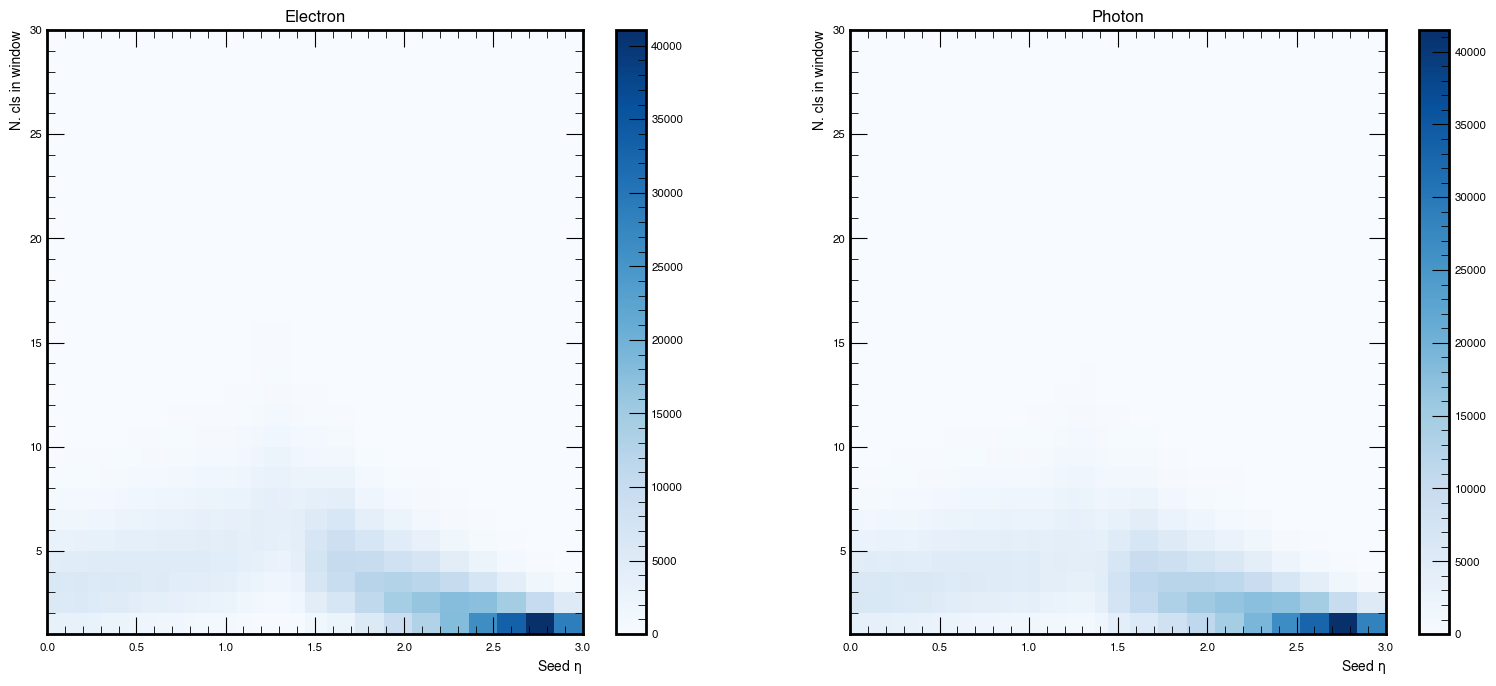

In [71]:
bins_et = np.concatenate([np.linspace(0, 1.4442,20),  np.linspace(1.566, 3, 10)])
bins_ncls = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,20,30]


f, (ax,ay) = plt.subplots(1,2,figsize=(19,8), dpi=100)
c, h, b , I =  ax.hist2d(ak.to_numpy(abs(df_ele.seed_features.seed_eta)),
                         ak.to_numpy(df_ele.window_metadata.ncls), 
          bins=[bins_et, bins_ncls])
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("N. cls in window")
ax.set_title("Electron")
plt.colorbar(I, ax=ax)

c, h, b , I =  ay.hist2d(ak.to_numpy(abs(df_gamma.seed_features.seed_eta)),
                         ak.to_numpy(df_gamma.window_metadata.ncls),  
           bins=[bins_et, bins_ncls])
ay.set_xlabel("Seed $\eta$")
ay.set_ylabel("N. cls in window")
ay.set_title("Photon")
plt.colorbar(I, ax=ay)

f.savefig(output_folder + f"/seed_eta_ncsltot_comparison.png")
f.savefig(output_folder + f"/seed_eta_ncsltot_comparison.pdf")
f.savefig(output_folder + f"/seed_eta_ncsltot_comparison.svg")

##### Weight with no seed weights

/tmp/ipykernel_426/3917678022.py:38: RuntimeWarning: divide by zero encountered in divide
  w_num/w_denom,
/tmp/ipykernel_426/3917678022.py:38: RuntimeWarning: invalid value encountered in divide
  w_num/w_denom,
/tmp/ipykernel_426/3917678022.py:41: RuntimeWarning: divide by zero encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_426/3917678022.py:41: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_426/3917678022.py:41: RuntimeWarning: invalid value encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


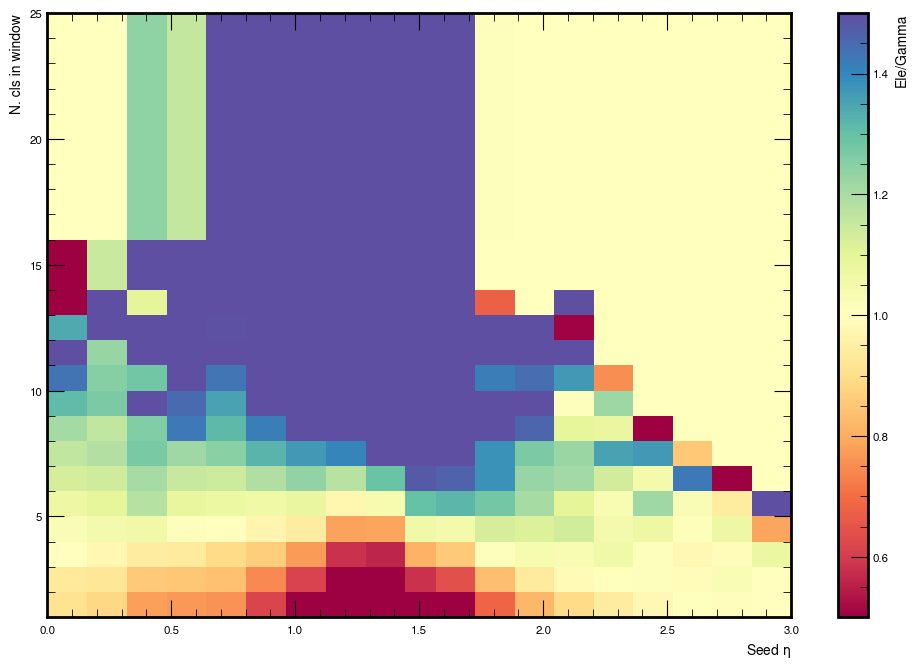

In [72]:
bins_eta = np.concatenate([np.linspace(0, 1.4442,10),  np.linspace(1.566, 3., 10)])
bins_ncls = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,25]


f, ax, = plt.subplots(1,figsize=(12,8), dpi=100)
c_ele, binx, by  = np.histogram2d(ak.to_numpy(df_ele.window_metadata.ncls), 
                                ak.to_numpy(abs(df_ele.seed_features.seed_eta)),
                                  bins=[ bins_ncls, bins_eta])
                               # weights=w_ele_seed)
c_gamma, binx, by  = np.histogram2d(ak.to_numpy(df_gamma.window_metadata.ncls),
                                ak.to_numpy(abs(df_gamma.seed_features.seed_eta)),   
                                   bins=[ bins_ncls, bins_eta])
                                 # weights=w_gamma_seed)

width_eta = (bins_eta - np.roll(bins_eta, 1))[1:]
width_ncls = (bins_ncls - np.roll(bins_ncls, 1))[1:]

# FLAtten out the by eta distribution
C_ele_eta = np.sum(c_ele, axis=0)
target_eta_ele = width_eta * np.sum(C_ele_eta)/ np.sum(width_eta) # ==> densita'
w_ele = target_eta_ele / C_ele_eta

C_gamma_eta = np.sum(c_gamma, axis=0)
target_eta_gamma = width_eta * np.sum(C_gamma_eta)/ np.sum(width_eta) # ==> densita'
w_gamma = target_eta_gamma / C_gamma_eta

# I want to profile on the eta direction and reweight the margin distribution of et 
# in different eta categories
A_ele = c_ele * w_ele
A_gamma = c_gamma * w_gamma

w_num = A_ele
w_denom = A_gamma
num_var = A_ele
denom_var = A_gamma

ratio= np.where( (w_denom>0)&(w_num>0),
                     w_num/w_denom,
                     1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                           np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                           0.)
mesh = ax.pcolormesh(by, binx, ratio, cmap="Spectral", vmin=0.5, vmax=1.5)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("N. cls in window")
plt.colorbar(mesh,ax=ax, label="Ele/Gamma")


f.savefig(output_folder + f"/seed_eta_ncsltot_comparison_ratio_noweightseed.png")
f.savefig(output_folder + f"/seed_eta_ncsltot_comparison_ratio_noweightseed.pdf")
f.savefig(output_folder + f"/seed_eta_ncsltot_comparison_ratio_noweightseed.svg")

##### Weight with seed weights

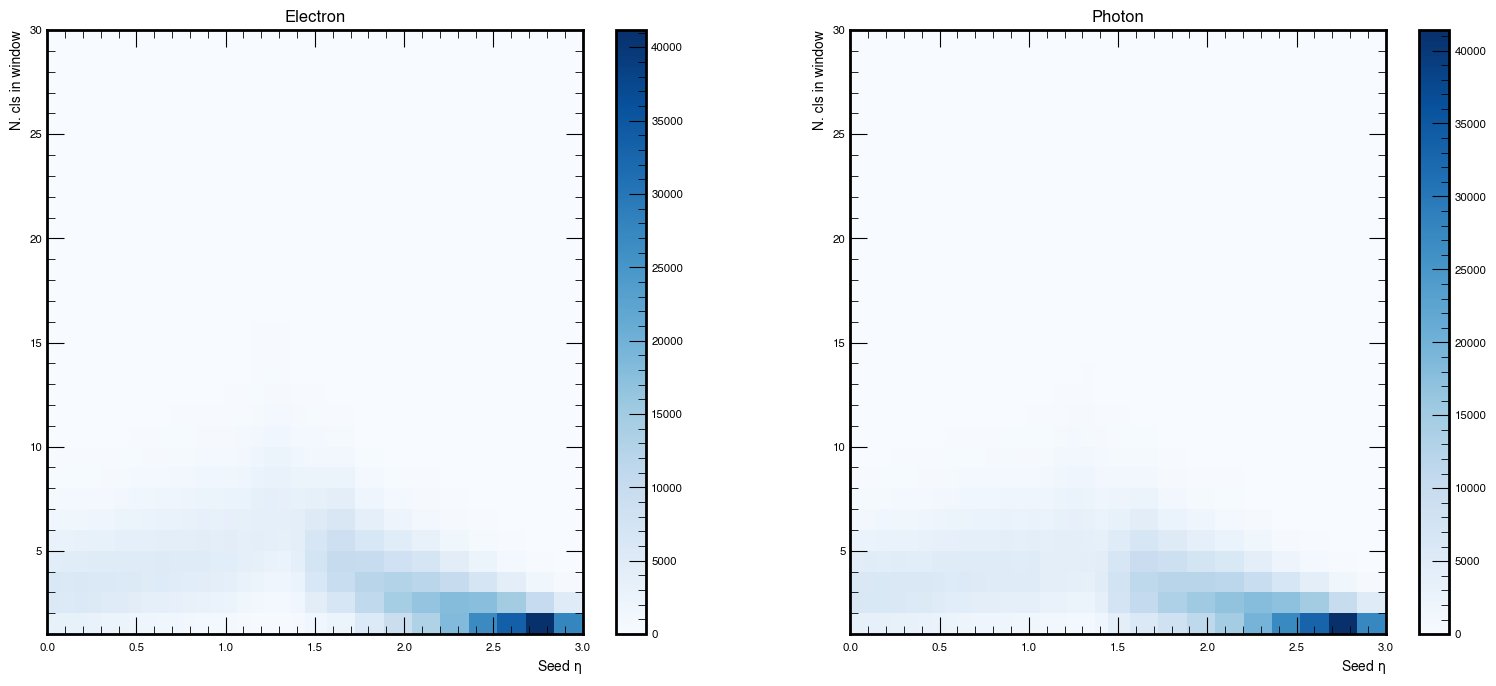

In [73]:
bins_et = np.concatenate([np.linspace(0, 1.4442,20),  np.linspace(1.566, 3, 10)])
bins_ncls = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,20,30]


f, (ax,ay) = plt.subplots(1,2,figsize=(19,8), dpi=100)
c, h, b , I =  ax.hist2d(ak.to_numpy(abs(df_ele.seed_features.seed_eta)),ak.to_numpy(df_ele.window_metadata.ncls), 
                          bins=[bins_et, bins_ncls], weights=w_ele_seed)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("N. cls in window")
ax.set_title("Electron")
plt.colorbar(I, ax=ax)

c, h, b , I =  ay.hist2d(ak.to_numpy(abs(df_gamma.seed_features.seed_eta)),ak.to_numpy(df_gamma.window_metadata.ncls),              weights=w_gamma_seed, bins=[bins_et, bins_ncls])
ay.set_xlabel("Seed $\eta$")
ay.set_ylabel("N. cls in window")
ay.set_title("Photon")
plt.colorbar(I, ax=ay)

f.savefig(output_folder + f"/seed_eta_ncsltot_comparison.png")
f.savefig(output_folder + f"/seed_eta_ncsltot_comparison.pdf")
f.savefig(output_folder + f"/seed_eta_ncsltot_comparison.svg")

Remove the effect over eta by flattening before computing the ratio

/tmp/ipykernel_426/1431205364.py:38: RuntimeWarning: divide by zero encountered in divide
  w_num/w_denom,
/tmp/ipykernel_426/1431205364.py:38: RuntimeWarning: invalid value encountered in divide
  w_num/w_denom,
/tmp/ipykernel_426/1431205364.py:41: RuntimeWarning: divide by zero encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_426/1431205364.py:41: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_426/1431205364.py:41: RuntimeWarning: invalid value encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


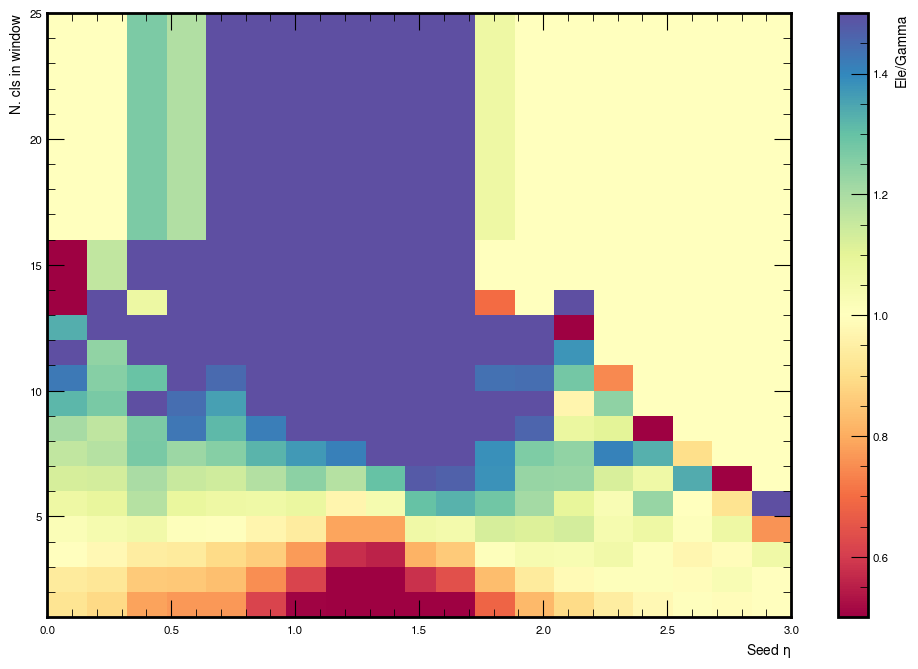

In [74]:
bins_eta = np.concatenate([np.linspace(0, 1.4442,10),  np.linspace(1.566, 3., 10)])
bins_ncls = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,25]


f, ax, = plt.subplots(1,figsize=(12,8), dpi=100)
c_ele, binx, by  = np.histogram2d(ak.to_numpy(df_ele.window_metadata.ncls), 
                                ak.to_numpy(abs(df_ele.seed_features.seed_eta)),
                                  bins=[ bins_ncls, bins_eta],
                               weights=w_ele_seed)
c_gamma, binx, by  = np.histogram2d(ak.to_numpy(df_gamma.window_metadata.ncls),
                                ak.to_numpy(abs(df_gamma.seed_features.seed_eta)),   
                                   bins=[ bins_ncls, bins_eta],
                                 weights=w_gamma_seed)

width_eta = (bins_eta - np.roll(bins_eta, 1))[1:]
width_ncls = (bins_ncls - np.roll(bins_ncls, 1))[1:]

# FLAtten out the by eta distribution
C_ele_eta = np.sum(c_ele, axis=0)
target_eta_ele = width_eta * np.sum(C_ele_eta)/ np.sum(width_eta) # ==> densita'
w_ele = target_eta_ele / C_ele_eta

C_gamma_eta = np.sum(c_gamma, axis=0)
target_eta_gamma = width_eta * np.sum(C_gamma_eta)/ np.sum(width_eta) # ==> densita'
w_gamma = target_eta_gamma / C_gamma_eta

# I want to profile on the eta direction and reweight the margin distribution of et 
# in different eta categories
A_ele = c_ele * w_ele
A_gamma = c_gamma * w_gamma

w_num = A_ele
w_denom = A_gamma
num_var = A_ele
denom_var = A_gamma

ratio= np.where( (w_denom>0)&(w_num>0),
                     w_num/w_denom,
                     1.) 
ratio_err =  np.where( (w_denom>0)&(w_num>0),
                           np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                           0.)
mesh = ax.pcolormesh(by, binx, ratio, cmap="Spectral", vmin=0.5, vmax=1.5)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("N. cls in window")
plt.colorbar(mesh,ax=ax, label="Ele/Gamma")


f.savefig(output_folder + f"/seed_eta_ncsltot_comparison_ratio_weightseed.png")
f.savefig(output_folder + f"/seed_eta_ncsltot_comparison_ratio_weightseed.pdf")
f.savefig(output_folder + f"/seed_eta_ncsltot_comparison_ratio_weightseed.svg")

We want to correct the effect in Number of cluster
profiling along eta, we don't want to correct the global discribution
The distribution by eta of the seed should be flat for both electrons and photons

In [75]:
w_ele_seed = corr_et_eta.evaluate(11,ak.to_numpy(df_ele.seed_features.et_seed),  
                         ak.to_numpy(abs(df_ele.seed_features.seed_eta)))
w_gamma_seed = corr_et_eta.evaluate(22,ak.to_numpy(df_gamma.seed_features.et_seed), 
                           ak.to_numpy(abs(df_gamma.seed_features.seed_eta)) )

bins_eta = np.concatenate([np.linspace(0, 1.4442,10),  np.linspace(1.566, 3., 10)])
bins_ncls = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,25]

c_ele, binx, by  = np.histogram2d(ak.to_numpy(df_ele.window_metadata.ncls), 
                                ak.to_numpy(abs(df_ele.seed_features.seed_eta)),
                                  bins=[ bins_ncls, bins_eta],
                               weights=w_ele_seed)
c_gamma, binx, by  = np.histogram2d(ak.to_numpy(df_gamma.window_metadata.ncls),
                                ak.to_numpy(abs(df_gamma.seed_features.seed_eta)),   
                                   bins=[ bins_ncls, bins_eta],
                                 weights=w_gamma_seed)

width_eta = (bins_eta - np.roll(bins_eta, 1))[1:]
width_ncls = (bins_ncls - np.roll(bins_ncls, 1))[1:]

# FLAtten out the by eta distribution
C_ele_eta = np.sum(c_ele, axis=0)
target_eta_ele = width_eta * np.sum(C_ele_eta)/ np.sum(width_eta) # ==> densita'
w_ele = target_eta_ele / C_ele_eta

C_gamma_eta = np.sum(c_gamma, axis=0)
target_eta_gamma = width_eta * np.sum(C_gamma_eta)/ np.sum(width_eta) # ==> densita'
w_gamma = target_eta_gamma / C_gamma_eta

# I want to profile on the eta direction and reweight the margin distribution of et 
# in different eta categories
A_ele = c_ele * w_ele
A_gamma = c_gamma * w_gamma

w_num = A_ele
w_denom = A_gamma
num_var = A_ele
denom_var = A_gamma


ratio= np.where( (w_denom>0)&(w_num>0),
                     w_num/w_denom,
                     1.) 


ratio_err =  np.where( (w_denom>0)&(w_num>0),
                           np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
                           0.)

# Adding flavour axes
ratio = np.stack([np.ones(ratio.shape), ratio], axis=0)
ratio_err = np.stack([np.ones(ratio_err.shape), ratio_err], axis=0)

h_weight = hist.Hist(
            hist.axis.IntCategory([11,22], name="flavour"),
            hist.axis.Variable(bins_ncls, name="ncls", label="Ncls in window"),
            hist.axis.Variable(bins_eta, name="seed_eta", label="Seed $\eta$"),
            storage="weight",
            data=np.concatenate([ratio[:,:,:,None], ratio_err[:,:,:,None]], axis=-1))

 # Exporting it to correctionlib
import correctionlib, rich
import correctionlib.convert
# without a name, the resulting object will fail validation
h_weight.name = "photon_to_electron_weight"
h_weight.label = "weight"
clibcorr_phoToEle = correctionlib.convert.from_histogram(h_weight)
clibcorr_phoToEle.description = """Reweight of photons to electron. The reweighting has to be applied on top of the 
seed eta-et flattening.
"""

# set overflow bins behavior (default is to raise an error when out of bounds)
for flavour_cat in clibcorr_phoToEle.data.content:
    flavour_cat.value.flow = "clamp"
 

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="Reweight of photons to electron",
    corrections=[clibcorr_phoToEle],
)
rich.print(cset)

with open(f"./reweightings/photon_to_electron_{version}.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))


/tmp/ipykernel_426/1053766215.py:42: RuntimeWarning: divide by zero encountered in divide
  w_num/w_denom,
/tmp/ipykernel_426/1053766215.py:42: RuntimeWarning: invalid value encountered in divide
  w_num/w_denom,
/tmp/ipykernel_426/1053766215.py:47: RuntimeWarning: divide by zero encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_426/1053766215.py:47: RuntimeWarning: invalid value encountered in multiply
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),
/tmp/ipykernel_426/1053766215.py:47: RuntimeWarning: invalid value encountered in divide
  np.sqrt((1/w_denom)**2 * num_var + (w_num/w_denom**2)**2 * denom_var),


CorrectionSet (schema v2)
Reweight of photons to electron
📂
└── 📈 photon_to_electron_weight (v0)
    Reweight of photons to electron. The reweighting has to be applied on top of the 
    seed eta-et flattening.
    
    Node counts: Category: 1, MultiBinning: 2
    ╭─── ▶ input ────╮ ╭──────────── ▶ input ────────────╮ ╭─────────── ▶ input ────────────╮
    │ flavour (int)  │ │ ncls (real)                     │ │ seed_eta (real)                │
    │ flavour        │ │ Ncls in window                  │ │ Seed $\eta$                    │
    │ Values: 11, 22 │ │ Range: [1.0, 25.0), overflow ok │ │ Range: [0.0, 3.0), overflow ok │
    ╰────────────────╯ ╰─────────────────────────────────╯ ╰────────────────────────────────╯
    ╭─── ◀ output ───╮
    │ weight (real)  │
    │ No description │
    ╰────────────────╯

### Try the application of the weights

In [76]:
cset = correctionlib.CorrectionSet.from_file(f"./reweightings/photon_to_electron_{version}.json")
corr_photon = cset["photon_to_electron_weight"]

In [77]:
w_gtoe = corr_photon.evaluate(22, ak.to_numpy(df_gamma.window_metadata.ncls), 
                         ak.to_numpy(abs(df_gamma.seed_features.seed_eta)))

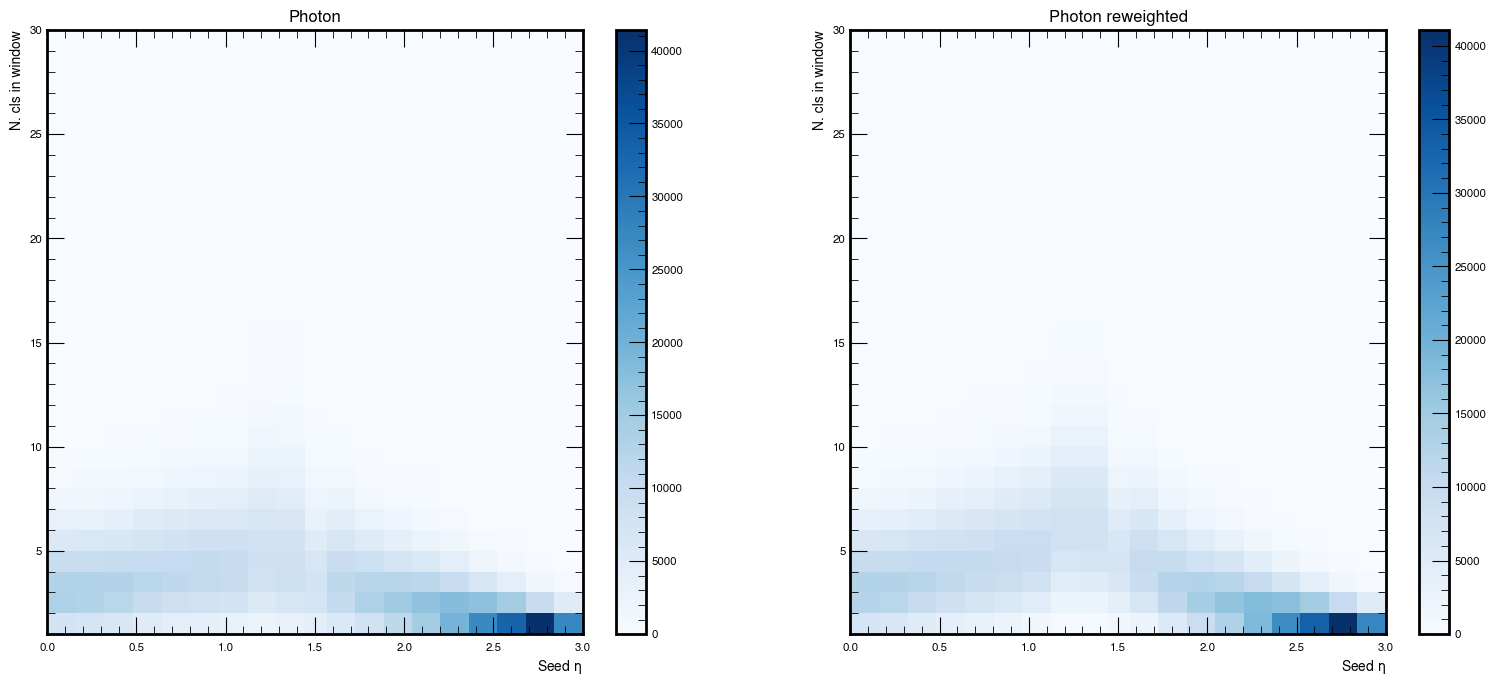

In [78]:
bins_et = np.concatenate([np.linspace(0, 1.4442,10),  np.linspace(1.566, 3, 10)])
bins_ncls = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,20,30]


f, (ax,ay) = plt.subplots(1,2,figsize=(19,8), dpi=100)
c, h, b , I =  ax.hist2d(ak.to_numpy(abs(df_gamma.seed_features.seed_eta)),
                         ak.to_numpy(df_gamma.window_metadata.ncls), 
                         weights=w_gamma_seed,
                          bins=[bins_et, bins_ncls])
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("N. cls in window")
ax.set_title("Photon")
plt.colorbar(I, ax=ax)

c, h, b , I =  ay.hist2d(ak.to_numpy(abs(df_gamma.seed_features.seed_eta)),
                         ak.to_numpy(df_gamma.window_metadata.ncls),  
                       weights=w_gtoe*w_gamma_seed,
                         bins=[bins_et, bins_ncls],)

ay.set_xlabel("Seed $\eta$")
ay.set_ylabel("N. cls in window")
ay.set_title("Photon reweighted")
plt.colorbar(I, ax=ay)


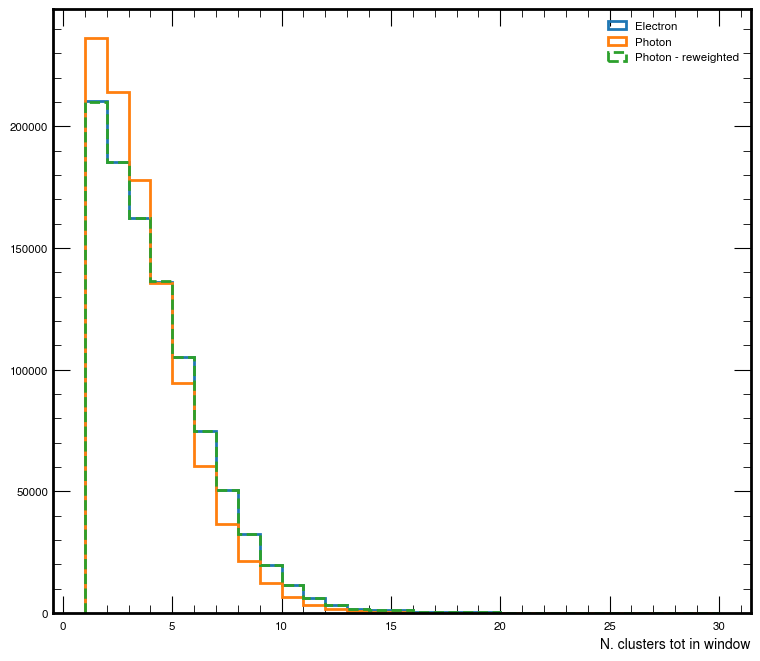

In [79]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)

ax.hist( ak.to_numpy(df_ele.window_metadata.ncls),weights=w_ele_seed,
        bins=bins_ncls,linewidth=2,
         histtype="step", label="Electron")
ax.hist( ak.to_numpy(df_gamma.window_metadata.ncls),weights=w_gamma_seed,
         bins=bins_ncls,linewidth=2,
         histtype="step", label="Photon")
ax.hist( ak.to_numpy(df_gamma.window_metadata.ncls), weights=w_gtoe*w_gamma_seed,
        bins=bins_ncls,
         histtype="step", label="Photon - reweighted", linewidth=2, linestyle="dashed")
ax.legend()
ax.set_xlabel("N. clusters tot in window")

f.savefig(output_folder + f"/photon_reweight_ncls.png")
f.savefig(output_folder + f"/photon_reweight_ncls.pdf")
f.savefig(output_folder + f"/photon_reweight_ncls.svg")

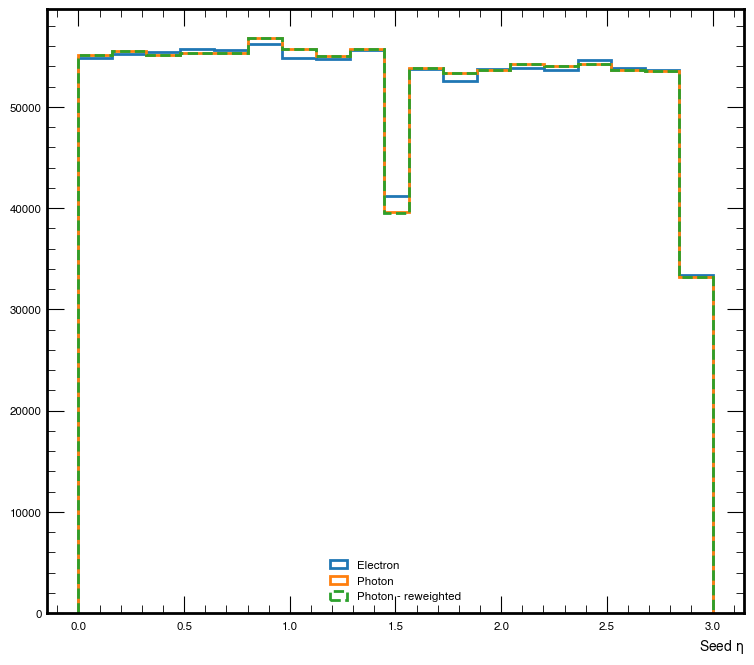

In [80]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)

ax.hist( ak.to_numpy(abs(df_ele.seed_features.seed_eta)), weights=w_ele_seed,
        bins=bins_eta,linewidth=2,
         histtype="step", label="Electron")
ax.hist( ak.to_numpy(abs(df_gamma.seed_features.seed_eta)), weights=w_gamma_seed,
        bins=bins_eta,linewidth=2,
         histtype="step", label="Photon")
ax.hist( ak.to_numpy(abs(df_gamma.seed_features.seed_eta)), weights=w_gtoe*w_gamma_seed, 
        bins=bins_eta,
         histtype="step", label="Photon - reweighted", linewidth=2, linestyle="dashed")
ax.legend(loc="lower center")
ax.set_xlabel("Seed $\eta$")

f.savefig(output_folder + f"/photon_reweight_eta.png")
f.savefig(output_folder + f"/photon_reweight_eta.pdf")
f.savefig(output_folder + f"/photon_reweight_eta.svg")

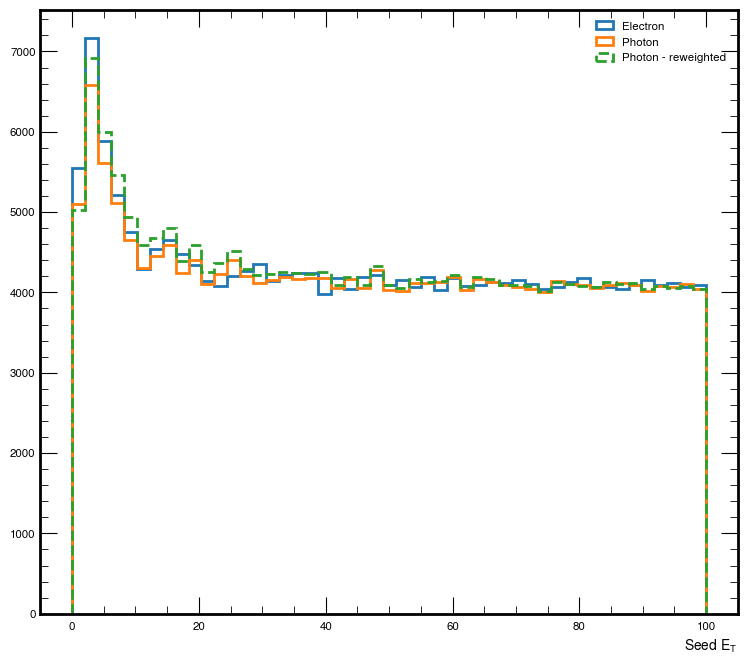

In [81]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)
bins_et = np.linspace(0,100,50)
ax.hist( ele_seed_et, weights=w_ele_seed,
        bins=bins_et,linewidth=2,
         histtype="step", label="Electron")
ax.hist( gam_seed_et, weights=w_gamma_seed,
        bins=bins_et,linewidth=2,
         histtype="step", label="Photon")
ax.hist( gam_seed_et, weights=w_gtoe*w_gamma_seed, 
        bins=bins_et,
         histtype="step", label="Photon - reweighted", linewidth=2, linestyle="dashed")
ax.legend()
ax.set_xlabel("Seed $E_T$")

f.savefig(output_folder + f"/photon_reweight_et.png")
f.savefig(output_folder + f"/photon_reweight_et.pdf")
f.savefig(output_folder + f"/photon_reweight_et.svg")

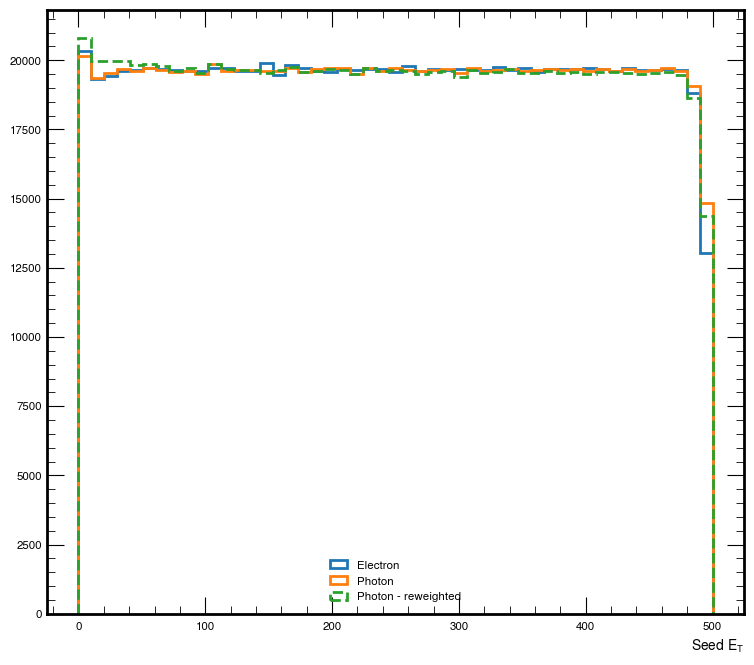

In [82]:
f, ax, = plt.subplots(1,figsize=(9,8), dpi=100)
bins_et = np.linspace(0,500,50)

mask_ele =  (ele_seed_eta<1.4442)|(ele_seed_eta>1.566)
mask_gamma =  (gam_seed_eta<1.4442)|(gam_seed_eta>1.566)

ax.hist( ele_seed_et[mask_ele], weights=w_ele_seed[mask_ele],
        bins=bins_et,linewidth=2,
         histtype="step", label="Electron")
ax.hist( gam_seed_et[mask_gamma], weights=w_gamma_seed[mask_gamma],
        bins=bins_et,linewidth=2,
         histtype="step", label="Photon")
ax.hist( gam_seed_et[mask_gamma], weights=w_gtoe[mask_gamma]*w_gamma_seed[mask_gamma], 
        bins=bins_et,
         histtype="step", label="Photon - reweighted", linewidth=2, linestyle="dashed")
ax.legend(loc="lower center")
ax.set_xlabel("Seed $E_T$")

f.savefig(output_folder + f"/photon_reweight_et_nocrack.png")
f.savefig(output_folder + f"/photon_reweight_et_nocrack.pdf")
f.savefig(output_folder + f"/photon_reweight_et_nocrack.svg")

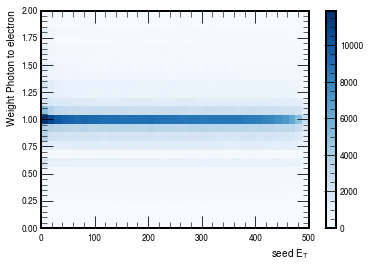

In [83]:
plt.hist2d(gam_seed_et, w_gtoe, bins=(40,25), range=((0,500),(0,2)))
plt.xlabel("seed $E_T$")
plt.ylabel("Weight Photon to electron")
plt.colorbar()

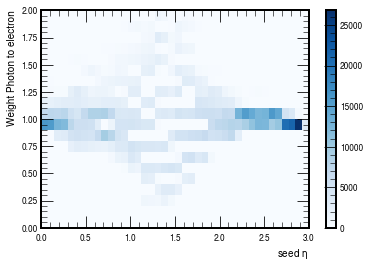

In [84]:
plt.hist2d(gam_seed_eta, w_gtoe, bins=(40,20), range=((0,3),(0,2)))
plt.xlabel("seed $\eta$")
plt.ylabel("Weight Photon to electron")
plt.colorbar()

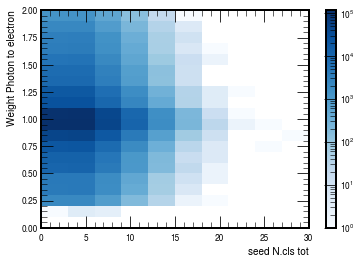

In [85]:
plt.hist2d(ak.to_numpy(df_ele.window_metadata.ncls), w_gtoe, bins=(10,20), range=((0,30),(0,2)), norm=LogNorm())
plt.xlabel("seed N.cls tot")
plt.ylabel("Weight Photon to electron")
plt.colorbar()
plt.savefig(output_folder + f"/photon_flattening_weight.png")
plt.savefig(output_folder + f"/photon_flattening_weight.pdf")
plt.savefig(output_folder + f"/photon_flattening_weight.svg")

## Redoing comparison plots with weights

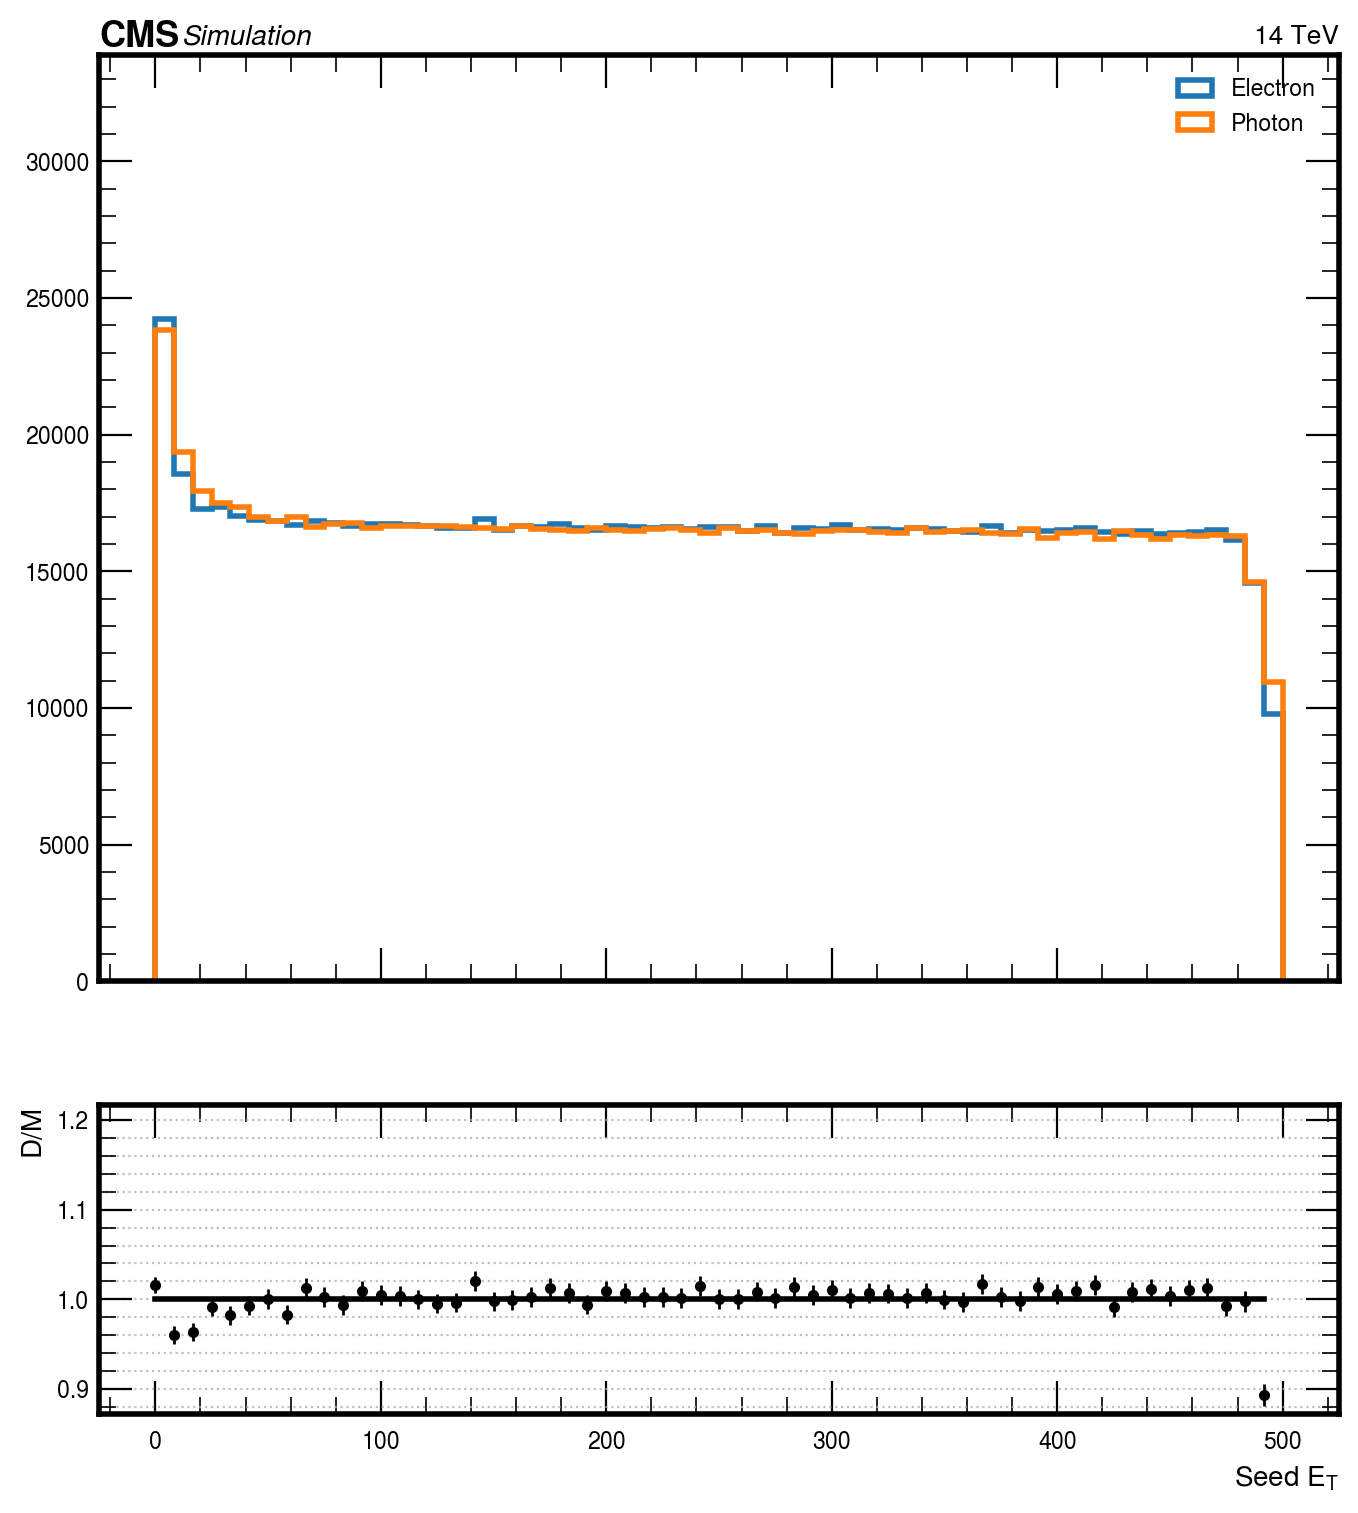

In [87]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="et_seed", label="Seed $E_T$", bins=60, xrange=(0, 500),
                wA=w_ele_seed, wB=w_gamma_seed*w_gtoe,
                output_folder= output_folder + "/plots_check_input/reweighted")

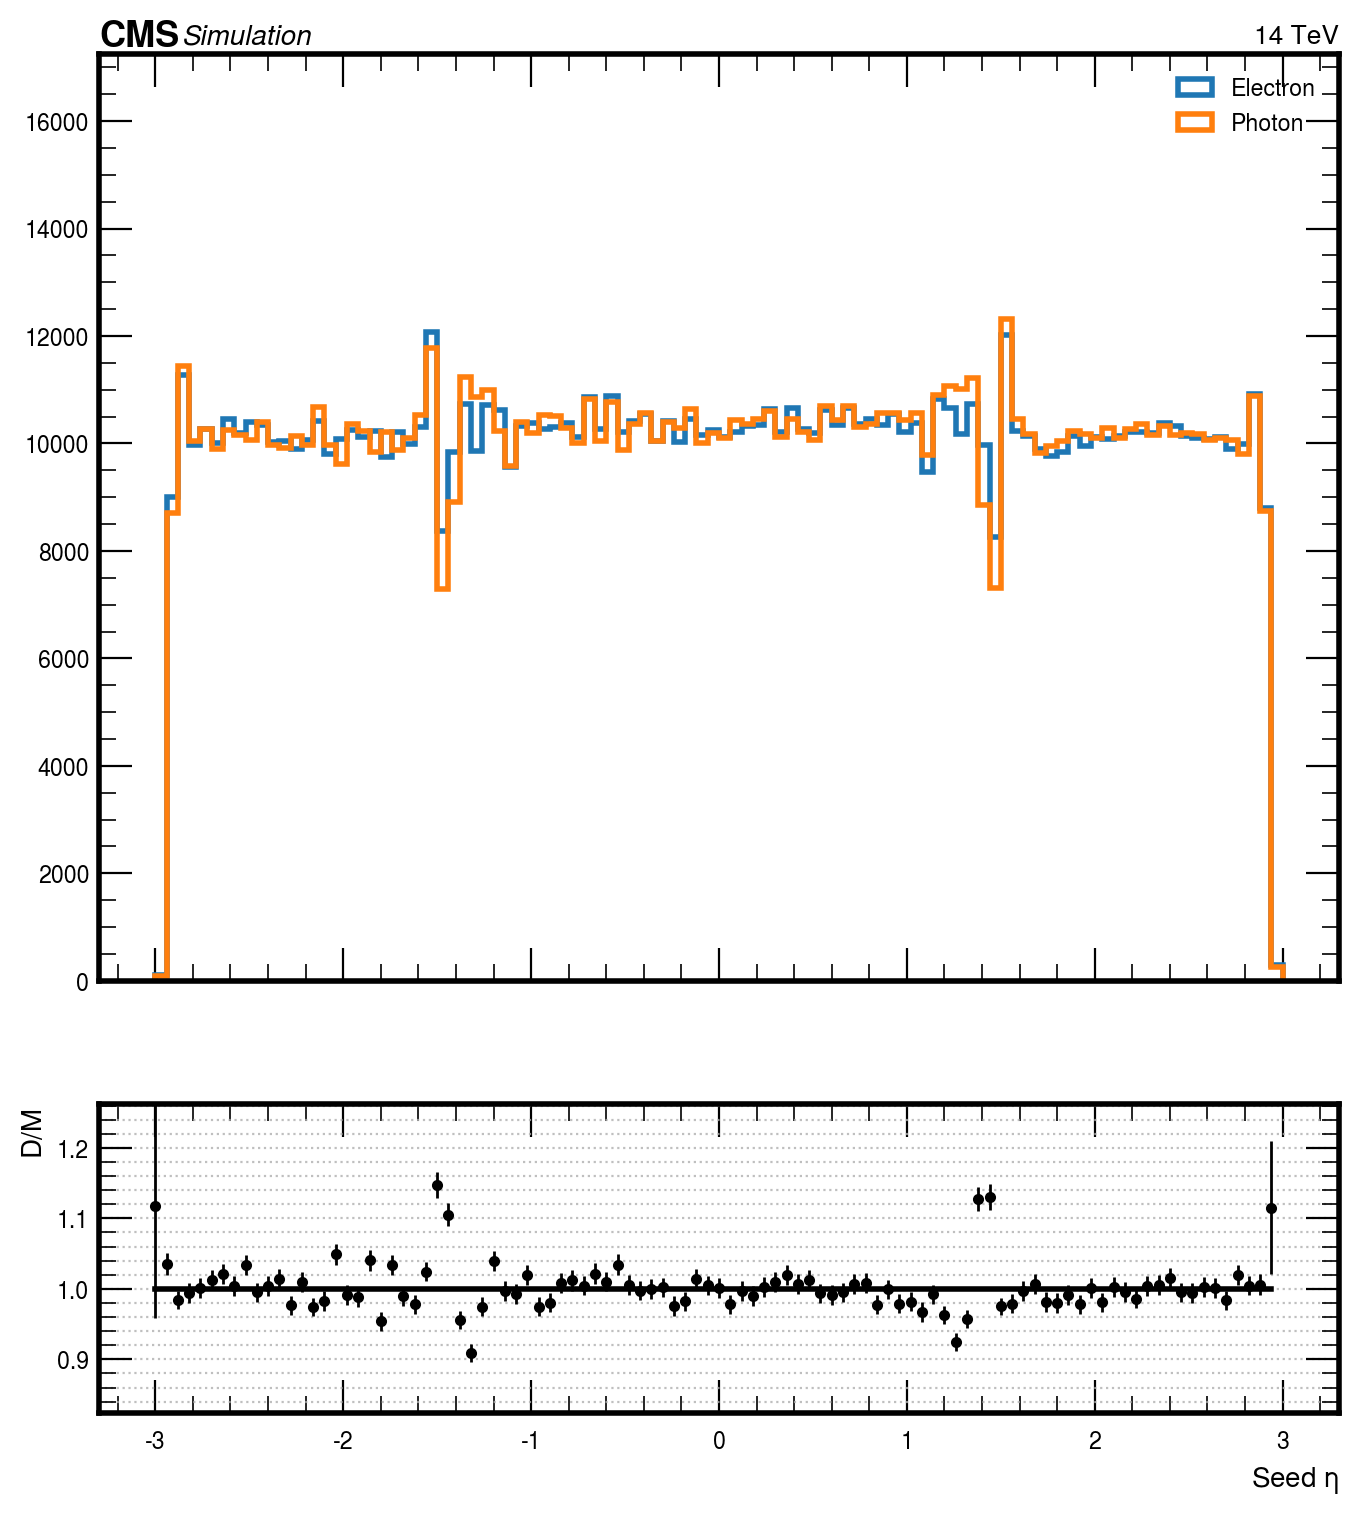

In [88]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="seed_eta", label="Seed $\eta$", bins=100, xrange=(-3, 3),
                wA=w_ele_seed, wB=w_gamma_seed*w_gtoe,
                output_folder= output_folder + "/plots_check_input/reweighted")

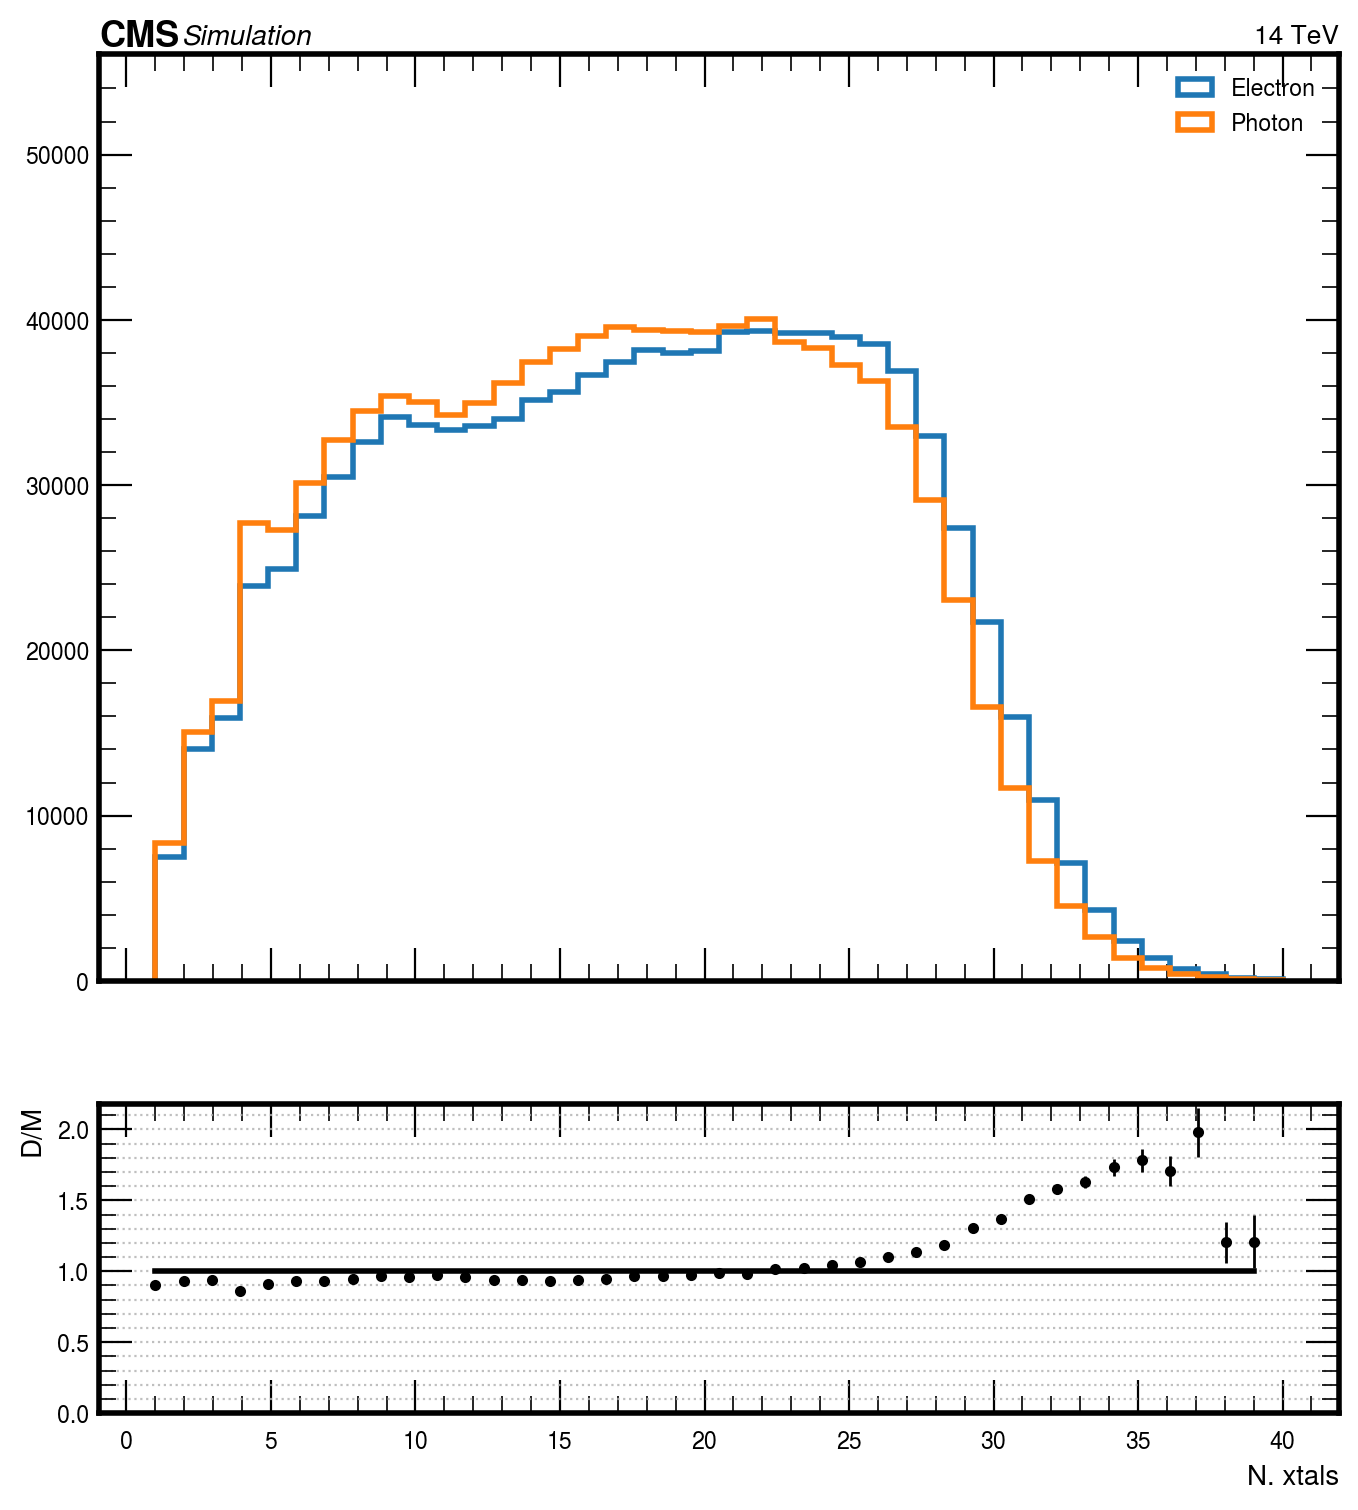

In [89]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="seed_nxtals", label="N. xtals", bins=40, xrange=(1, 40),
                wA=w_ele_seed, wB=w_gamma_seed*w_gtoe,
                output_folder= output_folder + "/plots_check_input/reweighted")

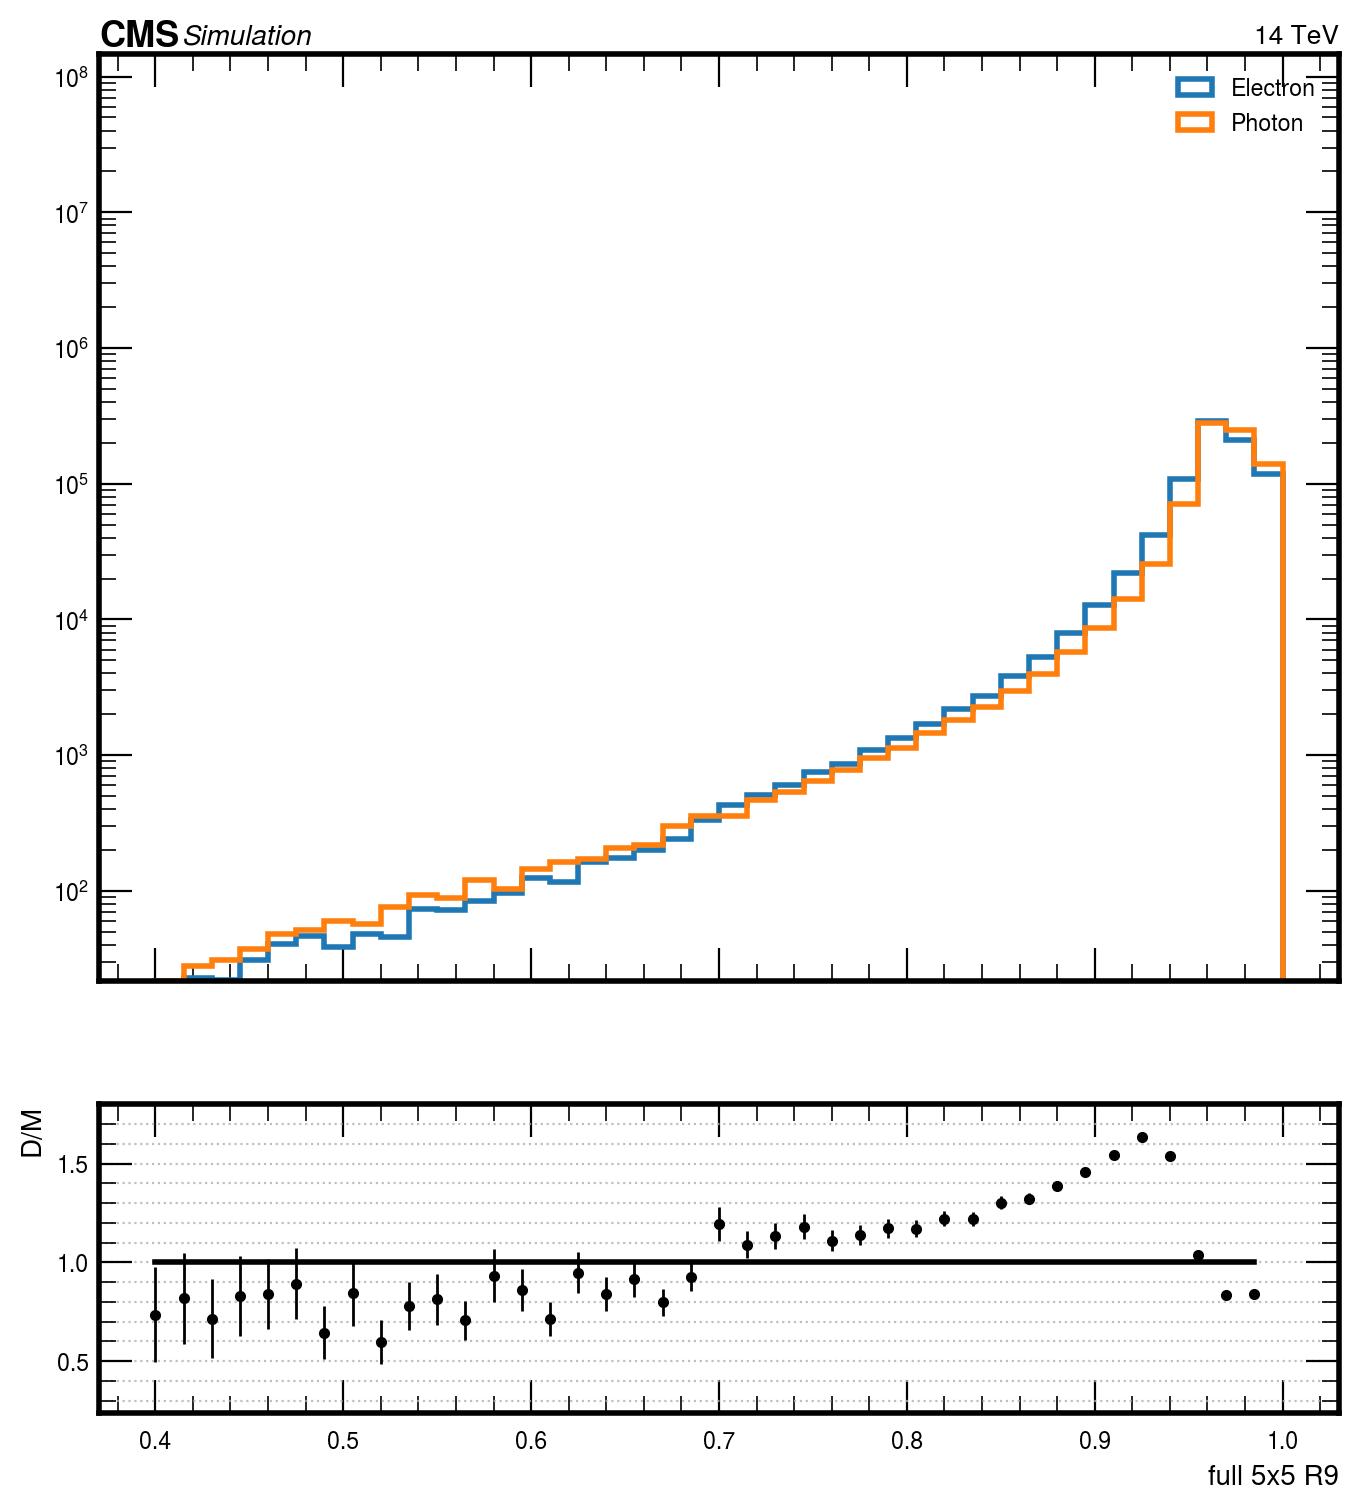

In [90]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="seed_f5_r9", label="full 5x5 R9", bins=40, xrange=(0.4,1.), ylog=True,
                wA=w_ele_seed, wB=w_gamma_seed*w_gtoe,
                output_folder= output_folder + "/plots_check_input/reweighted")

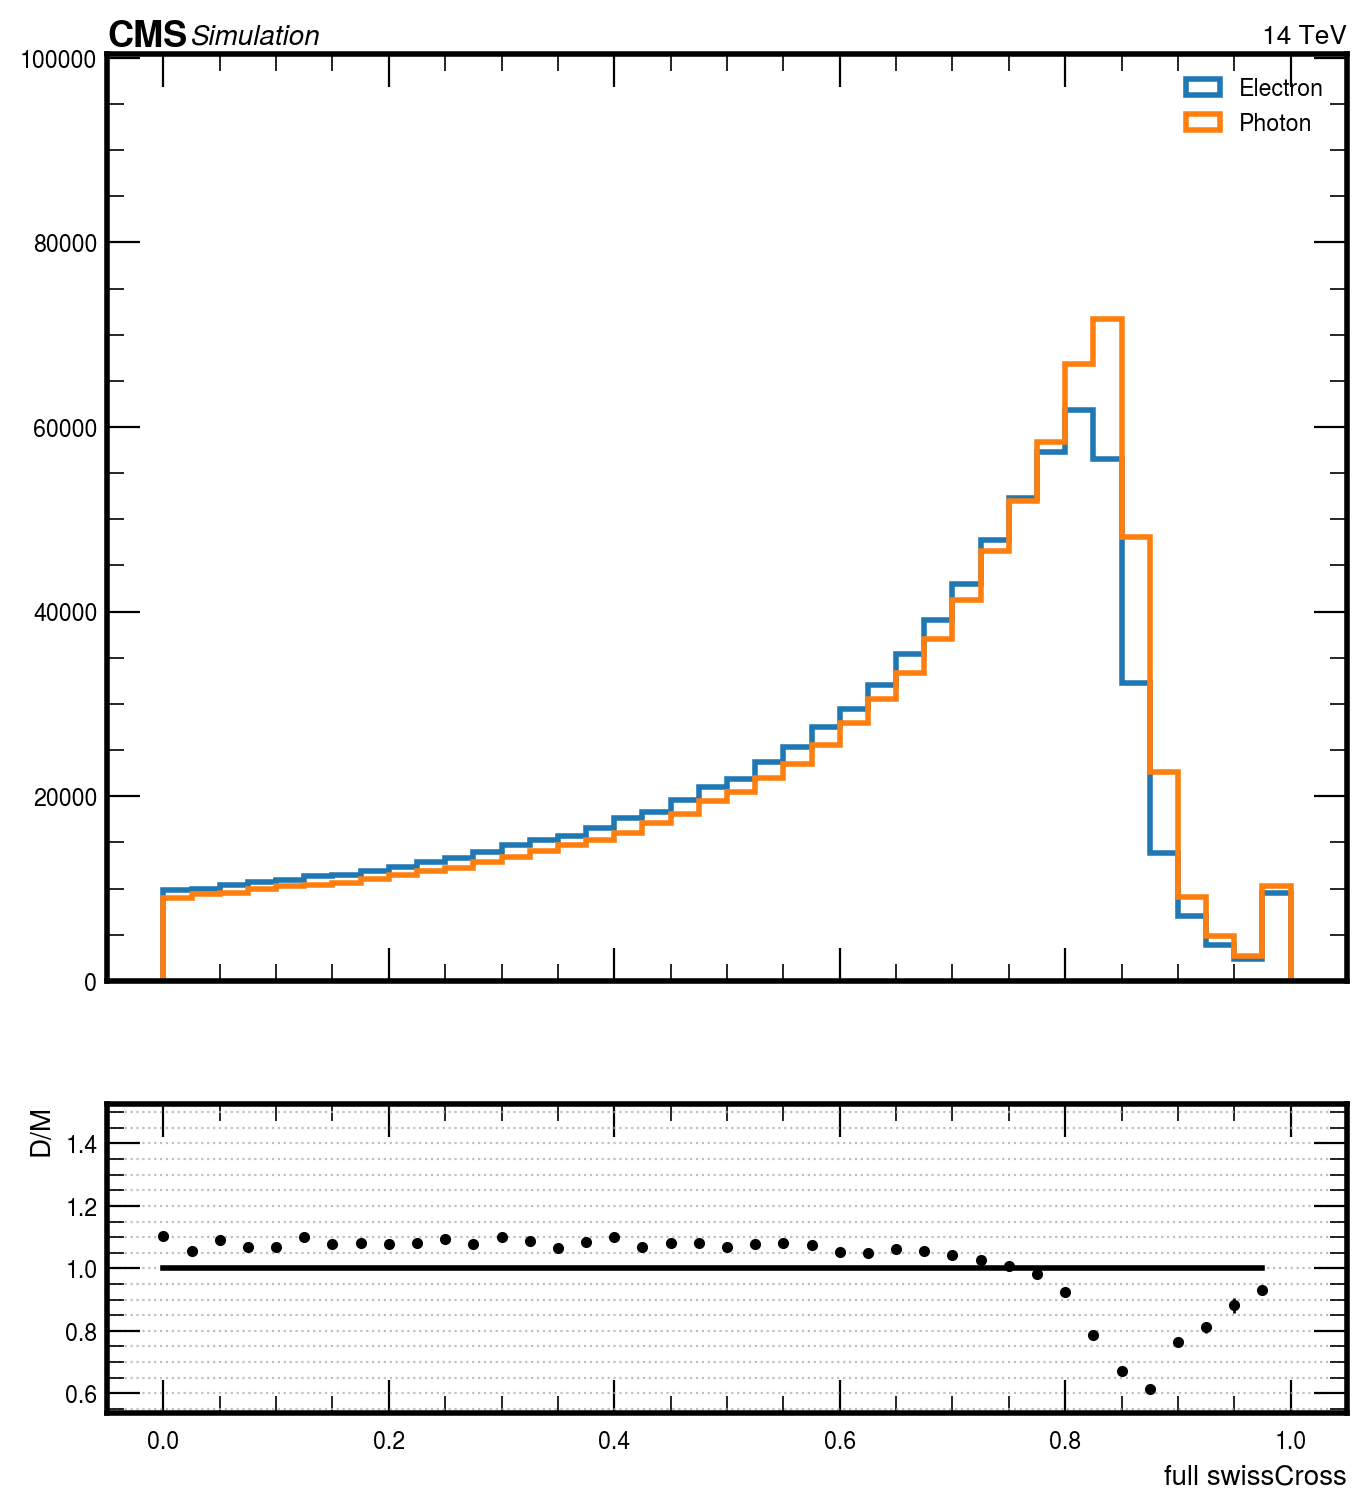

In [91]:
plot_comparison(df_ele.seed_features, df_gamma.seed_features,
                var="seed_swissCross", label="full swissCross", bins=40, xrange=(0.,1.),
                wA=w_ele_seed, wB=w_gamma_seed*w_gtoe,
                output_folder= output_folder + "/plots_check_input/reweighted")

/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:30: RuntimeWarning: divide by zero encountered in divide
  axr.errorbar(binX[:-1], A/B, xerr=0, yerr=errR,
/tmp/ipykernel_426/1062678864.py:30: RuntimeWarning: invalid value encountered in divide
  axr.errorbar(binX[:-1], A/B, xerr=0, yerr=errR,
/tmp/ipykernel_426/1062678864.py:33: RuntimeWarning: divide by zero encountered in divide
  deltaM = np.max(np.abs((A/B)-1))
/tmp/ipykernel_426/1062678864.py:33: RuntimeWarning: invalid value encountered in divide
  deltaM = np.max(np.abs((A/B)-1))


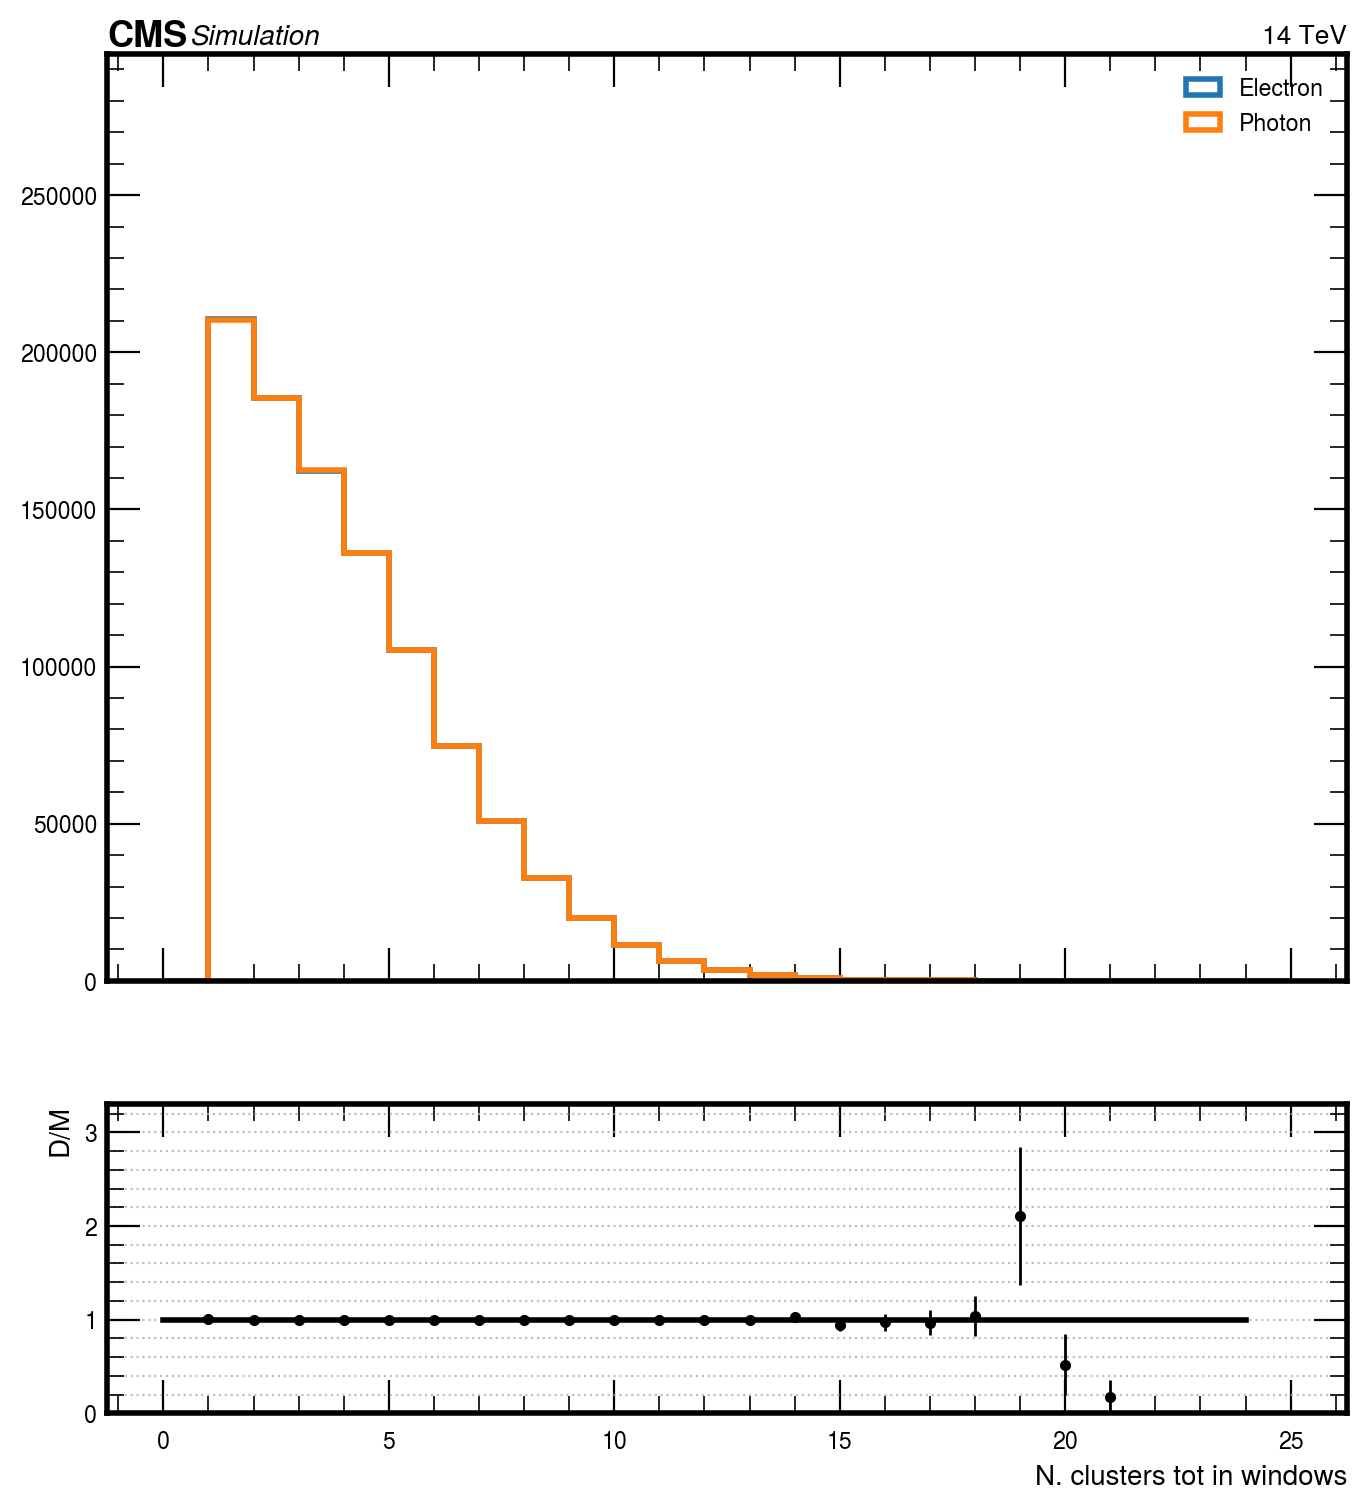

In [92]:
plot_comparison(df_ele.window_metadata, df_gamma.window_metadata,
                var="ncls", label="N. clusters tot in windows", bins=25, xrange=(0.,25),
                wA=w_ele_seed, wB=w_gamma_seed*w_gtoe,
                output_folder= output_folder + "/plots_check_input/reweighted")

/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:28: RuntimeWarning: invalid value encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_426/1062678864.py:30: RuntimeWarning: invalid value encountered in divide
  axr.errorbar(binX[:-1], A/B, xerr=0, yerr=errR,
/tmp/ipykernel_426/1062678864.py:33: RuntimeWarning: invalid value encountered in divide
  deltaM = np.max(np.abs((A/B)-1))


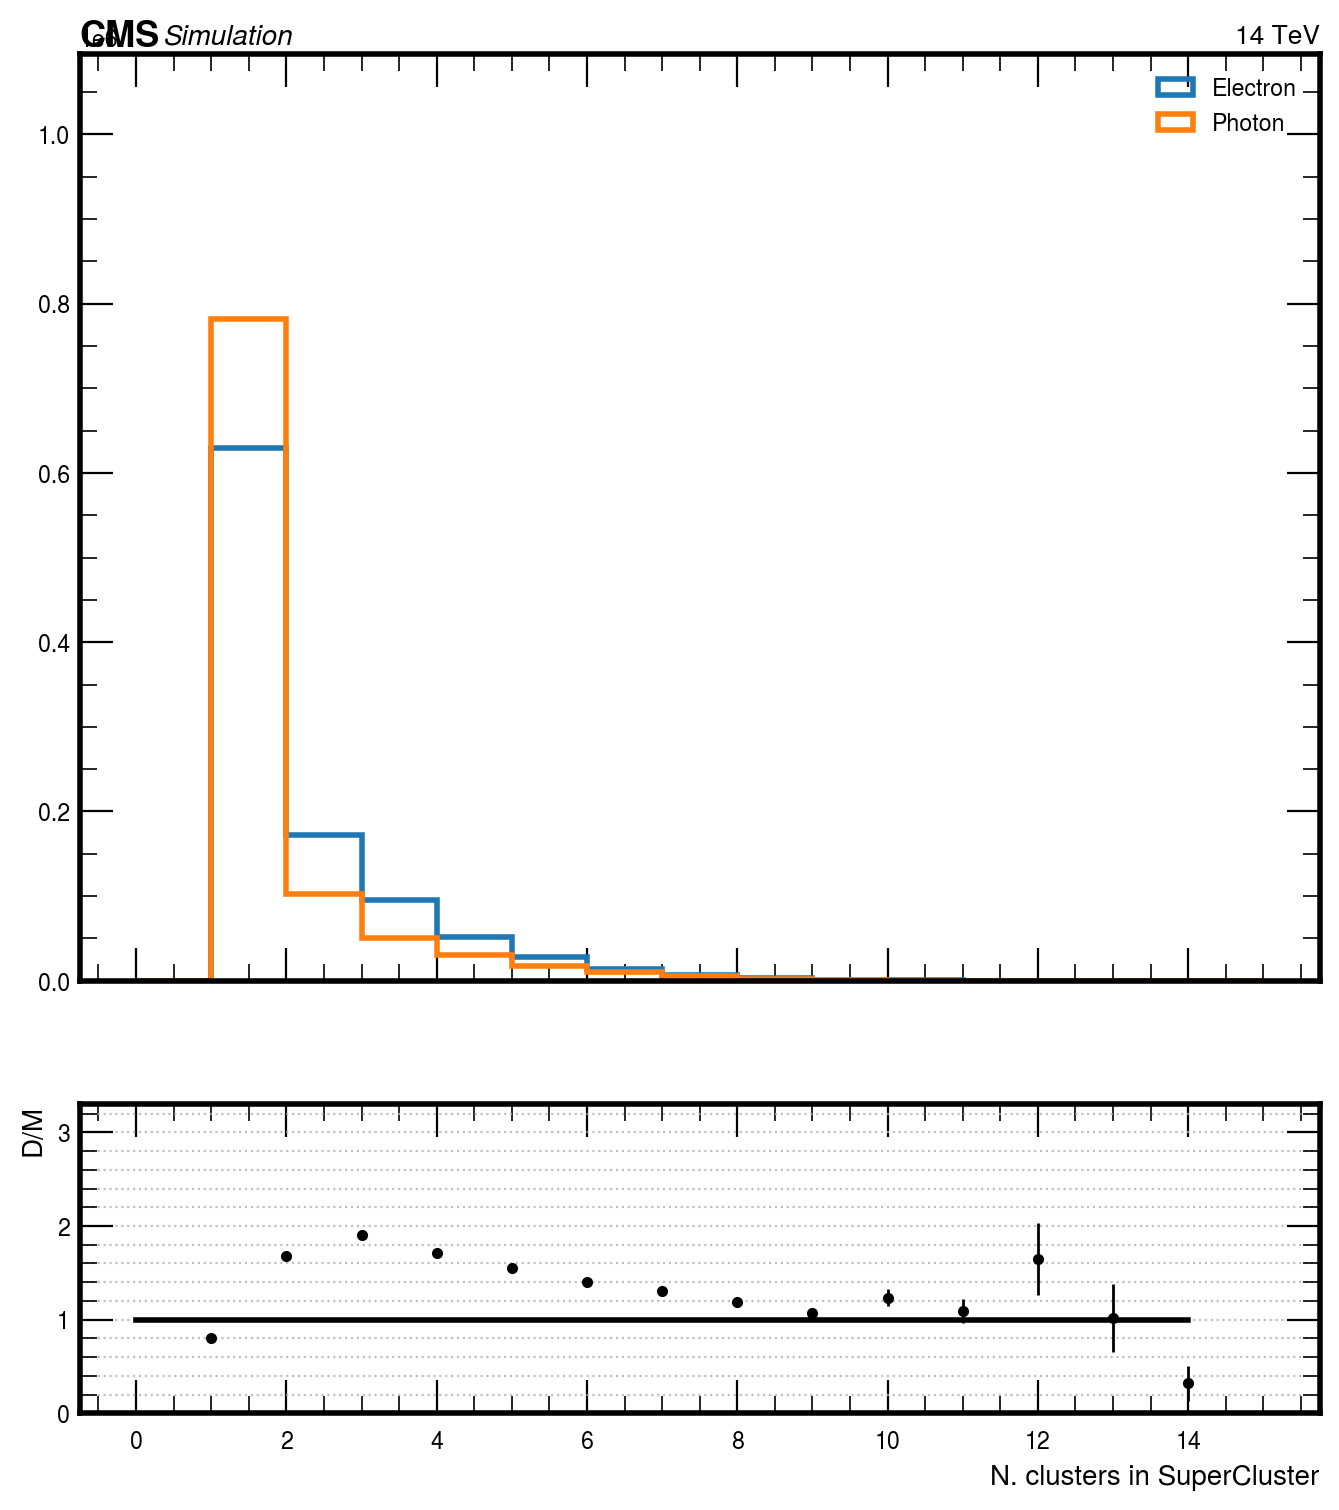

In [93]:
plot_comparison(df_ele.window_metadata, df_gamma.window_metadata,
                var="nclusters_insc", label="N. clusters in SuperCluster", bins=15, xrange=(0.,15),
                wA=w_ele_seed, wB=w_gamma_seed*w_gtoe,
                output_folder= output_folder + "/plots_check_input/reweighted")

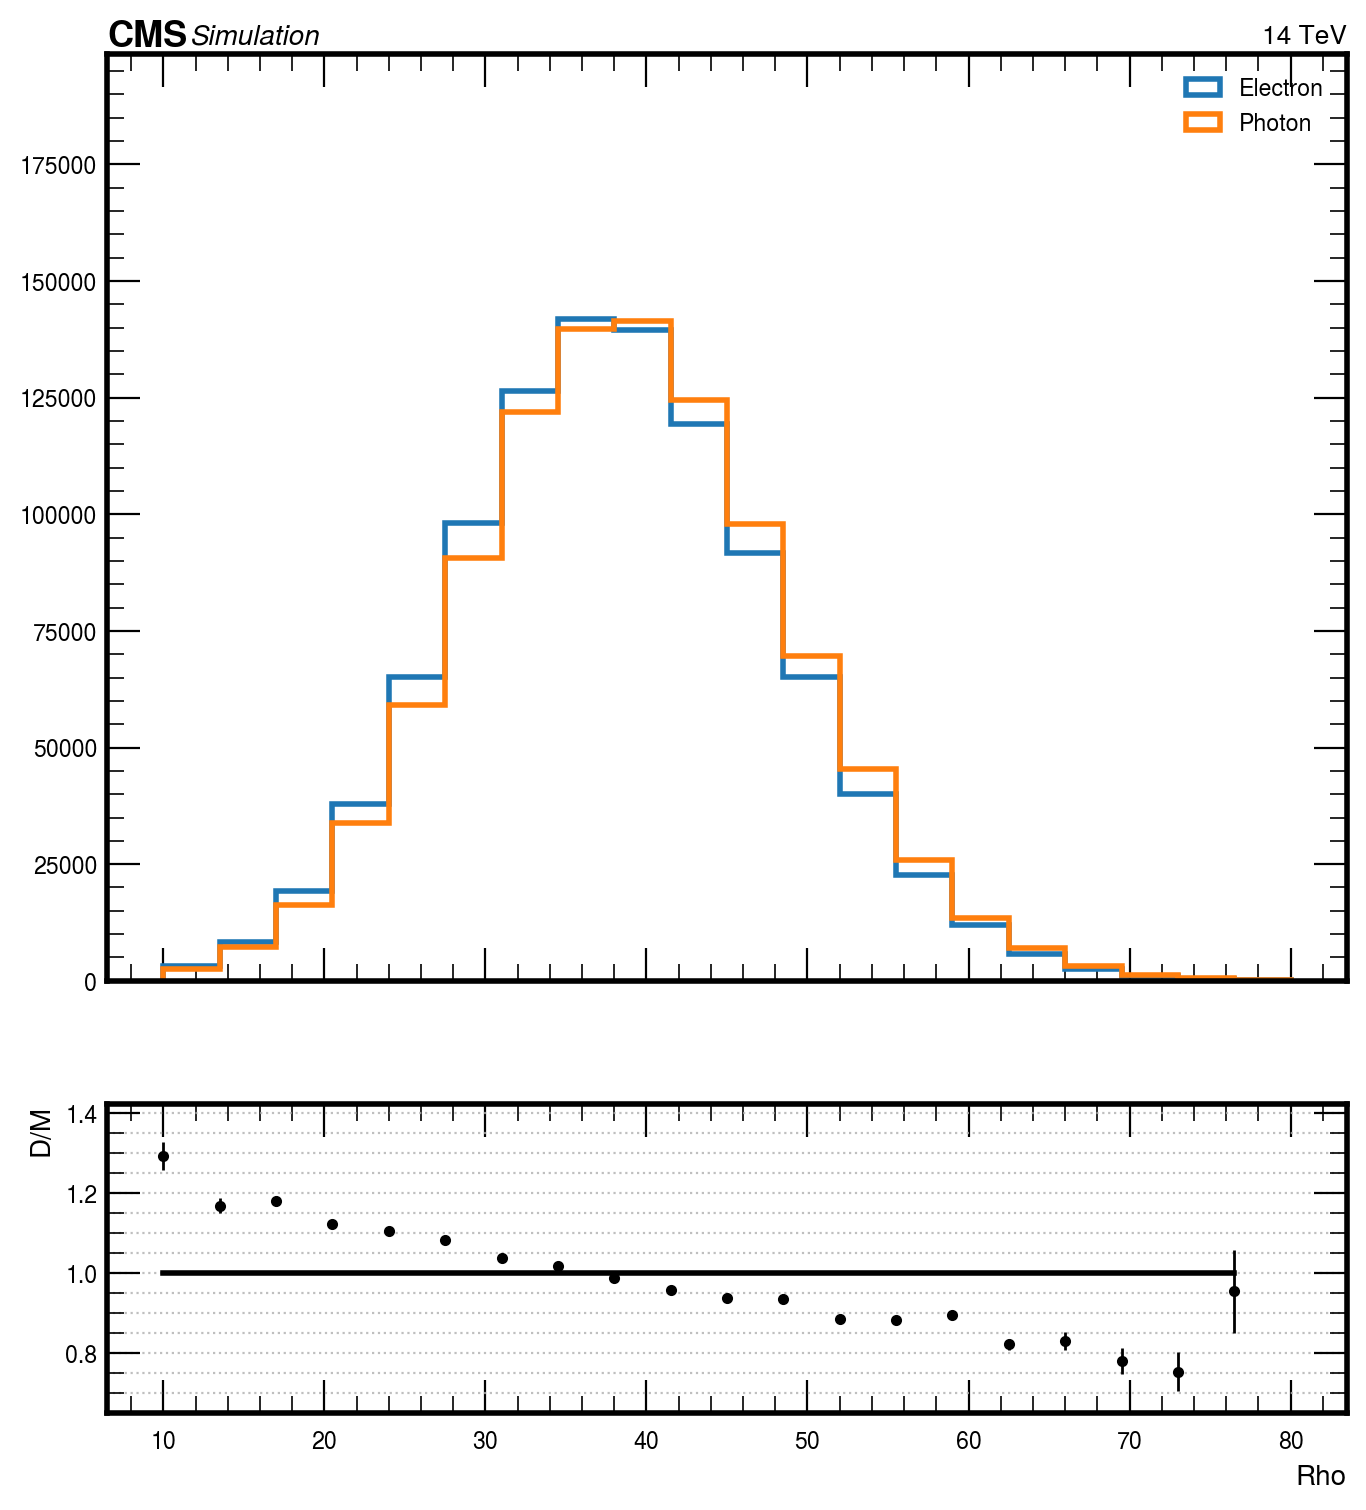

In [94]:
plot_comparison(df_ele.window_metadata, df_gamma.window_metadata,
                var="rho", label="Rho", bins=20, xrange=(10.,80),
                wA=w_ele_seed, wB=w_gamma_seed*w_gtoe,
                output_folder= output_folder + "/plots_check_input/reweighted")

## Building a single correction set

We have `clibcorr_seed` and `clibcorr_phoToEle` to use.

In [95]:
for corr in [clibcorr_seed, clibcorr_phoToEle]:
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

Correction flattening_seed_et_eta has 3 inputs
   Input flavour (int): flavour
   Input seed_et (real): seed_et
   Input seed_eta (real): seed_eta
Correction photon_to_electron_weight has 3 inputs
   Input flavour (int): flavour
   Input ncls (real): Ncls in window
   Input seed_eta (real): Seed $\eta$


In [96]:
import correctionlib.schemav2 as cs

cset = cs.CorrectionSet(
    schema_version=2,
    corrections=[
        clibcorr_seed,
        clibcorr_phoToEle,
    ],
    compound_corrections=[
        cs.CompoundCorrection(
            name="total_reweighting",
            description="Reweight stacking seed flattening and phoToEle weight",
            inputs=[
                cs.Variable(name="flavour", type="int", description="Flavour"),
                cs.Variable(name="seed_eta", type="real", description="Seed Eta"),
                cs.Variable(name="seed_et", type="real", description="Seed Et"),
                cs.Variable(name="ncls", type="real", description="Tot. number of cluster in the window"),
            ],
            output=cs.Variable(name="weight", type="real", description="Weight for seed flattening and photon to ele"),
            inputs_update=[],
            input_op="*",
            output_op="*",
            stack=["flattening_seed_et_eta", "photon_to_electron_weight"],
        )
    ]
)

with open(f"./reweightings/total_reweighting_{version}.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))

oneshot = cset.to_evaluator().compound["total_reweighting"]

In [97]:
 print("One-shot smearing is equivalent to two-step procedure?")
print(np.allclose(
    oneshot.evaluate(11, ele_seed_eta, ele_seed_et, ele_ncls_tot),
    clibcorr_seed.to_evaluator().evaluate(11,ele_seed_et, ele_seed_eta)*\
    clibcorr_phoToEle.to_evaluator().evaluate(11, ele_ncls_tot, ele_seed_eta )
))

One-shot smearing is equivalent to two-step procedure?
True


In [98]:
 print("One-shot smearing is equivalent to two-step procedure?")
print(np.allclose(
    oneshot.evaluate(22, gam_seed_eta, gam_seed_et, gam_ncls_tot),
    clibcorr_seed.to_evaluator().evaluate(22,gam_seed_et, gam_seed_eta)*\
    clibcorr_phoToEle.to_evaluator().evaluate(22, gam_ncls_tot, gam_seed_eta )
))

One-shot smearing is equivalent to two-step procedure?
True


In [99]:
rich.print(cset)

CorrectionSet (schema v2)
No description
📂
├── 📈 flattening_seed_et_eta (v0)
│   Reweight Seed Et - Eta
│   Node counts: Category: 1, MultiBinning: 2
│   ╭─── ▶ input ────╮ ╭──────────── ▶ input ─────────────╮ ╭─────────── ▶ input ────────────╮
│   │ flavour (int)  │ │ seed_et (real)                   │ │ seed_eta (real)                │
│   │ flavour        │ │ seed_et                          │ │ seed_eta                       │
│   │ Values: 11, 22 │ │ Range: [0.0, 500.0), overflow ok │ │ Range: [0.0, 3.0), overflow ok │
│   ╰────────────────╯ ╰──────────────────────────────────╯ ╰────────────────────────────────╯
│   ╭─── ◀ output ───╮
│   │ weight (real)  │
│   │ No description │
│   ╰────────────────╯
├── 📈 photon_to_electron_weight (v0)
│   Reweight of photons to electron. The reweighting has to be applied on top of the 
│   seed eta-et flattening.
│   
│   Node counts: Category: 1, MultiBinning: 2
│   ╭─── ▶ input ────╮ ╭──────────── ▶ input ────────────╮ ╭─────────── ▶ input ────────────╮
│   │ flavour (int)  │ │ ncls (real)                     │ │ seed_eta (real)                │
│   │ flavour        │ │ Ncls in window                  │ │ Seed $\eta$                    │
│   │ Values: 11, 22 │ │ Range: [1.0, 25.0), overflow ok │ │ Range: [0.0, 3.0), overflow ok │
│   ╰────────────────╯ ╰─────────────────────────────────╯ ╰────────────────────────────────╯
│   ╭─── ◀ output ───╮
│   │ weight (real)  │
│   │ No description │
│   ╰────────────────╯
└── 📈📈 total_reweighting
    Reweight stacking seed flattening and phoToEle weight
    ╭──────── 🔢 stack ─────────╮
    │ flattening_seed_et_eta    │
    │ photon_to_electron_weight │
    ╰───────────────────────────╯
    ╭─── ▶ input ───╮ ╭──── ▶ input ────╮ ╭─── ▶ input ────╮ ╭────────────── ▶ input ───────────────╮
    │ flavour (int) │ │ seed_eta (real) │ │ seed_et (real) │ │ ncls (real)                          │
    │ Flavour       │ │ Seed Eta        │ │ Seed Et        │ │ Tot. number of cluster in the window │
    ╰───────────────╯ ╰─────────────────╯ ╰────────────────╯ ╰──────────────────────────────────────╯
    ╭────────────────── ◀ output ──────────────────╮
    │ weight (real)                                │
    │ Weight for seed flattening and photon to ele │
    │ Update operation: (*)                        │
    ╰──────────────────────────────────────────────╯

### Test the application

In [100]:
%%timeit
f = df_ele.cl_features[df_ele.cl_labels.is_seed==1][["cluster_eta","et_cluster"]]
seed_eta = abs(ak.flatten(f.cluster_eta))
seed_et = ak.flatten(f.et_cluster)
ncls = df_ele.window_metadata.ncls
oneshot.evaluate(11, seed_eta, seed_et, ncls)

469 ms ± 7.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
flavour = np.asarray(df.window_metadata.flavour)

In [102]:
weight = np.ones((2000000,), dtype=float)

In [103]:
seed_df = df.cl_features[df.cl_labels.is_seed==1][["cluster_eta","et_cluster"]]
seed_eta = abs(ak.flatten(seed_df.cluster_eta))
seed_et = ak.flatten(seed_df.et_cluster)
ncls_tot = df.window_metadata.ncls

In [104]:
mask_ele = flavour == 11
mask_pho = flavour == 22

In [105]:
index = np.indices([2000000]).flatten()[mask_ele]

In [106]:
index.shape

(1000000,)

In [107]:
index.shape

(1000000,)

In [108]:
weight

array([1., 1., 1., ..., 1., 1., 1.])

In [109]:
weight[index] = oneshot.evaluate(11, seed_eta[mask_ele], seed_et[mask_ele], ncls_tot[mask_ele])
#weight[index] = oneshot.evaluate(22, seed_eta[mask_pho], seed_et[mask_pho], ncls_tot[mask_pho])

In [110]:
weight

array([1.05037361, 0.97332034, 0.99305099, ..., 1.        , 1.        ,
       1.        ])